#### Note that in this version of OptScale 1, we no longer use MuSigmaPredictor for MLE starting point. Instead, we set Mu = 0.8 and Sigma = 0.2 for all datasets, making this a simplified but still effective OptScale.

In [1]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import root
from scipy.optimize import minimize
from tqdm import tqdm
import os 

from utils import *

# Set random seed for reproducibility (same as in train_predictor_initial.py)
torch.manual_seed(42)
np.random.seed(42)


device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

DATASET = 'MATH500'

/home/wangyoukang/anaconda3/envs/test_scale/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:1


In [2]:
# Initialize tokenizer - same model as in train_predictor_initial.py
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

def load_validation_data(batch_size=16):
    with open('../../Data/test_prompts/MATH500_test_Llama8B_BoN.json', 'r') as f:
        dataset = json.load(f)
        
    with open('../../Data/all_qwen3_8b/parallel/scored_math500_test_qwen3.json', 'r') as f:
        completion_data = json.load(f)
    
    # Prepare data
    texts = [item['problem'] for item in dataset]
    gt_answers = [item['answer'] for item in dataset]
    completions = [item['score']['completions'] for item in completion_data]
    completion_tokens = [item['score']['completion_tokens'] for item in completion_data]
    scores = [item['score']['scores'] for item in completion_data]
    
    val_texts = texts
    val_gt_answers = gt_answers
    val_completions = completions
    val_completion_tokens = completion_tokens
    val_scores = scores
    
    print(f"Total dataset size: {len(texts)}")
    print(f"Validation size: {len(val_texts)}")
    
    # Load or predict mu/sigma parameters
    if os.path.exists(f'{DATASET}_train_mu_sigma.json'):
        print("Loading existing mu/sigma parameters...")
        with open(f'{DATASET}_train_mu_sigma.json', 'r') as f:
            val_labels = json.load(f)
    else:
        print("Predicting mu/sigma parameters using QwenMuSigmaPredictor...")
        
        # Clear GPU cache before loading model
        torch.cuda.empty_cache()
        
        # Load model on CPU first to avoid GPU memory issues
        # print("Loading model on CPU first...")
        model = QwenMuSigmaPredictor(model_name).to(device)
        
        # Load checkpoint on CPU
        checkpoint_path = '/home/wangyoukang/Desktop/Test-time Scaling/large-scale_testing/Qwen_Predictor_Training/best_predictor_model_direct_qwen_real.pt'
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint)
        
        # # Move model to GPU after loading checkpoint
        # print("Moving model to GPU...")
        # model = model.to(device)
        # model.eval()
        
        # # Clear CPU cache
        # del checkpoint
        # torch.cuda.empty_cache()
        
        # Create dataset and dataloader for prediction
        val_dataset = TextDatasetNoLabels(val_texts, tokenizer)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Make predictions
        val_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids, attention_mask)
                val_labels.extend(outputs.cpu().numpy().tolist())
        
        # Save predictions
        with open(f'{DATASET}_train_mu_sigma.json', 'w') as f:
            json.dump(val_labels, f)
            
    # Create validation dataset and dataloader
    val_dataset = TextDataset(val_texts, val_labels, tokenizer)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return val_loader, val_texts, val_gt_answers, val_completions, val_completion_tokens, val_scores, val_labels, tokenizer

# Load validation data
val_loader, val_texts, val_gt_answers, val_completions, val_completion_tokens, val_scores, val_labels, tokenizer = load_validation_data()


Total dataset size: 500
Validation size: 500
Predicting mu/sigma parameters using QwenMuSigmaPredictor...
Qwen2Model(
  (embed_tokens): Embedding(151936, 1536)
  (layers): ModuleList(
    (0-27): 28 x Qwen2DecoderLayer(
      (self_attn): Qwen2Attention(
        (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
        (k_proj): Linear(in_features=1536, out_features=256, bias=True)
        (v_proj): Linear(in_features=1536, out_features=256, bias=True)
        (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
      )
      (mlp): Qwen2MLP(
        (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
    )
  )
  (norm): Qwen2RMSNorm((15

In [3]:
# Ground truth parameters (using full data)
original_params_compare = []
for idx, score in enumerate(val_scores):
    data = np.array(score[0][:100])
    initial_mu = np.mean(data)
    initial_sigma = np.std(data)
    result = minimize(lambda params: neg_log_likelihood(params, data), 
                     [initial_mu, initial_sigma],
                     bounds=[(None, None), (1e-6, None)], 
                     method='L-BFGS-B')
    mu_hat, sigma_hat = result.x
    original_params_compare.append((mu_hat, sigma_hat))

# Estimates using limited data (first 10 samples)
mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

print("\nComparison of Estimation Methods (first 10 examples):")
print("ID   Predictor_μ   Predictor_σ  MLE_μ     MLE_σ     MAP_μ     MAP_σ     GT_μ      GT_σ")
print("-" * 90)

peek_number = 3

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


/home/wangyoukang/anaconda3/envs/test_scale/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0



Comparison of Estimation Methods (first 10 examples):
ID   Predictor_μ   Predictor_σ  MLE_μ     MLE_σ     MAP_μ     MAP_σ     GT_μ      GT_σ
------------------------------------------------------------------------------------------
0         0.6015      0.1227    0.9056    0.2703    0.6795    0.1769    0.8022    0.0944
1         0.4543      0.0766    0.9764    0.0040    0.6530    0.2311    0.9713    0.0107
2         0.6429      0.1356    0.8817    0.0274    0.8140    0.0752    0.8473    0.1104
3         0.4399      0.0769    0.9825    0.0014    0.6344    0.2413    0.9783    0.0098
4         0.4217      0.1085    0.9765    0.0027    0.5976    0.2630    0.9715    0.0093
5         0.4133      0.0200    0.9813    0.0063    0.6294    0.2283    0.9770    0.0161
6         0.5740      0.1303    0.9840    0.0006    0.7750    0.1949    0.9844    0.0052
7         0.5280      0.0904    0.9726    0.0069    0.7403    0.1943    0.9708    0.0210
8         0.4172      0.0738    0.9030    0.0247    0.6

In [4]:
# Load baseline results
with open(f'{DATASET}_BoN_results.json', 'r') as f:
    data = json.load(f)

# Reconstruct the baseline arrays
baseline_accuracy_values = []
baseline_average_token_counts = []

for item in data:
    baseline_accuracy_values.append(item['accuracy'])
    baseline_average_token_counts.append(item['token_count'])

Target Score Panel: [0.85, 0.9, 0.925, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 8

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/8 [00:00<?, ?it/s]

MLE Min N Required [8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 8, 3, 3, 3, 3, 4, 3, 8, 5, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 7, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 5, 5, 8, 3, 8, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 7, 8, 3, 6, 3, 3, 8, 3, 3, 3, 3, 3, 7, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.85, Percentile: 0.01
MLE - Accuracy: 0.9100, Average Token Count: 20907.45
MLE Min N Required [8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 8, 3, 3, 3, 3, 4, 3, 8, 5, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 6, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 7, 3, 3, 3, 8, 3, 8, 4, 4, 8, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 6, 8, 3, 5, 3, 3, 8, 3, 3, 3, 3, 3, 6, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.85, Percentile: 0.02
MLE - Accuracy: 0.9100, Average Token Count: 20677.00
MLE Min N Required [8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 8, 3, 3, 8, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 5, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 6, 3, 3, 3, 8, 3, 8, 4, 4, 8, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 5, 8, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 5, 3, 3, 8, 3, 7, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.85, Percentile: 0.035
MLE - Accuracy: 0.9100, Average Token Count: 20365.83
MLE Min N Required [8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 8, 3, 3, 8, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 5, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 6, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 4, 8, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 5, 3, 3, 8, 3, 6, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.85, Percentile: 0.05
MLE - Accuracy: 0.9100, Average Token Count: 20166.21
MLE Min N Required [7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 7, 3, 3, 8, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 4, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 5, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 4, 8, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 5, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.85, Percentile: 0.075
MLE - Accuracy: 0.9100, Average Token Count: 19893.90
MLE Min N Required [6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 6, 3, 3, 8, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 4, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 5, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 4, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 5, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

Target Score (MLE):  12%|█▎        | 1/8 [00:08<01:00,  8.70s/it]

MLE - Target Score: 0.85, Percentile: 0.1
MLE - Accuracy: 0.9100, Average Token Count: 19793.10


MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 6, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 4, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 5, 8, 3, 8, 3, 3, 4, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9100, Average Token Count: 22340.23
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 6, 3, 8, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 4, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 4, 8, 3, 8, 3, 3, 4, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9100, Average Token Count: 22130.36
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 5, 3, 8, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 4, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9100, Average Token Count: 21938.47
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 4, 3, 8, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9100, Average Token Count: 21800.49
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 4, 3, 8, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 7, 8, 3, 7, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9100, Average Token Count: 21664.34
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 7, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 6, 8, 3, 6, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

Target Score (MLE):  25%|██▌       | 2/8 [00:17<00:51,  8.61s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9100, Average Token Count: 21480.87


MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 6, 3, 6, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 6, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 8, 3, 3, 3, 3, 4, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 4, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 6, 8, 3, 8, 3, 3, 7, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.925, Percentile: 0.01
MLE - Accuracy: 0.9100, Average Token Count: 23096.89
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 5, 3, 5, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 5, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 8, 8, 3, 3, 8, 8, 7, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 6, 8, 3, 8, 3, 3, 6, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.925, Percentile: 0.02
MLE - Accuracy: 0.9100, Average Token Count: 22913.48
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 7, 3, 3, 5, 3, 4, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 4, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 6, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 5, 8, 3, 8, 3, 3, 5, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.925, Percentile: 0.035
MLE - Accuracy: 0.9100, Average Token Count: 22727.11
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 6, 3, 3, 4, 3, 4, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 4, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 6, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 4, 8, 3, 8, 3, 3, 5, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.925, Percentile: 0.05
MLE - Accuracy: 0.9100, Average Token Count: 22591.11
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 7, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 3, 4, 3, 4, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 4, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 5, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 4, 8, 3, 8, 3, 3, 4, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.925, Percentile: 0.075
MLE - Accuracy: 0.9100, Average Token Count: 22392.52
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 7, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 4, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 8, 3, 3, 4, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

Target Score (MLE):  38%|███▊      | 3/8 [00:26<00:43,  8.74s/it]

MLE - Target Score: 0.925, Percentile: 0.1
MLE - Accuracy: 0.9100, Average Token Count: 22221.89


MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 5, 3, 3, 8, 3, 3, 3, 3, 8, 3, 6, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 5, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 5, 8, 3, 8, 4, 3, 8, 3, 3, 5, 3, 3, 5, 5, 7, 8, 3, 8, 3, 3, 3, 3, 6, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 7, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9100, Average Token Count: 24376.80
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 8, 3, 5, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 4, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 4, 8, 3, 8, 4, 3, 8, 3, 3, 5, 3, 3, 4, 4, 6, 8, 3, 8, 3, 3, 3, 3, 6, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 6, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9100, Average Token Count: 24208.88
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 8, 3, 5, 8, 3, 8, 8, 7, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 4, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 4, 7, 3, 8, 3, 3, 8, 3, 3, 4, 3, 3, 4, 3, 5, 8, 3, 8, 3, 3, 3, 3, 5, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 5, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 7, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9100, Average Token Count: 24014.86
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 4, 8, 3, 8, 8, 6, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 4, 6, 3, 8, 3, 3, 8, 3, 3, 4, 3, 3, 4, 3, 5, 8, 3, 8, 3, 3, 3, 3, 4, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 5, 3, 8, 3, 3, 3, 3, 7, 8, 3, 3, 8, 7, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9100, Average Token Count: 23888.62
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 4, 8, 3, 7, 8, 5, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 5, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 8, 3, 8, 3, 3, 3, 3, 4, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 4, 3, 8, 3, 3, 3, 3, 6, 8, 3, 3, 8, 6, 8, 3, 8, 3, 3, 7, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9100, Average Token Count: 23683.14
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 7, 8, 5, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 5, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 4, 3, 8, 3, 3, 3, 3, 6, 8, 3, 3, 8, 5, 8, 3, 8, 3, 3, 7, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

Target Score (MLE):  50%|█████     | 4/8 [00:35<00:36,  9.12s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9100, Average Token Count: 23588.17


MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 6, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 4, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 5, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 5, 3, 8, 4, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 5, 3, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 5, 8, 3, 3, 4, 3, 8, 8, 8, 3, 5, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9100, Average Token Count: 25124.09
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 6, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 6, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 5, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 4, 3, 8, 4, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 5, 3, 8, 3, 3, 7, 3, 3, 8, 7, 8, 8, 4, 8, 3, 3, 3, 3, 7, 8, 8, 3, 4, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9100, Average Token Count: 24953.74
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 6, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 5, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 4, 3, 8, 3, 3, 6, 3, 3, 8, 6, 8, 8, 4, 8, 3, 3, 3, 3, 6, 8, 8, 3, 4, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9100, Average Token Count: 24782.28
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 5, 3, 3, 8, 3, 3, 3, 3, 8, 3, 7, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 4, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 7, 8, 3, 8, 4, 3, 8, 3, 3, 5, 3, 3, 7, 5, 8, 8, 3, 8, 3, 3, 3, 3, 5, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 7, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9100, Average Token Count: 24609.38
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 8, 3, 6, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 4, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 6, 8, 3, 8, 3, 3, 8, 3, 3, 5, 3, 3, 6, 5, 7, 8, 3, 8, 3, 3, 3, 3, 5, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 6, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 7, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9100, Average Token Count: 24447.49
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 8, 3, 5, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 6, 8, 3, 8, 3, 3, 8, 3, 3, 4, 3, 3, 5, 4, 6, 8, 3, 8, 3, 3, 3, 3, 4, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 6, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 7, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

Target Score (MLE):  62%|██████▎   | 5/8 [00:45<00:27,  9.17s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9100, Average Token Count: 24319.75


MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 5, 8, 5, 8, 4, 8, 8, 3, 3, 8, 3, 3, 8, 5, 3, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 6, 3, 3, 3, 6, 8, 3, 3, 3, 3, 3, 3, 3, 4, 3, 8, 6, 3, 8, 3, 7, 8, 3, 8, 3, 8, 8, 8, 3, 5, 3, 5, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 8, 8, 8, 8, 3, 3, 3, 4, 8, 8, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 7, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 7, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 8, 3, 8, 3, 4, 8, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 3, 6, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3, 3, 4, 3, 3, 3, 6, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9100, Average Token Count: 26236.70
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 4, 8, 4, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 5, 3, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 5, 3, 3, 3, 5, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 5, 3, 8, 3, 6, 8, 3, 8, 3, 8, 8, 8, 3, 4, 3, 5, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 8, 8, 8, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 6, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 6, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 7, 3, 8, 3, 4, 8, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 3, 5, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9100, Average Token Count: 26076.24
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 4, 8, 4, 8, 3, 7, 8, 3, 3, 8, 3, 3, 8, 4, 3, 7, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 4, 3, 3, 3, 5, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 5, 3, 8, 3, 5, 7, 3, 8, 3, 8, 8, 8, 3, 4, 3, 4, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 8, 8, 8, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 5, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 5, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 6, 3, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 7, 3, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 3, 4, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9100, Average Token Count: 25911.32
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 4, 8, 4, 8, 3, 6, 8, 3, 3, 8, 3, 3, 8, 4, 3, 7, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 4, 3, 3, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 4, 3, 8, 3, 5, 6, 3, 8, 3, 8, 8, 8, 3, 3, 3, 4, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 8, 7, 8, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 5, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 5, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 5, 3, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 7, 3, 7, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 3, 4, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9100, Average Token Count: 25758.06
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 5, 8, 3, 3, 7, 3, 3, 8, 3, 3, 6, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 4, 3, 3, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 4, 3, 8, 3, 4, 6, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 8, 6, 8, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 7, 3, 8, 4, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 4, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 5, 3, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 6, 3, 6, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9100, Average Token Count: 25557.13
MLE Min N Required [8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 5, 8, 3, 3, 7, 3, 3, 8, 3, 3, 5, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 4, 5, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 5, 8, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 6, 3, 8, 4, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 4, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 4, 3, 8, 3, 3, 7, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 5, 3, 6, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 

Target Score (MLE):  75%|███████▌  | 6/8 [00:54<00:18,  9.35s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9100, Average Token Count: 25369.00


MLE Min N Required [8, 8, 8, 3, 8, 6, 3, 8, 8, 8, 8, 8, 8, 8, 5, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 6, 8, 3, 3, 6, 3, 3, 8, 3, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 5, 5, 3, 8, 3, 3, 8, 8, 8, 8, 8, 4, 7, 3, 8, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 3, 3, 3, 3, 6, 4, 8, 3, 3, 5, 3, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 8, 4, 8, 8, 8, 3, 5, 3, 8, 3, 4, 8, 3, 3, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 6, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 4, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 5, 3, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 4, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 8, 3, 8, 6, 8, 3, 3, 3, 4, 4, 7, 3, 3, 3, 3, 8, 3, 8, 3, 4, 8, 8, 4, 8, 3, 8, 8, 3, 4, 3, 3, 3, 3, 8, 4, 3, 5, 3, 8, 6, 8, 3, 8, 4, 3, 7, 8, 8, 4, 3, 8, 3, 3, 4, 8, 3, 3, 8, 4, 3, 3, 3, 3, 4, 3, 8, 3, 3, 3, 8, 3, 8, 3,

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9100, Average Token Count: 28668.40
MLE Min N Required [8, 8, 8, 3, 8, 5, 3, 8, 8, 8, 8, 8, 8, 8, 4, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 5, 8, 3, 3, 5, 3, 3, 8, 3, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 3, 7, 3, 4, 4, 3, 7, 3, 3, 8, 8, 8, 8, 8, 4, 6, 3, 8, 8, 8, 8, 3, 3, 3, 7, 3, 8, 8, 3, 3, 3, 3, 5, 4, 8, 3, 3, 4, 3, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 8, 3, 5, 3, 8, 3, 3, 8, 3, 3, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 5, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 8, 7, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 3, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 8, 3, 8, 5, 8, 3, 3, 3, 4, 4, 6, 3, 3, 3, 3, 8, 3, 8, 3, 4, 8, 8, 3, 8, 3, 8, 8, 3, 3, 3, 3, 3, 3, 8, 4, 3, 5, 3, 8, 5, 8

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9100, Average Token Count: 28483.88
MLE Min N Required [8, 8, 8, 3, 8, 5, 3, 8, 8, 8, 8, 8, 8, 8, 4, 3, 8, 3, 7, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 3, 8, 3, 8, 8, 4, 8, 3, 3, 5, 3, 3, 8, 3, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 3, 6, 3, 4, 4, 3, 6, 3, 3, 8, 8, 8, 8, 8, 3, 5, 3, 7, 8, 8, 8, 3, 3, 3, 6, 3, 8, 8, 3, 3, 3, 3, 4, 3, 8, 3, 3, 4, 3, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 8, 3, 4, 3, 8, 3, 3, 8, 3, 3, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 4, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 8, 6, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 7, 8, 3, 3, 8, 3, 8, 5, 8, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 8, 3, 8, 3, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 8, 4, 8

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9100, Average Token Count: 28301.34
MLE Min N Required [8, 8, 8, 3, 8, 4, 3, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 6, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 3, 8, 3, 8, 8, 4, 8, 3, 3, 4, 3, 3, 8, 3, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 7, 8, 8, 8, 3, 3, 6, 3, 3, 3, 3, 6, 3, 3, 8, 8, 8, 8, 8, 3, 4, 3, 6, 8, 8, 8, 3, 3, 3, 6, 3, 8, 8, 3, 3, 3, 3, 4, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 8, 3, 4, 3, 8, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 4, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 8, 6, 8, 4, 8, 8, 3, 7, 8, 8, 8, 8, 8, 8, 4, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 6, 8, 8, 8, 7, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 6, 8, 3, 3, 8, 3, 8, 4, 8, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 8, 3, 8, 3, 8, 8, 3, 3, 3, 3, 3, 3, 7, 3, 3, 4, 3, 8, 4, 

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9100, Average Token Count: 28187.70
MLE Min N Required [8, 8, 8, 3, 8, 4, 3, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 6, 8, 8, 3, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 6, 3, 8, 3, 8, 8, 3, 8, 3, 3, 4, 3, 3, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 6, 8, 8, 8, 3, 3, 5, 3, 3, 3, 3, 5, 3, 3, 8, 8, 8, 8, 8, 3, 4, 3, 5, 8, 8, 8, 3, 3, 3, 5, 3, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 8, 5, 8, 3, 8, 8, 3, 6, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 6, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 5, 8, 3, 3, 8, 3, 8, 4, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 7, 3, 8, 3, 8, 8, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 3, 8

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9100, Average Token Count: 27997.21
MLE Min N Required [8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 8, 7, 8, 8, 3, 3, 8, 3, 5, 8, 8, 3, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 7, 8, 5, 3, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 5, 8, 8, 8, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 8, 8, 8, 8, 8, 3, 4, 3, 5, 8, 8, 8, 3, 3, 3, 4, 3, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 7, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 7, 4, 8, 3, 8, 8, 3, 5, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 5, 8, 8, 3, 8, 8, 7, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 5, 8, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 7, 3, 8, 3, 3, 8, 6, 3, 8, 3, 8, 8, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 3, 

Target Score (MLE):  88%|████████▊ | 7/8 [01:05<00:09,  9.81s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9100, Average Token Count: 27826.47


MLE Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 5, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 3, 7, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8,

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9100, Average Token Count: 31990.34
MLE Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 7, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 4, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 4, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9100, Average Token Count: 31916.31
MLE Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 6, 3, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 7, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 4, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 4, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 7, 8, 8, 8, 8, 8, 8, 3, 3, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9100, Average Token Count: 31844.53
MLE Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 6, 3, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 7, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 4, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 4, 7, 8, 8, 8, 8, 8, 8, 3, 3, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9100, Average Token Count: 31773.15
MLE Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 5, 3, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 4, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 3, 6, 8, 8, 8, 8, 8, 8, 3, 3, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 7, 8, 8, 8, 8, 8

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9100, Average Token Count: 31646.59
MLE Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 7, 8, 8, 8, 8, 4, 3, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 4, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 3, 5, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 6, 8, 8, 8, 8, 

Target Score (MLE): 100%|██████████| 8/8 [01:18<00:00,  9.83s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9100, Average Token Count: 31539.04

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/8 [00:00<?, ?it/s]

MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 4, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 3, 8, 3, 8, 8, 3, 8, 8, 8, 7, 8, 8, 6, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 5, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 6, 8, 8, 8, 8, 3, 7, 8, 8, 5, 8, 3, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 3, 4, 8, 5, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 4, 3, 3, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 6, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.85, Percentile: 0.01
MAP - Accuracy: 0.9100, Average Token Count: 29754.05
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 4, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 3, 8, 3, 8, 8, 3, 8, 8, 8, 6, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 5, 8, 8, 8, 8, 3, 6, 8, 8, 4, 8, 3, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 3, 4, 8, 4, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 5, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.85, Percentile: 0.02
MAP - Accuracy: 0.9100, Average Token Count: 29547.93
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 3, 8, 3, 8, 8, 3, 8, 8, 8, 5, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 7, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 5, 8, 8, 8, 8, 3, 5, 8, 8, 4, 8, 3, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 4, 8, 8, 3, 8, 8, 8, 3, 8, 7, 8, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.85, Percentile: 0.035
MAP - Accuracy: 0.9100, Average Token Count: 29344.86
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 3, 8, 3, 8, 8, 3, 8, 8, 8, 5, 8, 8, 4, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 6, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 7, 4, 8, 8, 8, 8, 3, 5, 8, 8, 3, 8, 3, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 7, 3, 8, 6, 8, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 7, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.85, Percentile: 0.05
MAP - Accuracy: 0.9100, Average Token Count: 29161.32
MAP Min N Required [8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 3, 8, 3, 8, 8, 3, 8, 8, 8, 4, 8, 8, 4, 8, 3, 7, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 7, 3, 8, 8, 3, 8, 6, 4, 8, 8, 8, 8, 3, 4, 8, 8, 3, 8, 3, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 6, 3, 8, 5, 8, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 6, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.85, Percentile: 0.075
MAP - Accuracy: 0.9100, Average Token Count: 28890.67
MAP Min N Required [8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 8, 8, 4, 8, 8, 3, 8, 3, 6, 7, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 7, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 7, 3, 8, 8, 3, 8, 6, 3, 8, 8, 8, 8, 3, 4, 8, 8, 3, 8, 3, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 5, 3, 8, 5, 8, 3, 8, 8, 3, 3, 3, 8, 7, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 6, 8, 7, 8, 8, 5, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 5, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 7, 8, 

Target Score (MAP):  12%|█▎        | 1/8 [00:12<01:26, 12.42s/it]

MAP - Target Score: 0.85, Percentile: 0.1
MAP - Accuracy: 0.9100, Average Token Count: 28613.08


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 4, 8, 8, 8, 5, 8, 8, 8, 6, 3, 7, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 4, 8, 8, 7, 3, 4, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 5, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9100, Average Token Count: 30744.00
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 7, 8, 8, 8, 3, 3, 8, 8, 8, 4, 8, 8, 8, 5, 3, 6, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 6, 3, 3, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 4, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9100, Average Token Count: 30555.28
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 7, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 7, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 6, 8, 8, 8, 3, 3, 8, 8, 8, 4, 8, 8, 8, 5, 3, 5, 8, 7, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 5, 3, 3, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 7, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9100, Average Token Count: 30435.68
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 7, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 6, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 6, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 4, 3, 5, 8, 6, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 5, 3, 3, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 7, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9100, Average Token Count: 30303.18
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 6, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 7, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 5, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 5, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 4, 3, 4, 8, 5, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 4, 3, 3, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 6, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9100, Average Token Count: 30074.51
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 5, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 3, 8, 3, 8, 8, 3, 8, 8, 8, 7, 8, 8, 6, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 5, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 5, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 3, 4, 8, 5, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 4, 3, 3, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 5, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

Target Score (MAP):  25%|██▌       | 2/8 [00:25<01:15, 12.66s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9100, Average Token Count: 29976.28


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 5, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 4, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.925, Percentile: 0.01
MAP - Accuracy: 0.9100, Average Token Count: 31339.79
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 5, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 3, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 7, 8, 8, 8, 7, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.925, Percentile: 0.02
MAP - Accuracy: 0.9100, Average Token Count: 31218.71
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 3, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 6, 8, 8, 8, 6, 8, 8, 8, 7, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.925, Percentile: 0.035
MAP - Accuracy: 0.9100, Average Token Count: 31063.48
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 5, 8, 8, 8, 6, 8, 8, 8, 6, 3, 7, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 7, 8, 8, 7, 3, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.925, Percentile: 0.05
MAP - Accuracy: 0.9100, Average Token Count: 30949.24
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 5, 8, 8, 8, 5, 8, 8, 8, 6, 3, 6, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 6, 8, 8, 6, 3, 4, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 4, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.925, Percentile: 0.075
MAP - Accuracy: 0.9100, Average Token Count: 30823.06
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 7, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 7, 8, 8, 8, 3, 4, 8, 8, 8, 4, 8, 8, 8, 5, 3, 5, 8, 7, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 5, 8, 8, 6, 3, 3, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 4, 3, 8, 8, 8, 7, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8,

Target Score (MAP):  38%|███▊      | 3/8 [00:37<01:03, 12.68s/it]

MAP - Target Score: 0.925, Percentile: 0.1
MAP - Accuracy: 0.9100, Average Token Count: 30669.72


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 6, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9100, Average Token Count: 31799.34
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9100, Average Token Count: 31695.45
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9100, Average Token Count: 31621.93
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 6, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9100, Average Token Count: 31558.92
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 5, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9100, Average Token Count: 31487.52
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 5, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 3, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 4, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP):  50%|█████     | 4/8 [00:50<00:51, 12.76s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9100, Average Token Count: 31398.95


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9100, Average Token Count: 32044.71
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 6, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9100, Average Token Count: 31956.18
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 6, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9100, Average Token Count: 31859.88
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9100, Average Token Count: 31787.35
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9100, Average Token Count: 31699.31
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP):  62%|██████▎   | 5/8 [01:04<00:38, 12.93s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9100, Average Token Count: 31638.93


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9100, Average Token Count: 32293.81
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9100, Average Token Count: 32223.01
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9100, Average Token Count: 32162.02
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9100, Average Token Count: 32122.46
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9100, Average Token Count: 32024.03
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 4, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP):  75%|███████▌  | 6/8 [01:17<00:26, 13.07s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9100, Average Token Count: 31942.18


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9100, Average Token Count: 32466.03
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9100, Average Token Count: 32424.94
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9100, Average Token Count: 32389.22
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9100, Average Token Count: 32353.94
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9100, Average Token Count: 32316.43
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP):  88%|████████▊ | 7/8 [01:30<00:13, 13.14s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9100, Average Token Count: 32269.75


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9100, Average Token Count: 32552.81
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9100, Average Token Count: 32552.81
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9100, Average Token Count: 32552.81
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9100, Average Token Count: 32552.81
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9100, Average Token Count: 32552.81
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP): 100%|██████████| 8/8 [01:44<00:00, 13.01s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9100, Average Token Count: 32543.91


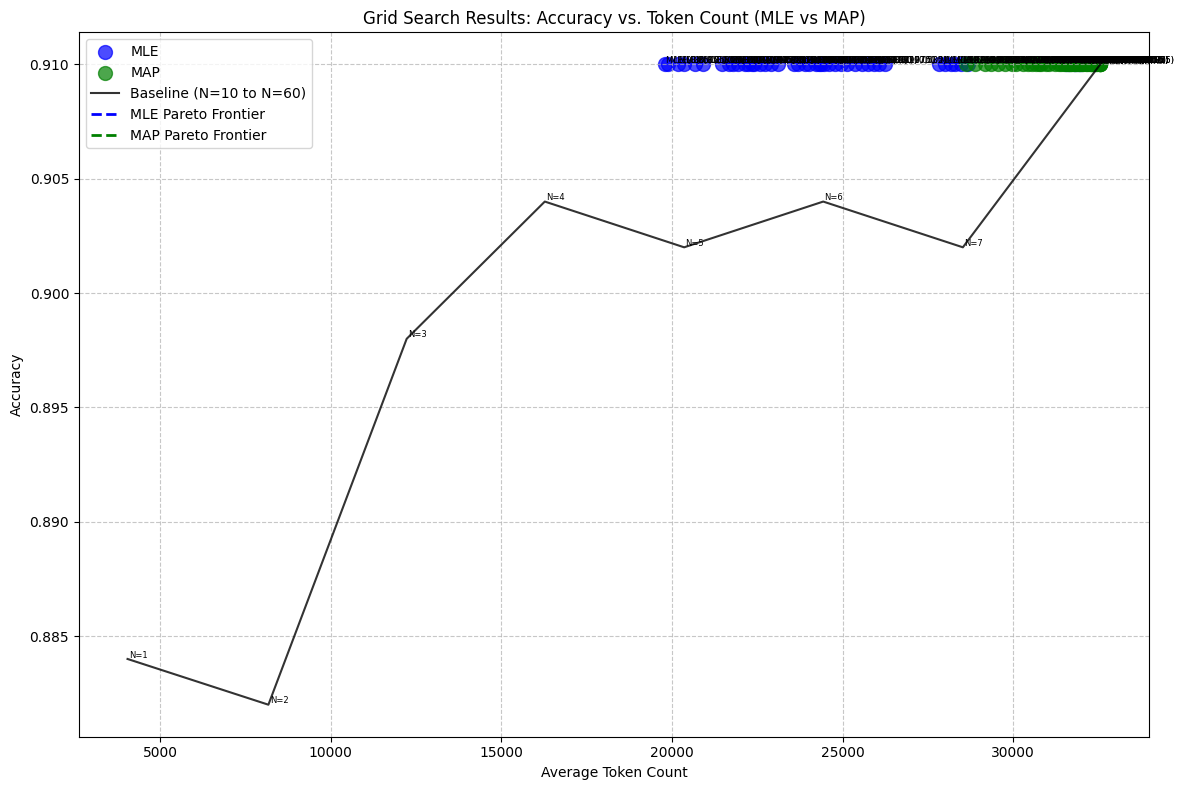


MLE Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9100, Avg Token Count: 19793.10

MAP Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9100, Avg Token Count: 28613.08


In [5]:
# Setting Panels
target_score_panel_values = [0.85, 0.9, 0.925, 0.95, 0.96, 0.97, 0.98, 0.99]
percentile_panel_values = [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
max_N_panel = 8
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

In [6]:
peek_number = 5

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.6015      0.1227    0.8456    0.1898    0.7292    0.1560    0.8022    0.0944
1         0.4543      0.0766    0.9738    0.0055    0.8187    0.1637    0.9713    0.0107
2         0.6429      0.1356    0.8315    0.1398    0.7690    0.1320    0.8473    0.1104
3         0.4399      0.0769    0.9836    0.0018    0.9564    0.0716    0.9783    0.0098
4         0.4217      0.1085    0.9744    0.0060    0.7120    0.2306    0.9715    0.0093
5         0.4133      0.0200    0.9764    0.0086    0.9420    0.0737    0.9770    0.0161
6         0.5740      0.1303    0.9835    0.0032    1.0599    0.0515    0.9844    0.0052
7         0.5280      0.0904    0.9720    0.0054    0.9738    0.0833    0.9708    0.0210
8         0.4172      0.0738    0.9122    0.0269    0.7846    0.1441    0.8754    0.0847
9         0.5581      0.1733    0.9767    0.0070    0.8907    0.1303    0.9790    0.0086
10        0.4970      0.1497    0.8732    0.0077    0.8723    0.0083    0.8458    0.0605
11        0.3311     

Target Score Panel: [0.85, 0.9, 0.925, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 16

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/8 [00:00<?, ?it/s]

MLE Min N Required [11, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 16, 5, 5, 16, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 8, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 7, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 14, 5, 5, 5, 16, 5, 16, 6, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 10, 16, 5, 6, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 7, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.85, Percentile: 0.01
MLE - Accuracy: 0.9060, Average Token Count: 37005.67
MLE Min N Required [9, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 16, 5, 5, 16, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 7, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 6, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 12, 5, 5, 5, 16, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 9, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 6, 5, 16, 5, 5, 5, 16, 5, 5, 5, 14, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 16, 5, 5

MLE - Target Score: 0.85, Percentile: 0.02
MLE - Accuracy: 0.9060, Average Token Count: 36427.53
MLE Min N Required [8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 6, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 10, 5, 5, 5, 16, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 14, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 8, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 14, 5, 5, 5, 12, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 5

MLE - Target Score: 0.85, Percentile: 0.035
MLE - Accuracy: 0.9060, Average Token Count: 35909.24
MLE Min N Required [7, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 9, 5, 5, 5, 16, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 13, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 7, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 13, 5, 5, 5, 11, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5

MLE - Target Score: 0.85, Percentile: 0.05
MLE - Accuracy: 0.9060, Average Token Count: 35453.24
MLE Min N Required [6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 8, 5, 5, 5, 16, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 11, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 6, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 11, 5, 5, 5, 9, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 

MLE - Target Score: 0.85, Percentile: 0.075
MLE - Accuracy: 0.9060, Average Token Count: 34974.68
MLE Min N Required [6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 7, 5, 5, 5, 16, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 15, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 10, 5, 5, 5, 8, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 

Target Score (MLE):  12%|█▎        | 1/8 [00:08<01:02,  8.94s/it]

MLE - Target Score: 0.85, Percentile: 0.1
MLE - Accuracy: 0.9040, Average Token Count: 34476.37


MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 11, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 8, 5, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 6, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 5, 13, 5, 5, 16, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 12, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9060, Average Token Count: 40390.50
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 16, 5, 5, 16, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 16, 5, 5, 5, 5, 9, 5, 16, 15, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 7, 5, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 5, 11, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 10, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9060, Average Token Count: 39812.15
MLE Min N Required [14, 5, 14, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 16, 5, 5, 16, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 16, 5, 5, 5, 5, 8, 5, 16, 13, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 16, 5, 16, 14, 16, 16, 5, 16, 5, 5, 6, 5, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 5, 10, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 9, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5,

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9060, Average Token Count: 39352.81
MLE Min N Required [12, 5, 12, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 16, 5, 5, 16, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 16, 5, 5, 5, 5, 7, 5, 16, 11, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 16, 5, 16, 12, 16, 16, 5, 16, 5, 5, 6, 5, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 5, 9, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 8, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5,

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9060, Average Token Count: 38957.09
MLE Min N Required [11, 5, 11, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 16, 5, 5, 16, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 16, 5, 5, 5, 5, 6, 5, 16, 10, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 15, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 16, 5, 16, 11, 14, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 14, 16, 5, 8, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 7, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5,

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9060, Average Token Count: 38592.39
MLE Min N Required [9, 5, 10, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 16, 5, 5, 16, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 16, 5, 5, 5, 5, 6, 5, 16, 9, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 14, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 16, 5, 16, 10, 12, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 12, 16, 5, 7, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 6, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 

Target Score (MLE):  25%|██▌       | 2/8 [00:18<00:55,  9.28s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9060, Average Token Count: 38173.29


MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 13, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 6, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 8, 5, 16, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 9, 5, 5, 16, 5, 16, 5, 16, 5, 5, 6, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5,

MLE - Target Score: 0.925, Percentile: 0.01
MLE - Accuracy: 0.9060, Average Token Count: 42261.14
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 11, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 13, 5, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 7, 5, 16, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 7, 5, 5, 16, 5, 15, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.925, Percentile: 0.02
MLE - Accuracy: 0.9060, Average Token Count: 41697.29
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 9, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 14, 5, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 12, 5, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 6, 5, 16, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 13, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.925, Percentile: 0.035
MLE - Accuracy: 0.9060, Average Token Count: 41258.03
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 9, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 12, 5, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 15, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 10, 5, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 5, 14, 5, 5, 16, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 12, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.925, Percentile: 0.05
MLE - Accuracy: 0.9060, Average Token Count: 40850.44
MLE Min N Required [15, 5, 16, 5, 5, 5, 5, 5, 7, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 11, 5, 16, 5, 5, 16, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 13, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 9, 5, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 5, 12, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 10, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1

MLE - Target Score: 0.925, Percentile: 0.075
MLE - Accuracy: 0.9060, Average Token Count: 40336.33
MLE Min N Required [13, 5, 14, 5, 5, 5, 5, 5, 7, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 16, 5, 5, 16, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 16, 5, 5, 5, 5, 12, 5, 16, 15, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 8, 5, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 5, 11, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 9, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16

Target Score (MLE):  38%|███▊      | 3/8 [00:28<00:48,  9.66s/it]

MLE - Target Score: 0.925, Percentile: 0.1
MLE - Accuracy: 0.9060, Average Token Count: 39901.89


MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 9, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 8, 8, 5, 11, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 9, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 12, 5, 16, 5, 5, 16, 5, 5, 8, 5, 5, 5, 7, 6, 15, 5, 16, 5, 5, 5, 5, 6, 16, 16, 5, 5, 16, 16, 9, 5, 16, 13, 11, 5, 16, 16, 5, 16, 6, 5, 16, 5, 5, 5, 5, 5, 14, 5, 5, 16, 9, 16, 5, 16, 5, 5, 11, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9060, Average Token Count: 45249.93
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 8, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 7, 7, 5, 9, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 7, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 10, 5, 16, 5, 5, 16, 5, 5, 7, 5, 5, 5, 6, 5, 13, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 7, 5, 16, 11, 10, 5, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 12, 5, 5, 16, 8, 16, 5, 16, 5, 5, 10, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9060, Average Token Count: 44551.45
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 7, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 6, 6, 5, 8, 16, 14, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 6, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 9, 5, 16, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 11, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 6, 5, 16, 10, 8, 5, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 10, 5, 5, 16, 7, 16, 5, 16, 5, 5, 8, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9060, Average Token Count: 43942.78
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 6, 5, 7, 16, 13, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 6, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 15, 16, 16, 16, 5, 5, 16, 5, 5, 8, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 6, 5, 16, 9, 8, 5, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 9, 5, 5, 16, 6, 16, 5, 16, 5, 5, 8, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9060, Average Token Count: 43571.76
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 14, 5, 5, 5, 5, 6, 16, 11, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 15, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 13, 16, 16, 16, 5, 5, 16, 5, 5, 7, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 7, 7, 5, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 8, 5, 5, 16, 5, 16, 5, 16, 5, 5, 7, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9060, Average Token Count: 43029.25
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 13, 5, 5, 5, 5, 6, 16, 10, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 14, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 11, 16, 16, 16, 5, 5, 16, 5, 5, 6, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 7, 6, 5, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 7, 5, 5, 16, 5, 15, 5, 16, 5, 5, 6, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

Target Score (MLE):  50%|█████     | 4/8 [00:39<00:40, 10.12s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9060, Average Token Count: 42669.73


MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 11, 5, 5, 9, 5, 5, 16, 5, 5, 5, 5, 16, 5, 14, 12, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 7, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 7, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 16, 9, 16, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 11, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 11, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 9, 14, 5, 16, 5, 5, 16, 5, 5, 9, 5, 5, 8, 9, 10, 16, 5, 16, 5, 5, 5, 5, 7, 16, 16, 5, 5, 16, 16, 12, 5, 16, 16, 16, 5, 16, 16, 5, 16, 9, 5, 16, 5, 5, 5, 5, 13, 16, 5, 5, 16, 12, 16, 5, 16, 5, 5, 16, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9080, Average Token Count: 47069.29
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 9, 5, 5, 8, 5, 5, 16, 5, 5, 5, 5, 16, 5, 12, 10, 5, 14, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 6, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 8, 16, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 9, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 9, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 7, 12, 5, 16, 5, 5, 16, 5, 5, 8, 5, 5, 6, 8, 8, 16, 5, 16, 5, 5, 5, 5, 6, 16, 16, 5, 5, 16, 16, 10, 5, 16, 16, 16, 5, 16, 16, 5, 16, 8, 5, 16, 5, 5, 5, 5, 11, 15, 5, 5, 16, 10, 16, 5, 16, 5, 5, 14, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9080, Average Token Count: 46448.96
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 8, 5, 5, 7, 5, 5, 16, 5, 5, 5, 5, 16, 5, 11, 9, 5, 12, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 7, 16, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 8, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 8, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 6, 11, 5, 16, 5, 5, 16, 5, 5, 7, 5, 5, 6, 7, 7, 16, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 9, 5, 16, 16, 16, 5, 16, 16, 5, 16, 7, 5, 16, 5, 5, 5, 5, 10, 13, 5, 5, 16, 9, 16, 5, 16, 5, 5, 12, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9080, Average Token Count: 45849.95
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 7, 5, 5, 6, 5, 5, 16, 5, 5, 5, 5, 16, 5, 9, 8, 5, 11, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 6, 16, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 7, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 6, 9, 5, 16, 5, 5, 16, 5, 5, 6, 5, 5, 5, 6, 6, 15, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 8, 5, 16, 16, 16, 5, 16, 16, 5, 16, 6, 5, 16, 5, 5, 5, 5, 9, 11, 5, 5, 16, 8, 16, 5, 16, 5, 5, 11, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9080, Average Token Count: 45335.88
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 8, 7, 5, 10, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 14, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 6, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 8, 5, 16, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 6, 13, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 7, 5, 16, 16, 16, 5, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 8, 10, 5, 5, 16, 7, 16, 5, 16, 5, 5, 9, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9080, Average Token Count: 44737.84
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 7, 6, 5, 9, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 13, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 6, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 7, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 6, 5, 16, 15, 14, 5, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 7, 9, 5, 5, 16, 6, 16, 5, 16, 5, 5, 8, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

Target Score (MLE):  62%|██████▎   | 5/8 [00:50<00:31, 10.51s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9080, Average Token Count: 44287.03


MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 8, 15, 5, 5, 16, 5, 8, 16, 5, 5, 7, 7, 16, 5, 16, 16, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 10, 5, 10, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 7, 5, 16, 5, 10, 7, 5, 16, 5, 16, 16, 16, 5, 5, 5, 6, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 16, 16, 16, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 14, 5, 16, 6, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 5, 16, 6, 6, 16, 5, 5, 12, 5, 5, 16, 12, 16, 16, 16, 16, 5, 5, 6, 5, 10, 16, 16, 5, 14, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 16, 5, 16, 5, 5, 16, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9080, Average Token Count: 49414.40
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 7, 12, 5, 5, 16, 5, 7, 16, 5, 5, 6, 6, 16, 5, 16, 16, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 9, 5, 9, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 6, 5, 16, 5, 8, 6, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 16, 16, 16, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 12, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 16, 5, 5, 11, 5, 5, 15, 10, 15, 16, 16, 16, 5, 5, 5, 5, 8, 16, 16, 5, 12, 16, 16, 15, 5, 16, 16, 16, 5, 16, 16, 5, 16, 14, 5, 16, 5, 5, 5, 5, 16, 16, 5, 5, 16, 14, 16, 5, 16, 5, 5, 16, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9080, Average Token Count: 48809.09
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 6, 11, 5, 5, 14, 5, 6, 16, 5, 5, 5, 5, 16, 5, 16, 14, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 7, 5, 8, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 6, 5, 16, 5, 7, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 16, 16, 16, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 10, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 16, 14, 5, 16, 5, 5, 16, 5, 5, 9, 5, 5, 13, 9, 13, 16, 15, 16, 5, 5, 5, 5, 7, 16, 16, 5, 10, 16, 16, 13, 5, 16, 16, 16, 5, 16, 16, 5, 16, 12, 5, 16, 5, 5, 5, 5, 16, 16, 5, 5, 16, 12, 16, 5, 16, 5, 5, 16, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9080, Average Token Count: 48239.21
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 10, 5, 5, 12, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 12, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 7, 5, 7, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 7, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 16, 15, 16, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 9, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 15, 12, 5, 16, 5, 5, 16, 5, 5, 8, 5, 5, 12, 8, 11, 16, 13, 16, 5, 5, 5, 5, 7, 16, 16, 5, 9, 16, 16, 12, 5, 16, 16, 16, 5, 16, 16, 5, 16, 11, 5, 16, 5, 5, 5, 5, 16, 15, 5, 5, 16, 11, 16, 5, 16, 5, 5, 16, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5,

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9080, Average Token Count: 47865.17
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 8, 5, 5, 11, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 11, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 6, 5, 6, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 6, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 16, 13, 16, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 8, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 13, 11, 5, 16, 5, 5, 16, 5, 5, 7, 5, 5, 10, 7, 10, 16, 12, 16, 5, 5, 5, 5, 6, 16, 16, 5, 8, 16, 16, 10, 5, 16, 16, 16, 5, 16, 16, 5, 16, 9, 5, 16, 5, 5, 5, 5, 16, 13, 5, 5, 16, 9, 16, 5, 16, 5, 5, 14, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9080, Average Token Count: 47349.37
MLE Min N Required [16, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 8, 5, 5, 10, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 10, 5, 14, 16, 16, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 16, 12, 16, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 7, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 12, 10, 5, 16, 5, 5, 16, 5, 5, 6, 5, 5, 9, 6, 9, 16, 11, 16, 5, 5, 5, 5, 5, 16, 16, 5, 7, 16, 16, 9, 5, 16, 16, 16, 5, 16, 16, 5, 16, 8, 5, 16, 5, 5, 5, 5, 16, 12, 5, 5, 16, 8, 16, 5, 16, 5, 5, 13, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5,

Target Score (MLE):  75%|███████▌  | 6/8 [01:02<00:22, 11.09s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9080, Average Token Count: 46810.44


MLE Min N Required [16, 16, 16, 5, 16, 13, 5, 16, 16, 14, 16, 16, 16, 16, 6, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 13, 16, 16, 12, 16, 16, 16, 16, 5, 5, 16, 16, 10, 16, 9, 6, 15, 5, 16, 16, 5, 16, 5, 5, 6, 8, 5, 16, 6, 16, 16, 6, 16, 8, 16, 12, 12, 16, 16, 16, 16, 16, 5, 16, 15, 16, 5, 5, 10, 16, 16, 16, 5, 5, 6, 5, 5, 5, 5, 12, 5, 5, 16, 16, 16, 16, 16, 5, 7, 5, 7, 16, 16, 16, 5, 5, 5, 8, 6, 16, 16, 5, 5, 5, 5, 5, 10, 16, 5, 6, 11, 5, 16, 5, 16, 5, 8, 8, 5, 5, 12, 5, 5, 16, 9, 16, 16, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 15, 16, 16, 16, 16, 5, 16, 5, 6, 16, 5, 5, 9, 16, 16, 5, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 5, 16, 9, 16, 16, 7, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 15, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 16, 7, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 5, 5, 16, 16, 16, 5, 16, 5, 5, 16, 16, 8, 5, 5, 16, 5, 5, 16, 5, 5, 14, 8, 5, 5, 12, 5, 16, 5, 16, 5, 5, 5, 5, 6, 14, 5, 5, 5, 5, 13, 5, 16, 5, 6, 16, 12

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9080, Average Token Count: 54361.65
MLE Min N Required [16, 16, 16, 5, 16, 11, 5, 16, 16, 12, 16, 16, 16, 16, 6, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 11, 16, 16, 10, 16, 16, 16, 16, 5, 5, 16, 16, 9, 16, 8, 6, 13, 5, 16, 16, 5, 16, 5, 5, 5, 7, 5, 16, 5, 16, 16, 5, 16, 7, 16, 11, 10, 16, 16, 16, 16, 16, 5, 16, 13, 16, 5, 5, 9, 16, 16, 16, 5, 5, 6, 5, 5, 5, 5, 10, 5, 5, 16, 16, 16, 16, 16, 5, 6, 5, 6, 16, 16, 16, 5, 5, 5, 7, 5, 16, 16, 5, 5, 5, 5, 5, 8, 16, 5, 5, 10, 5, 16, 5, 16, 5, 7, 7, 5, 5, 10, 5, 5, 16, 7, 16, 16, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 13, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 8, 14, 16, 5, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 5, 16, 8, 15, 16, 6, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 13, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 6, 16, 16, 5, 16, 16, 14, 16, 16, 15, 5, 5, 16, 16, 5, 5, 16, 16, 16, 5, 16, 5, 5, 16, 16, 7, 5, 5, 16, 5, 5, 1

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9080, Average Token Count: 53768.61
MLE Min N Required [16, 16, 16, 5, 16, 9, 5, 16, 16, 10, 16, 14, 16, 16, 5, 5, 16, 5, 15, 16, 14, 5, 16, 16, 16, 10, 16, 16, 9, 16, 16, 16, 16, 5, 5, 16, 16, 8, 16, 7, 5, 11, 5, 16, 14, 5, 16, 5, 5, 5, 6, 5, 16, 5, 16, 16, 5, 16, 6, 16, 9, 9, 16, 16, 16, 16, 16, 5, 16, 11, 16, 5, 5, 8, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 16, 16, 16, 16, 16, 5, 6, 5, 6, 16, 16, 16, 5, 5, 5, 6, 5, 16, 16, 5, 5, 5, 5, 5, 7, 13, 5, 5, 8, 5, 16, 5, 16, 5, 6, 6, 5, 5, 9, 5, 5, 16, 6, 16, 16, 14, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 15, 5, 16, 11, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 7, 12, 16, 5, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 5, 16, 7, 13, 16, 5, 16, 14, 5, 5, 16, 14, 16, 16, 16, 16, 5, 5, 14, 5, 11, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 5, 16, 16, 12, 16, 16, 13, 5, 5, 16, 16, 5, 5, 16, 16, 16, 5, 16, 5, 5, 16, 16, 6, 5, 5, 16, 5, 5, 16, 5, 5

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9080, Average Token Count: 53081.44
MLE Min N Required [16, 16, 16, 5, 16, 8, 5, 16, 16, 9, 16, 12, 16, 14, 5, 5, 16, 5, 14, 16, 13, 5, 16, 16, 16, 9, 16, 16, 8, 16, 16, 16, 16, 5, 5, 16, 16, 7, 16, 6, 5, 10, 5, 16, 12, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 16, 8, 8, 16, 16, 16, 16, 16, 5, 16, 10, 16, 5, 5, 7, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 15, 16, 16, 16, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 7, 12, 5, 5, 8, 5, 16, 5, 16, 5, 5, 6, 5, 5, 8, 5, 5, 16, 6, 14, 16, 12, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 14, 5, 16, 10, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 6, 11, 16, 5, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 5, 16, 6, 12, 16, 5, 16, 12, 5, 5, 16, 12, 16, 16, 16, 16, 5, 5, 13, 5, 10, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 5, 16, 16, 11, 16, 16, 12, 5, 5, 16, 16, 5, 5, 16, 16, 16, 5, 16, 5, 5, 16, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5,

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9080, Average Token Count: 52513.73
MLE Min N Required [16, 16, 16, 5, 16, 7, 5, 16, 16, 8, 16, 11, 16, 13, 5, 5, 16, 5, 12, 16, 11, 5, 16, 14, 16, 8, 16, 16, 7, 16, 16, 16, 16, 5, 5, 16, 15, 6, 16, 5, 5, 9, 5, 16, 11, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 16, 7, 7, 16, 16, 16, 16, 16, 5, 16, 9, 16, 5, 5, 6, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 13, 16, 16, 16, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 6, 11, 5, 5, 7, 5, 16, 5, 16, 5, 5, 5, 5, 5, 7, 5, 5, 16, 5, 12, 16, 11, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 12, 5, 16, 8, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 9, 16, 5, 14, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 5, 16, 5, 10, 16, 5, 15, 11, 5, 5, 16, 11, 16, 16, 16, 16, 5, 5, 11, 5, 9, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 5, 16, 16, 9, 16, 16, 10, 5, 5, 16, 16, 5, 5, 16, 14, 16, 5, 16, 5, 5, 16, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 8, 5, 

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9080, Average Token Count: 51904.43
MLE Min N Required [16, 16, 16, 5, 14, 7, 5, 16, 16, 7, 16, 10, 16, 11, 5, 5, 16, 5, 11, 16, 10, 5, 16, 12, 16, 7, 16, 16, 6, 16, 16, 16, 16, 5, 5, 16, 14, 5, 16, 5, 5, 8, 5, 16, 10, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 16, 6, 6, 16, 16, 16, 16, 16, 5, 16, 8, 16, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 12, 16, 16, 16, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 9, 5, 5, 6, 5, 16, 5, 16, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 11, 16, 10, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 11, 5, 16, 8, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 8, 16, 5, 13, 16, 16, 16, 16, 5, 5, 16, 5, 16, 14, 5, 16, 5, 9, 16, 5, 13, 10, 5, 5, 16, 9, 16, 16, 16, 16, 5, 5, 10, 5, 8, 16, 16, 5, 16, 16, 16, 15, 5, 16, 16, 16, 5, 16, 16, 5, 16, 16, 8, 16, 16, 9, 5, 5, 16, 16, 5, 5, 16, 13, 16, 5, 16, 5, 5, 16, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 7, 5, 5, 

Target Score (MLE):  88%|████████▊ | 7/8 [01:17<00:12, 12.24s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9080, Average Token Count: 51318.12


MLE Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 6, 5, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 12, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 5, 16, 6, 10, 16, 16, 16, 16, 16, 7, 16, 16, 16, 6, 16, 16, 16, 5, 11, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16,

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9080, Average Token Count: 63025.81
MLE Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 5, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 10, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 5, 16, 5, 8, 16, 16, 16, 16, 16, 6, 16, 16, 16, 5, 16, 16, 16, 5, 10, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 15, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 1

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9080, Average Token Count: 62704.99
MLE Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 9, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 5, 16, 5, 7, 16, 16, 16, 16, 16, 6, 16, 13, 16, 5, 16, 16, 16, 5, 8, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 15, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 13, 16, 16, 5, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16,

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9080, Average Token Count: 62336.50
MLE Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 8, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 16, 5, 6, 16, 16, 16, 16, 16, 5, 16, 12, 16, 5, 16, 16, 16, 5, 8, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 13, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 11, 16, 16, 5, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9080, Average Token Count: 62057.67
MLE Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 14, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 5, 16, 14, 16, 16, 7, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 6, 16, 16, 16, 16, 16, 5, 16, 10, 16, 5, 16, 16, 16, 5, 7, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 12, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 10, 16, 16, 5, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 8, 1

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9080, Average Token Count: 61654.16
MLE Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 7, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 13, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 5, 16, 13, 16, 16, 6, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 9, 16, 5, 16, 16, 16, 5, 6, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 10, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 9, 16, 16, 5, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 7, 16,

Target Score (MLE): 100%|██████████| 8/8 [01:37<00:00, 12.13s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9080, Average Token Count: 61351.23

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/8 [00:00<?, ?it/s]

MAP Min N Required [16, 12, 16, 5, 16, 5, 5, 5, 15, 7, 5, 16, 6, 6, 16, 16, 16, 5, 5, 5, 9, 5, 16, 5, 5, 16, 11, 5, 5, 5, 16, 5, 16, 11, 5, 16, 5, 5, 16, 6, 16, 5, 5, 5, 16, 16, 5, 5, 5, 5, 10, 16, 5, 16, 13, 5, 5, 16, 16, 5, 5, 5, 5, 8, 16, 16, 16, 16, 16, 10, 8, 5, 16, 5, 11, 5, 12, 16, 16, 5, 5, 5, 7, 5, 5, 16, 5, 5, 16, 5, 16, 5, 16, 5, 16, 12, 16, 16, 10, 7, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 14, 5, 7, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 14, 5, 10, 5, 16, 16, 16, 5, 16, 9, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 8, 8, 16, 5, 16, 9, 8, 16, 5, 16, 14, 5, 5, 5, 5, 5, 7, 14, 5, 5, 5, 16, 16, 16, 7, 6, 16, 16, 6, 11, 5, 16, 5, 5, 5, 5, 16, 16, 5, 5, 16, 9, 10, 12, 5, 16, 5, 5, 5, 16, 6, 16, 16, 11, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 9, 11, 10, 11, 16, 5, 5, 5, 5, 16, 10, 5, 16, 16, 5, 16, 11, 16, 11, 12, 5, 16, 14, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 5, 5, 16, 5, 8, 11, 16, 16, 16, 5, 9, 16, 5, 16, 16, 5, 6, 16, 5, 6, 5, 16, 16, 16, 16, 5

MAP - Target Score: 0.85, Percentile: 0.01
MAP - Accuracy: 0.9080, Average Token Count: 47301.17
MAP Min N Required [16, 10, 15, 5, 16, 5, 5, 5, 13, 6, 5, 16, 5, 5, 16, 16, 16, 5, 5, 5, 8, 5, 16, 5, 5, 16, 9, 5, 5, 5, 14, 5, 16, 10, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 16, 16, 5, 5, 5, 5, 9, 16, 5, 16, 11, 5, 5, 16, 16, 5, 5, 5, 5, 7, 16, 16, 16, 16, 16, 9, 7, 5, 16, 5, 9, 5, 10, 16, 16, 5, 5, 5, 6, 5, 5, 16, 5, 5, 16, 5, 16, 5, 16, 5, 16, 10, 16, 16, 9, 6, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 12, 5, 6, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 15, 5, 16, 5, 12, 5, 9, 5, 16, 16, 16, 5, 16, 8, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 7, 7, 16, 5, 16, 8, 7, 16, 5, 16, 12, 5, 5, 5, 5, 5, 6, 12, 5, 5, 5, 16, 16, 16, 6, 5, 16, 16, 5, 9, 5, 16, 5, 5, 5, 5, 16, 16, 5, 5, 16, 8, 9, 11, 5, 16, 5, 5, 5, 16, 5, 16, 16, 9, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 7, 9, 9, 9, 16, 5, 5, 5, 5, 16, 9, 5, 16, 16, 5, 14, 9, 16, 10, 10, 5, 16, 12, 13, 16, 16, 5, 16, 16, 5, 16, 15, 5, 14, 5, 5, 

MAP - Target Score: 0.85, Percentile: 0.02
MAP - Accuracy: 0.9060, Average Token Count: 45920.59
MAP Min N Required [16, 9, 13, 5, 16, 5, 5, 5, 11, 5, 5, 16, 5, 5, 16, 16, 16, 5, 5, 5, 7, 5, 16, 5, 5, 16, 8, 5, 5, 5, 12, 5, 16, 9, 5, 16, 5, 5, 16, 5, 14, 5, 5, 5, 16, 16, 5, 5, 5, 5, 8, 16, 5, 15, 9, 5, 5, 16, 16, 5, 5, 5, 5, 6, 16, 16, 14, 16, 16, 7, 6, 5, 16, 5, 8, 5, 9, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 16, 5, 16, 5, 15, 9, 16, 16, 7, 5, 5, 16, 16, 5, 5, 16, 16, 14, 16, 5, 5, 13, 10, 5, 5, 16, 5, 16, 14, 16, 5, 16, 16, 16, 15, 16, 5, 13, 5, 16, 5, 10, 5, 8, 5, 16, 16, 16, 5, 16, 7, 16, 16, 5, 15, 16, 16, 16, 16, 5, 16, 16, 14, 5, 6, 6, 16, 5, 16, 7, 6, 16, 5, 16, 11, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 16, 16, 16, 6, 5, 16, 16, 5, 8, 5, 16, 5, 5, 5, 5, 16, 16, 5, 5, 16, 7, 8, 9, 5, 16, 5, 5, 5, 16, 5, 16, 16, 8, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 6, 8, 8, 8, 16, 5, 5, 5, 5, 16, 8, 5, 16, 16, 5, 12, 8, 16, 8, 9, 5, 16, 11, 12, 16, 15, 5, 16, 16, 5, 16, 13, 5, 12, 5, 5, 16, 5, 6

MAP - Target Score: 0.85, Percentile: 0.035
MAP - Accuracy: 0.9060, Average Token Count: 44595.93
MAP Min N Required [15, 8, 11, 5, 15, 5, 5, 5, 10, 5, 5, 16, 5, 5, 16, 16, 16, 5, 5, 5, 6, 5, 15, 5, 5, 16, 7, 5, 5, 5, 11, 5, 16, 8, 5, 16, 5, 5, 14, 5, 13, 5, 5, 5, 16, 16, 5, 5, 5, 5, 7, 16, 5, 14, 9, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 16, 13, 16, 16, 7, 5, 5, 16, 5, 7, 5, 8, 14, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 16, 5, 16, 5, 14, 8, 16, 16, 7, 5, 5, 16, 14, 5, 5, 16, 14, 13, 15, 5, 5, 12, 9, 5, 5, 16, 5, 16, 12, 16, 5, 16, 16, 16, 13, 16, 5, 12, 5, 16, 5, 9, 5, 7, 5, 16, 16, 16, 5, 16, 6, 16, 16, 5, 13, 16, 16, 16, 16, 5, 16, 16, 13, 5, 5, 6, 16, 5, 16, 6, 5, 16, 5, 16, 9, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 14, 16, 16, 5, 5, 16, 16, 5, 7, 5, 16, 5, 5, 5, 5, 16, 16, 5, 5, 14, 6, 7, 8, 5, 16, 5, 5, 5, 16, 5, 16, 16, 7, 5, 16, 16, 5, 5, 16, 5, 5, 5, 15, 16, 6, 7, 7, 7, 16, 5, 5, 5, 5, 16, 7, 5, 16, 16, 5, 11, 7, 16, 7, 8, 5, 16, 10, 10, 16, 13, 5, 16, 16, 5, 16, 12, 5, 11, 5, 5, 16, 5, 5, 7

MAP - Target Score: 0.85, Percentile: 0.05
MAP - Accuracy: 0.9060, Average Token Count: 43442.50
MAP Min N Required [13, 7, 10, 5, 13, 5, 5, 5, 9, 5, 5, 16, 5, 5, 16, 16, 16, 5, 5, 5, 6, 5, 13, 5, 5, 16, 6, 5, 5, 5, 10, 5, 16, 7, 5, 16, 5, 5, 12, 5, 11, 5, 5, 5, 16, 16, 5, 5, 5, 5, 6, 16, 5, 12, 7, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 15, 11, 16, 16, 6, 5, 5, 16, 5, 6, 5, 7, 12, 15, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 16, 5, 16, 5, 12, 7, 16, 16, 6, 5, 5, 16, 13, 5, 5, 16, 12, 11, 13, 5, 5, 11, 8, 5, 5, 16, 5, 14, 11, 16, 5, 16, 16, 16, 11, 14, 5, 10, 5, 16, 5, 8, 5, 6, 5, 16, 16, 16, 5, 16, 5, 16, 16, 5, 12, 16, 16, 16, 16, 5, 16, 16, 11, 5, 5, 5, 16, 5, 16, 5, 5, 16, 5, 16, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 12, 16, 16, 5, 5, 16, 14, 5, 6, 5, 16, 5, 5, 5, 5, 16, 15, 5, 5, 13, 5, 6, 7, 5, 16, 5, 5, 5, 16, 5, 16, 16, 6, 5, 16, 16, 5, 5, 16, 5, 5, 5, 13, 16, 5, 6, 6, 6, 16, 5, 5, 5, 5, 16, 6, 5, 16, 16, 5, 9, 6, 16, 7, 7, 5, 16, 8, 9, 16, 11, 5, 16, 16, 5, 16, 10, 5, 10, 5, 5, 16, 5, 5, 6, 16,

MAP - Target Score: 0.85, Percentile: 0.075
MAP - Accuracy: 0.9060, Average Token Count: 42078.62
MAP Min N Required [12, 6, 9, 5, 11, 5, 5, 5, 8, 5, 5, 16, 5, 5, 15, 16, 16, 5, 5, 5, 5, 5, 12, 5, 5, 15, 6, 5, 5, 5, 9, 5, 16, 6, 5, 16, 5, 5, 11, 5, 10, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 5, 11, 7, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 13, 10, 16, 16, 5, 5, 5, 16, 5, 6, 5, 6, 11, 14, 5, 5, 5, 5, 5, 5, 14, 5, 5, 16, 5, 16, 5, 14, 5, 11, 6, 16, 16, 5, 5, 5, 16, 11, 5, 5, 16, 11, 10, 12, 5, 5, 9, 7, 5, 5, 16, 5, 12, 9, 16, 5, 16, 15, 16, 10, 13, 5, 9, 5, 16, 5, 7, 5, 5, 5, 16, 16, 16, 5, 16, 5, 16, 16, 5, 10, 16, 16, 16, 16, 5, 16, 16, 10, 5, 5, 5, 16, 5, 16, 5, 5, 16, 5, 16, 7, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 11, 16, 16, 5, 5, 16, 12, 5, 6, 5, 16, 5, 5, 5, 5, 16, 14, 5, 5, 11, 5, 5, 6, 5, 16, 5, 5, 5, 16, 5, 16, 16, 6, 5, 16, 16, 5, 5, 16, 5, 5, 5, 12, 16, 5, 6, 5, 6, 16, 5, 5, 5, 5, 14, 5, 5, 16, 16, 5, 8, 6, 16, 6, 6, 5, 14, 7, 8, 16, 10, 5, 16, 14, 5, 16, 9, 5, 9, 5, 5, 16, 5, 5, 6, 16, 10, 8

Target Score (MAP):  12%|█▎        | 1/8 [00:13<01:34, 13.49s/it]

MAP - Target Score: 0.85, Percentile: 0.1
MAP - Accuracy: 0.9060, Average Token Count: 40916.48


MAP Min N Required [16, 16, 16, 5, 16, 5, 5, 5, 16, 12, 16, 16, 11, 11, 16, 16, 16, 5, 5, 5, 16, 5, 16, 5, 7, 16, 16, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 6, 16, 11, 16, 9, 5, 5, 16, 16, 5, 5, 9, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 8, 14, 14, 16, 16, 16, 16, 16, 16, 14, 5, 16, 5, 16, 9, 16, 16, 16, 5, 5, 5, 12, 5, 5, 16, 8, 5, 16, 5, 16, 5, 16, 7, 16, 16, 16, 16, 16, 13, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 16, 5, 12, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 9, 16, 5, 16, 5, 16, 16, 16, 5, 16, 15, 16, 16, 9, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 15, 15, 16, 5, 16, 16, 16, 16, 5, 16, 16, 5, 11, 6, 5, 5, 12, 16, 5, 5, 5, 16, 16, 16, 13, 10, 16, 16, 11, 16, 5, 16, 5, 9, 8, 5, 16, 16, 10, 5, 16, 16, 16, 16, 5, 16, 7, 5, 6, 16, 12, 16, 16, 16, 5, 16, 16, 5, 8, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 6, 5, 5, 16, 16, 5, 16, 16, 6, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 16, 16, 8, 16, 16, 10, 16, 6, 5, 16, 5, 15, 16, 16, 16, 16, 6, 16, 16, 5, 16, 16, 5, 10, 

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9080, Average Token Count: 52882.71
MAP Min N Required [16, 16, 16, 5, 16, 5, 5, 5, 16, 10, 16, 16, 9, 9, 16, 16, 16, 5, 5, 5, 15, 5, 16, 5, 6, 16, 16, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 16, 9, 16, 8, 5, 5, 16, 16, 5, 5, 8, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 7, 12, 12, 16, 16, 16, 16, 16, 14, 12, 5, 16, 5, 16, 7, 16, 16, 16, 5, 5, 5, 11, 5, 5, 16, 7, 5, 16, 5, 16, 5, 16, 6, 16, 16, 16, 16, 16, 11, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 16, 5, 10, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 7, 16, 5, 16, 5, 16, 16, 16, 5, 16, 13, 16, 16, 8, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 12, 13, 16, 5, 16, 16, 16, 16, 5, 16, 16, 5, 9, 5, 5, 5, 10, 16, 5, 5, 5, 16, 16, 16, 11, 8, 16, 16, 9, 16, 5, 16, 5, 8, 7, 5, 16, 16, 8, 5, 16, 14, 16, 16, 5, 16, 6, 5, 5, 16, 10, 16, 16, 15, 5, 16, 16, 5, 7, 16, 5, 5, 5, 16, 16, 14, 16, 16, 16, 16, 5, 5, 5, 5, 16, 16, 5, 16, 16, 5, 16, 15, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9080, Average Token Count: 51748.34
MAP Min N Required [16, 15, 16, 5, 16, 5, 5, 5, 16, 9, 16, 16, 8, 8, 16, 16, 16, 5, 5, 5, 13, 5, 16, 5, 5, 16, 14, 5, 5, 5, 16, 5, 16, 15, 5, 16, 5, 5, 16, 8, 16, 7, 5, 5, 16, 16, 5, 5, 7, 5, 14, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 6, 11, 10, 16, 16, 16, 16, 16, 12, 10, 5, 16, 5, 14, 6, 16, 16, 16, 5, 5, 5, 9, 5, 5, 16, 6, 5, 16, 5, 16, 5, 16, 5, 16, 16, 16, 16, 16, 10, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 16, 5, 9, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 6, 16, 5, 13, 5, 16, 16, 16, 5, 16, 11, 16, 16, 7, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 11, 11, 16, 5, 16, 16, 16, 16, 5, 16, 16, 5, 8, 5, 5, 5, 9, 16, 5, 5, 5, 16, 16, 16, 10, 7, 16, 16, 8, 14, 5, 16, 5, 7, 6, 5, 16, 16, 7, 5, 16, 12, 15, 16, 5, 16, 5, 5, 5, 16, 9, 16, 16, 13, 5, 16, 16, 5, 6, 16, 5, 5, 5, 16, 16, 12, 16, 13, 13, 16, 5, 5, 5, 5, 16, 15, 5, 16, 16, 5, 16, 13, 16, 14, 15, 5, 16, 16, 16, 16, 16, 5, 16, 1

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9080, Average Token Count: 50575.97
MAP Min N Required [16, 14, 16, 5, 16, 5, 5, 5, 16, 8, 16, 16, 7, 7, 16, 16, 16, 5, 5, 5, 12, 5, 16, 5, 5, 16, 13, 5, 5, 5, 16, 5, 16, 14, 5, 16, 5, 5, 16, 7, 16, 6, 5, 5, 16, 16, 5, 5, 6, 5, 12, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 10, 9, 16, 16, 16, 16, 16, 11, 9, 5, 16, 5, 12, 6, 15, 16, 16, 5, 5, 5, 8, 5, 5, 16, 5, 5, 16, 5, 16, 5, 16, 5, 16, 14, 16, 16, 16, 9, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 16, 5, 8, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 6, 16, 5, 12, 5, 16, 16, 16, 5, 16, 10, 16, 16, 6, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 10, 10, 16, 5, 16, 16, 16, 16, 5, 16, 16, 5, 7, 5, 5, 5, 8, 16, 5, 5, 5, 16, 16, 16, 9, 7, 16, 16, 7, 13, 5, 16, 5, 6, 6, 5, 16, 16, 6, 5, 16, 11, 13, 16, 5, 16, 5, 5, 5, 16, 8, 16, 16, 11, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 11, 16, 12, 12, 16, 5, 5, 5, 5, 16, 13, 5, 16, 16, 5, 16, 12, 16, 13, 13, 5, 16, 16, 16, 16, 16, 5, 16, 16, 

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9080, Average Token Count: 49749.06
MAP Min N Required [16, 12, 16, 5, 16, 5, 5, 5, 16, 7, 16, 16, 6, 6, 16, 16, 16, 5, 5, 5, 10, 5, 16, 5, 5, 16, 11, 5, 5, 5, 16, 5, 16, 12, 5, 16, 5, 5, 16, 6, 16, 5, 5, 5, 16, 16, 5, 5, 5, 5, 11, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 8, 8, 16, 16, 16, 16, 16, 9, 8, 5, 16, 5, 11, 5, 13, 16, 16, 5, 5, 5, 7, 5, 5, 16, 5, 5, 16, 5, 16, 5, 16, 5, 16, 12, 16, 16, 16, 8, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 14, 5, 7, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 14, 5, 10, 5, 16, 16, 16, 5, 16, 9, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 8, 8, 16, 5, 16, 16, 16, 16, 5, 16, 14, 5, 6, 5, 5, 5, 7, 16, 5, 5, 5, 16, 16, 16, 8, 6, 16, 16, 6, 11, 5, 16, 5, 5, 5, 5, 16, 16, 6, 5, 16, 10, 12, 14, 5, 16, 5, 5, 5, 16, 7, 16, 16, 10, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 9, 14, 10, 10, 16, 5, 5, 5, 5, 16, 12, 5, 16, 16, 5, 16, 10, 16, 11, 12, 5, 16, 14, 15, 16, 16, 5, 16, 16, 5, 16, 

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9080, Average Token Count: 48589.36
MAP Min N Required [16, 11, 16, 5, 16, 5, 5, 5, 14, 6, 16, 16, 6, 6, 16, 16, 16, 5, 5, 5, 9, 5, 16, 5, 5, 16, 10, 5, 5, 5, 16, 5, 16, 11, 5, 16, 5, 5, 16, 6, 16, 5, 5, 5, 16, 16, 5, 5, 5, 5, 10, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 7, 7, 16, 16, 16, 16, 16, 8, 7, 5, 16, 5, 10, 5, 12, 16, 16, 5, 5, 5, 6, 5, 5, 16, 5, 5, 16, 5, 16, 5, 16, 5, 16, 11, 16, 16, 16, 7, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 12, 5, 6, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 12, 5, 9, 5, 16, 16, 16, 5, 16, 8, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 8, 8, 16, 5, 16, 15, 16, 16, 5, 16, 13, 5, 6, 5, 5, 5, 6, 16, 5, 5, 5, 16, 16, 16, 7, 5, 16, 16, 6, 10, 5, 16, 5, 5, 5, 5, 16, 16, 5, 5, 16, 9, 10, 13, 5, 16, 5, 5, 5, 16, 6, 16, 16, 9, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 8, 12, 9, 9, 16, 5, 5, 5, 5, 16, 10, 5, 16, 16, 5, 16, 9, 16, 10, 10, 5, 16, 12, 14, 16, 16, 5, 16, 16, 5, 16, 16, 5,

Target Score (MAP):  25%|██▌       | 2/8 [00:29<01:28, 14.71s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9060, Average Token Count: 47788.72


MAP Min N Required [16, 16, 16, 6, 16, 8, 5, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 5, 16, 5, 13, 16, 16, 6, 5, 7, 16, 5, 16, 16, 5, 16, 5, 9, 16, 16, 16, 14, 5, 5, 16, 16, 5, 5, 13, 5, 16, 16, 5, 16, 16, 6, 5, 16, 16, 5, 5, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 5, 5, 16, 12, 5, 16, 5, 16, 5, 16, 10, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 6, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 13, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 5, 16, 8, 5, 5, 16, 16, 5, 5, 8, 16, 16, 16, 16, 14, 16, 16, 16, 16, 6, 16, 5, 13, 16, 5, 16, 16, 15, 5, 16, 16, 16, 16, 5, 16, 11, 5, 12, 16, 16, 16, 16, 16, 5, 16, 16, 8, 12, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 8, 5, 6, 16, 16, 5, 16, 16, 10, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 5, 16, 16, 12, 16, 16, 16, 16, 9, 5, 16, 5, 16, 16, 16, 16, 16, 9, 16, 16, 

MAP - Target Score: 0.925, Percentile: 0.01
MAP - Accuracy: 0.9080, Average Token Count: 55697.16
MAP Min N Required [16, 16, 16, 5, 16, 7, 5, 5, 16, 14, 16, 16, 13, 14, 16, 16, 16, 5, 5, 15, 16, 5, 16, 5, 12, 16, 16, 5, 5, 6, 16, 5, 16, 16, 5, 16, 5, 8, 16, 13, 16, 12, 5, 5, 16, 16, 5, 5, 11, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 5, 5, 16, 10, 5, 16, 5, 16, 5, 16, 8, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 16, 5, 15, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 11, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 5, 16, 7, 5, 5, 15, 16, 5, 5, 7, 16, 16, 16, 16, 12, 16, 16, 14, 16, 5, 16, 5, 11, 16, 5, 16, 16, 13, 5, 16, 16, 16, 16, 5, 16, 9, 5, 10, 16, 16, 16, 16, 16, 5, 16, 16, 7, 11, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 7, 5, 6, 16, 16, 5, 16, 16, 9, 16, 16, 16, 16, 16, 11, 

MAP - Target Score: 0.925, Percentile: 0.02
MAP - Accuracy: 0.9080, Average Token Count: 54830.70
MAP Min N Required [16, 16, 16, 5, 16, 6, 5, 5, 16, 12, 16, 16, 11, 12, 16, 16, 16, 5, 5, 13, 16, 5, 16, 5, 10, 16, 16, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 7, 16, 11, 16, 10, 5, 5, 16, 16, 5, 5, 10, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 10, 16, 16, 16, 16, 16, 16, 16, 16, 15, 5, 16, 5, 16, 15, 16, 16, 16, 5, 5, 5, 13, 5, 5, 16, 9, 5, 16, 5, 16, 5, 16, 7, 16, 16, 16, 16, 16, 15, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 16, 5, 13, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 9, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 5, 15, 6, 5, 5, 13, 16, 5, 5, 6, 16, 16, 16, 14, 11, 16, 16, 12, 16, 5, 16, 5, 10, 14, 5, 16, 16, 11, 5, 16, 16, 16, 16, 5, 16, 8, 5, 9, 16, 14, 16, 16, 16, 5, 16, 16, 6, 9, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 6, 5, 5, 16, 16, 5, 16, 16, 8, 16, 16, 16, 16, 16, 10, 16, 

MAP - Target Score: 0.925, Percentile: 0.035
MAP - Accuracy: 0.9080, Average Token Count: 53990.34
MAP Min N Required [16, 16, 16, 5, 16, 5, 5, 5, 16, 11, 16, 16, 10, 11, 16, 16, 16, 5, 5, 12, 16, 5, 16, 5, 9, 16, 16, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 6, 16, 10, 16, 9, 5, 5, 16, 16, 5, 5, 9, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 9, 16, 14, 16, 16, 16, 16, 16, 15, 13, 5, 16, 5, 16, 14, 16, 16, 16, 5, 5, 5, 12, 5, 5, 16, 8, 5, 16, 5, 16, 5, 16, 7, 16, 16, 16, 16, 16, 13, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 16, 5, 12, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 9, 16, 5, 16, 5, 16, 16, 16, 5, 16, 15, 16, 16, 9, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 14, 14, 16, 5, 16, 16, 16, 16, 5, 16, 16, 5, 13, 6, 5, 5, 12, 16, 5, 5, 5, 16, 16, 16, 13, 9, 16, 16, 11, 16, 5, 16, 5, 9, 13, 5, 16, 16, 10, 5, 16, 16, 16, 16, 5, 16, 7, 5, 8, 16, 13, 16, 16, 16, 5, 16, 16, 5, 8, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 6, 5, 5, 16, 16, 5, 16, 16, 7, 16, 16, 16, 16, 16, 9, 16, 16, 16,

MAP - Target Score: 0.925, Percentile: 0.05
MAP - Accuracy: 0.9080, Average Token Count: 53276.31
MAP Min N Required [16, 16, 16, 5, 16, 5, 5, 5, 16, 10, 16, 16, 9, 9, 16, 16, 16, 5, 5, 10, 15, 5, 16, 5, 8, 16, 16, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 16, 9, 16, 8, 5, 5, 16, 16, 5, 5, 8, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 8, 16, 12, 16, 16, 16, 16, 16, 13, 12, 5, 16, 5, 15, 12, 16, 16, 16, 5, 5, 5, 10, 5, 5, 16, 7, 5, 16, 5, 16, 5, 16, 6, 16, 16, 16, 16, 16, 11, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 16, 5, 10, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 7, 16, 5, 15, 5, 16, 16, 16, 5, 16, 13, 16, 16, 8, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 12, 12, 16, 5, 16, 16, 16, 16, 5, 16, 16, 5, 11, 5, 5, 5, 10, 16, 5, 5, 5, 16, 16, 16, 11, 8, 16, 16, 9, 16, 5, 16, 5, 8, 11, 5, 16, 16, 9, 5, 16, 14, 16, 16, 5, 16, 6, 5, 7, 16, 11, 16, 16, 14, 5, 16, 16, 5, 7, 16, 5, 5, 5, 16, 16, 14, 16, 15, 15, 16, 5, 5, 5, 5, 16, 16, 5, 16, 16, 6, 16, 15, 16, 16, 16, 8, 16, 16, 16, 16, 1

MAP - Target Score: 0.925, Percentile: 0.075
MAP - Accuracy: 0.9080, Average Token Count: 52151.90
MAP Min N Required [16, 15, 16, 5, 16, 5, 5, 5, 16, 9, 16, 16, 8, 8, 16, 16, 16, 5, 5, 9, 13, 5, 16, 5, 7, 16, 14, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 16, 8, 16, 7, 5, 5, 16, 16, 5, 5, 7, 5, 14, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 7, 16, 11, 16, 16, 16, 16, 16, 12, 10, 5, 16, 5, 14, 11, 16, 16, 16, 5, 5, 5, 9, 5, 5, 16, 6, 5, 16, 5, 16, 5, 16, 5, 16, 16, 16, 16, 16, 10, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 16, 5, 9, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 7, 16, 5, 13, 5, 16, 16, 16, 5, 16, 11, 16, 16, 7, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 11, 11, 16, 5, 16, 16, 16, 16, 5, 16, 16, 5, 10, 5, 5, 5, 9, 16, 5, 5, 5, 16, 16, 16, 10, 7, 16, 16, 8, 14, 5, 16, 5, 7, 10, 5, 16, 16, 8, 5, 16, 12, 16, 16, 5, 16, 6, 5, 6, 16, 10, 16, 16, 12, 5, 16, 16, 5, 6, 16, 5, 5, 5, 16, 16, 12, 16, 13, 13, 16, 5, 5, 5, 5, 16, 16, 5, 16, 16, 5, 16, 13, 16, 14, 15, 7, 16, 16, 16, 16, 16, 5

Target Score (MAP):  38%|███▊      | 3/8 [00:45<01:18, 15.61s/it]

MAP - Target Score: 0.925, Percentile: 0.1
MAP - Accuracy: 0.9080, Average Token Count: 51286.39


MAP Min N Required [16, 16, 16, 11, 16, 13, 5, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 5, 16, 16, 5, 16, 5, 16, 16, 16, 14, 5, 16, 16, 16, 16, 16, 5, 16, 6, 16, 16, 16, 16, 16, 8, 7, 16, 16, 5, 5, 16, 5, 16, 16, 8, 16, 16, 10, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 5, 8, 16, 16, 6, 16, 5, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 11, 16, 16, 16, 16, 5, 10, 16, 16, 6, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 11, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 7, 16, 16, 16, 7, 16, 16, 16, 16, 11, 16, 16, 8, 16, 14, 5, 6, 16, 16, 5, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 15, 7, 5, 16, 16, 16, 16, 16, 16, 16, 5, 14, 5, 11, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 15, 5, 16, 6, 16, 16, 16,

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9080, Average Token Count: 58709.89
MAP Min N Required [16, 16, 16, 9, 16, 11, 5, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 5, 16, 16, 5, 16, 5, 16, 16, 16, 12, 5, 14, 16, 16, 16, 16, 5, 16, 5, 14, 16, 16, 16, 16, 7, 6, 16, 16, 5, 5, 16, 5, 16, 16, 7, 16, 16, 9, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 5, 7, 16, 16, 5, 16, 5, 16, 5, 16, 14, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 9, 16, 16, 16, 16, 5, 9, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 9, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 6, 16, 16, 16, 6, 16, 16, 16, 16, 9, 16, 16, 7, 16, 12, 5, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 15, 16, 16, 13, 6, 5, 16, 16, 16, 16, 16, 16, 16, 5, 12, 5, 9, 16, 16, 7, 16, 16, 16, 16, 16, 16, 

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9080, Average Token Count: 58039.65
MAP Min N Required [16, 16, 16, 8, 16, 10, 5, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 5, 16, 5, 16, 16, 16, 10, 5, 12, 16, 16, 16, 16, 5, 16, 5, 12, 16, 16, 16, 16, 6, 6, 16, 16, 5, 5, 16, 5, 16, 16, 6, 16, 16, 8, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 5, 6, 16, 14, 5, 16, 5, 16, 5, 16, 12, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 8, 16, 16, 16, 16, 5, 8, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 8, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 8, 16, 16, 6, 16, 10, 5, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 14, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 13, 16, 16, 11, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 10, 5, 8, 16, 16, 6, 16, 16, 14, 16, 16, 16, 

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9080, Average Token Count: 57420.96
MAP Min N Required [16, 16, 16, 7, 16, 9, 5, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 5, 16, 5, 16, 16, 16, 9, 5, 11, 16, 14, 16, 16, 5, 16, 5, 11, 16, 16, 16, 16, 6, 5, 16, 16, 5, 5, 14, 5, 16, 16, 5, 16, 16, 7, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 5, 6, 16, 13, 5, 16, 5, 16, 5, 16, 11, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 7, 16, 16, 16, 16, 5, 7, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 7, 16, 14, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 7, 16, 16, 6, 16, 9, 5, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 5, 15, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 13, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 11, 14, 16, 10, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 9, 5, 7, 16, 16, 5, 16, 16, 13, 16, 16, 16, 16,

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9080, Average Token Count: 56889.76
MAP Min N Required [16, 16, 16, 6, 16, 8, 5, 6, 16, 16, 16, 16, 15, 16, 16, 16, 16, 5, 5, 16, 16, 5, 16, 5, 16, 16, 16, 8, 5, 9, 16, 13, 16, 16, 5, 16, 5, 9, 16, 15, 16, 14, 5, 5, 16, 16, 5, 5, 12, 5, 16, 16, 5, 16, 16, 6, 5, 16, 16, 5, 5, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 5, 5, 16, 11, 5, 16, 5, 16, 5, 16, 9, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 6, 16, 16, 16, 16, 5, 6, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 6, 16, 12, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 5, 16, 8, 5, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 14, 16, 16, 15, 16, 6, 16, 5, 13, 16, 5, 16, 16, 15, 5, 16, 16, 16, 16, 5, 16, 11, 5, 15, 16, 16, 16, 16, 16, 5, 16, 16, 10, 12, 16, 9, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 8, 5, 6, 16, 16, 5, 16, 16, 11, 16, 16, 16, 16, 16, 

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9080, Average Token Count: 56106.29
MAP Min N Required [16, 16, 16, 6, 16, 7, 5, 5, 16, 14, 16, 16, 13, 14, 16, 16, 16, 5, 5, 16, 16, 5, 16, 5, 16, 16, 16, 7, 5, 8, 16, 11, 16, 16, 5, 16, 5, 8, 16, 13, 16, 12, 5, 5, 16, 16, 5, 5, 11, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 15, 5, 5, 16, 10, 5, 16, 5, 16, 5, 16, 8, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 6, 16, 16, 16, 16, 5, 5, 16, 16, 5, 15, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 6, 16, 11, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 5, 16, 7, 5, 5, 15, 16, 5, 5, 16, 16, 16, 16, 16, 12, 16, 16, 14, 16, 5, 16, 5, 12, 16, 5, 16, 16, 13, 5, 16, 16, 16, 16, 5, 16, 10, 5, 13, 16, 16, 16, 16, 16, 5, 16, 16, 9, 11, 16, 8, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 7, 5, 6, 16, 16, 5, 16, 16, 10, 16, 16, 16, 16, 16, 

Target Score (MAP):  50%|█████     | 4/8 [01:03<01:06, 16.54s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9080, Average Token Count: 55494.36


MAP Min N Required [16, 16, 16, 14, 16, 16, 5, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 5, 16, 16, 5, 16, 6, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 6, 16, 7, 16, 16, 16, 16, 16, 11, 10, 16, 16, 5, 6, 16, 5, 16, 16, 12, 16, 16, 14, 5, 16, 16, 6, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 7, 6, 16, 5, 11, 16, 16, 8, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 6, 16, 16, 16, 16, 16, 5, 14, 16, 16, 8, 16, 16, 5, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 6, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 9, 16, 16, 16, 11, 16, 16, 16, 16, 15, 16, 16, 11, 16, 16, 5, 8, 16, 16, 5, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 6, 16, 16, 6, 16, 16, 16, 5, 16, 16, 16, 16, 7, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 10, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 14, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16,

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9080, Average Token Count: 60027.36
MAP Min N Required [16, 16, 16, 12, 16, 15, 5, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 5, 16, 16, 5, 16, 5, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 16, 6, 16, 16, 16, 16, 16, 9, 8, 16, 16, 5, 5, 16, 5, 16, 16, 10, 16, 16, 12, 5, 16, 16, 5, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 6, 5, 16, 5, 9, 16, 16, 7, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 6, 16, 16, 16, 16, 16, 5, 12, 16, 16, 7, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 15, 16, 16, 16, 5, 16, 6, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 8, 16, 16, 16, 10, 16, 16, 16, 16, 13, 16, 16, 10, 16, 16, 5, 7, 16, 16, 5, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 8, 5, 16, 16, 16, 16, 16, 16, 16, 5, 15, 5, 12, 16, 16, 9, 16, 16, 16,

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9080, Average Token Count: 59496.29
MAP Min N Required [16, 16, 16, 10, 16, 13, 5, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 5, 16, 16, 5, 16, 5, 16, 16, 16, 15, 6, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 8, 7, 16, 16, 5, 5, 16, 5, 16, 16, 9, 16, 16, 10, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 5, 8, 16, 16, 6, 16, 7, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 5, 10, 16, 16, 6, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 13, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 7, 16, 16, 16, 8, 16, 16, 16, 16, 11, 16, 16, 8, 16, 14, 5, 6, 16, 16, 5, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 7, 5, 16, 16, 16, 16, 16, 16, 16, 5, 13, 5, 10, 16, 16, 8, 16, 16, 16, 16

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9080, Average Token Count: 58963.40
MAP Min N Required [16, 16, 16, 9, 16, 12, 5, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 5, 16, 16, 5, 16, 5, 16, 16, 16, 14, 5, 16, 16, 16, 16, 16, 5, 16, 5, 14, 16, 16, 16, 16, 7, 6, 16, 16, 5, 5, 16, 5, 16, 16, 8, 16, 16, 9, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 5, 7, 16, 16, 5, 16, 7, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 15, 16, 16, 16, 16, 5, 9, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 12, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 6, 16, 16, 16, 7, 16, 16, 16, 16, 10, 16, 16, 8, 16, 12, 5, 6, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 6, 5, 16, 16, 16, 16, 16, 16, 16, 5, 12, 5, 9, 16, 16, 7, 16, 16, 16, 16, 16,

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9080, Average Token Count: 58513.80
MAP Min N Required [16, 16, 16, 8, 16, 10, 5, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 5, 16, 5, 16, 16, 16, 12, 5, 15, 16, 16, 16, 16, 5, 16, 5, 12, 16, 16, 16, 16, 6, 6, 16, 16, 5, 5, 16, 5, 16, 16, 7, 16, 16, 8, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 5, 6, 16, 15, 5, 16, 6, 16, 15, 16, 12, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 13, 16, 16, 16, 16, 5, 8, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 10, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 7, 16, 16, 16, 16, 8, 16, 16, 7, 16, 11, 5, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 14, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 15, 16, 16, 16, 6, 5, 16, 16, 16, 16, 16, 16, 16, 5, 10, 5, 8, 16, 16, 6, 16, 16, 15, 16, 16, 1

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9080, Average Token Count: 57998.11
MAP Min N Required [16, 16, 16, 7, 16, 9, 5, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 5, 16, 5, 16, 16, 16, 11, 5, 13, 16, 16, 16, 16, 5, 16, 5, 11, 16, 16, 16, 16, 6, 5, 16, 16, 5, 5, 14, 5, 16, 16, 6, 16, 16, 7, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 5, 6, 16, 13, 5, 16, 5, 16, 13, 16, 11, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 11, 16, 16, 16, 16, 5, 7, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 9, 16, 14, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 6, 16, 16, 16, 16, 8, 16, 16, 6, 16, 9, 5, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 5, 15, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 13, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 13, 14, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 9, 5, 7, 16, 16, 6, 16, 16, 14, 16, 16, 16, 

Target Score (MAP):  62%|██████▎   | 5/8 [01:22<00:51, 17.32s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9080, Average Token Count: 57423.59


MAP Min N Required [16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 5, 16, 16, 5, 16, 9, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 8, 16, 10, 16, 16, 16, 16, 16, 15, 13, 16, 16, 8, 10, 16, 8, 16, 16, 16, 16, 16, 16, 5, 16, 16, 9, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 8, 10, 8, 16, 5, 15, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 9, 16, 16, 16, 16, 16, 5, 16, 16, 16, 11, 16, 16, 5, 16, 16, 16, 10, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 11, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 11, 16, 16, 5, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 11, 16, 16, 5, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 15, 7, 16, 16, 16, 16, 16, 16, 16, 5, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 1

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9080, Average Token Count: 61656.75
MAP Min N Required [16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 5, 16, 16, 5, 16, 7, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 6, 16, 9, 16, 16, 16, 16, 16, 13, 11, 16, 16, 6, 9, 16, 7, 16, 16, 16, 16, 16, 16, 5, 16, 16, 8, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 7, 8, 7, 16, 5, 13, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 8, 16, 16, 16, 16, 16, 5, 16, 16, 16, 9, 16, 16, 5, 16, 16, 16, 8, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 10, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 5, 10, 16, 16, 5, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 13, 16, 16, 16, 5, 16, 16, 16, 16, 9, 16, 16, 5, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 13, 6, 16, 16, 16, 16, 16, 16, 16, 5, 16, 7, 16, 16, 16, 

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9080, Average Token Count: 61168.23
MAP Min N Required [16, 16, 16, 15, 16, 16, 5, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 5, 16, 16, 5, 16, 6, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 6, 16, 8, 16, 16, 16, 16, 16, 11, 10, 16, 16, 6, 7, 16, 6, 16, 16, 14, 16, 16, 14, 5, 16, 16, 7, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 6, 7, 6, 16, 5, 11, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 7, 16, 16, 16, 16, 16, 5, 14, 16, 16, 8, 16, 16, 5, 16, 16, 16, 7, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 8, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 9, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 5, 8, 16, 16, 5, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 7, 16, 16, 12, 16, 16, 16, 5, 16, 16, 16, 16, 8, 16, 16, 5, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 11, 6, 16, 16, 16, 16, 16, 16, 16, 5, 16, 6, 14, 16, 16, 12, 1

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9080, Average Token Count: 60649.50
MAP Min N Required [16, 16, 16, 13, 16, 16, 5, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 5, 16, 16, 5, 16, 6, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 5, 16, 7, 16, 16, 16, 16, 16, 10, 9, 16, 16, 5, 7, 16, 6, 16, 16, 13, 16, 16, 12, 5, 16, 16, 6, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 7, 5, 16, 5, 10, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 6, 16, 16, 16, 16, 16, 5, 13, 16, 16, 7, 16, 16, 5, 16, 16, 16, 7, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 7, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 9, 16, 16, 16, 13, 16, 16, 16, 16, 14, 16, 16, 11, 16, 16, 5, 7, 16, 16, 5, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 6, 16, 16, 10, 16, 16, 16, 5, 16, 16, 16, 16, 7, 16, 16, 5, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 10, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 13, 16, 16, 11, 1

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9080, Average Token Count: 60242.44
MAP Min N Required [16, 16, 16, 12, 16, 14, 5, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 5, 16, 16, 5, 16, 5, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 5, 16, 6, 16, 16, 16, 16, 16, 9, 8, 16, 16, 5, 6, 16, 5, 16, 16, 11, 16, 16, 11, 5, 16, 16, 5, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 6, 5, 16, 5, 9, 16, 16, 6, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 5, 11, 16, 16, 6, 16, 16, 5, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 7, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 7, 16, 16, 16, 11, 16, 16, 16, 16, 12, 16, 16, 10, 16, 15, 5, 7, 16, 16, 5, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 6, 16, 16, 9, 16, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 9, 5, 16, 16, 16, 16, 16, 16, 16, 5, 14, 5, 11, 16, 16, 9, 16, 16, 16

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9080, Average Token Count: 59746.61
MAP Min N Required [16, 16, 16, 10, 16, 13, 5, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 5, 16, 16, 5, 16, 5, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 5, 16, 5, 15, 16, 16, 16, 16, 8, 7, 16, 16, 5, 5, 16, 5, 16, 16, 10, 16, 16, 10, 5, 16, 16, 5, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 5, 8, 16, 16, 6, 16, 13, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 5, 10, 16, 16, 6, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 6, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 7, 16, 16, 16, 10, 16, 16, 16, 16, 11, 16, 16, 9, 16, 13, 5, 6, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 5, 16, 16, 8, 16, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 8, 5, 16, 16, 16, 16, 16, 16, 16, 5, 13, 5, 10, 16, 16, 8, 16, 16, 16,

Target Score (MAP):  75%|███████▌  | 6/8 [01:41<00:35, 17.93s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9080, Average Token Count: 59261.93


MAP Min N Required [16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 5, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 7, 16, 16, 16, 16, 16, 14, 15, 12, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 14, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 5, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9080, Average Token Count: 63316.15
MAP Min N Required [16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 5, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 6, 16, 16, 16, 16, 16, 12, 13, 11, 16, 6, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 12, 16, 16, 16, 16, 16, 5, 16, 16, 16, 15, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 15, 16, 16, 5, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 15, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 5, 

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9080, Average Token Count: 62967.75
MAP Min N Required [16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 8, 16, 16, 5, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 12, 16, 16, 16, 16, 16, 16, 15, 16, 16, 10, 15, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 12, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 6, 16, 16, 16, 16, 16, 10, 11, 9, 16, 5, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 10, 16, 16, 16, 16, 16, 5, 16, 16, 16, 13, 16, 16, 5, 16, 16, 16, 15, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 13, 16, 16, 5, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 13, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 5, 16,

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9080, Average Token Count: 62560.62
MAP Min N Required [16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 7, 16, 16, 5, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 11, 16, 16, 16, 16, 16, 16, 14, 16, 16, 9, 14, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 11, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 9, 10, 8, 16, 5, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 9, 16, 16, 16, 16, 16, 5, 16, 16, 16, 11, 16, 16, 5, 16, 16, 16, 14, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 13, 16, 15, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 12, 16, 16, 5, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 11, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 5, 16, 9,

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9080, Average Token Count: 62282.75
MAP Min N Required [16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 6, 16, 16, 5, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 9, 16, 16, 16, 16, 16, 14, 12, 16, 16, 8, 12, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 10, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 8, 9, 7, 16, 5, 14, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 8, 16, 16, 16, 16, 16, 5, 16, 16, 16, 10, 16, 16, 5, 16, 16, 16, 12, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 12, 16, 13, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 10, 16, 16, 5, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 10, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 7, 16, 16, 16, 16, 16, 16, 16, 5, 16, 8, 16

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9080, Average Token Count: 61910.56
MAP Min N Required [16, 16, 16, 16, 16, 16, 5, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 6, 16, 16, 5, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 8, 16, 16, 16, 16, 16, 12, 11, 16, 16, 7, 11, 16, 14, 16, 16, 16, 16, 16, 15, 5, 16, 16, 9, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 7, 8, 6, 16, 5, 12, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 7, 16, 16, 16, 16, 16, 5, 15, 16, 16, 9, 16, 16, 5, 16, 16, 16, 11, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 10, 16, 12, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 5, 9, 16, 16, 5, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 9, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 6, 16, 16, 16, 16, 16, 16, 16, 5, 16, 7, 16, 16, 

Target Score (MAP):  88%|████████▊ | 7/8 [02:01<00:18, 18.67s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9080, Average Token Count: 61555.47


MAP Min N Required [16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9080, Average Token Count: 64636.69
MAP Min N Required [16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9080, Average Token Count: 64510.41
MAP Min N Required [16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9080, Average Token Count: 64352.25
MAP Min N Required [16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9080, Average Token Count: 64224.45
MAP Min N Required [16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 9, 16, 16, 16, 16, 16, 16, 16, 15, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16,

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9080, Average Token Count: 64030.82
MAP Min N Required [16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 5, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 8, 16, 16, 16, 16, 16, 16, 16, 14, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16,

Target Score (MAP): 100%|██████████| 8/8 [02:23<00:00, 17.91s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9080, Average Token Count: 63857.78


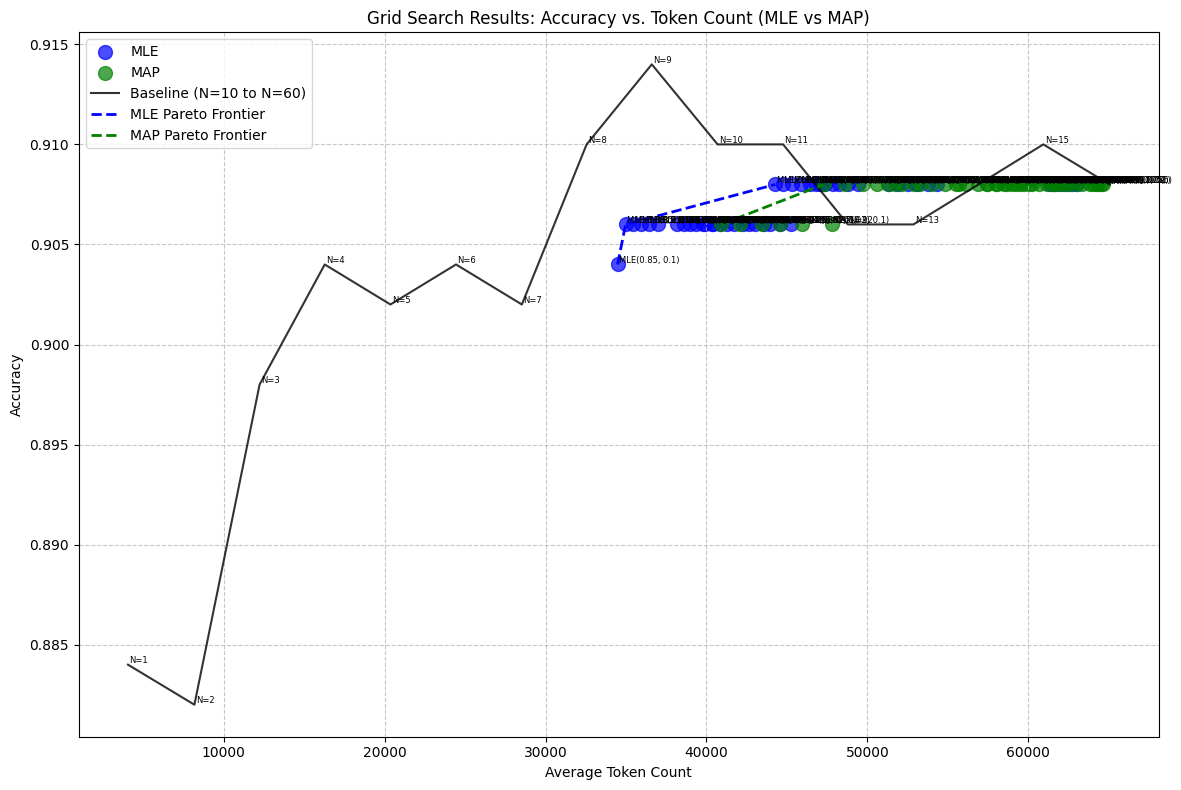


MLE Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9040, Avg Token Count: 34476.37
Target Score: 0.85, Percentile: 0.075, Accuracy: 0.9060, Avg Token Count: 34974.68
Target Score: 0.96, Percentile: 0.1, Accuracy: 0.9080, Avg Token Count: 44287.03

MAP Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9060, Avg Token Count: 40916.48
Target Score: 0.85, Percentile: 0.01, Accuracy: 0.9080, Avg Token Count: 47301.17


In [7]:
max_N_panel = 16
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

In [8]:
peek_number = 10

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.6015      0.1227    0.7904    0.1117    0.7671    0.1110    0.8022    0.0944
1         0.4543      0.0766    0.9709    0.0089    0.9169    0.1174    0.9713    0.0107
2         0.6429      0.1356    0.8115    0.1171    0.7874    0.1150    0.8473    0.1104
3         0.4399      0.0769    0.9817    0.0027    0.8768    0.1498    0.9783    0.0098
4         0.4217      0.1085    0.9746    0.0059    0.7769    0.1791    0.9715    0.0093
5         0.4133      0.0200    0.9767    0.0073    0.7071    0.2125    0.9770    0.0161
6         0.5740      0.1303    0.9835    0.0030    0.9090    0.0636    0.9844    0.0052
7         0.5280      0.0904    0.9689    0.0095    0.9260    0.0350    0.9708    0.0210
8         0.4172      0.0738    0.9439    0.1267    0.8017    0.1023    0.8754    0.0847
9         0.5581      0.1733    0.9785    0.0065    0.7973    0.1936    0.9790    0.0086
10        0.4970      0.1497    0.8484    0.0561    0.7438    0.1008    0.8458    0.0605
11        0.3311     

Target Score Panel: [0.85, 0.9, 0.925, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 32

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/8 [00:00<?, ?it/s]

MLE Min N Required [15, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 23, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 21, 32, 32, 10, 30, 32, 15, 10, 10, 10, 32, 10, 32, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 19, 10, 10, 10, 12, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 24, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 12, 

MLE - Target Score: 0.85, Percentile: 0.01
MLE - Accuracy: 0.9180, Average Token Count: 67828.69
MLE Min N Required [13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 18, 32, 32, 10, 26, 32, 13, 10, 10, 10, 32, 10, 32, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 11, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 21, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10,

MLE - Target Score: 0.85, Percentile: 0.02
MLE - Accuracy: 0.9180, Average Token Count: 66765.65
MLE Min N Required [11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 15, 32, 32, 10, 22, 32, 11, 10, 10, 10, 32, 10, 32, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 18, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10,

MLE - Target Score: 0.85, Percentile: 0.035
MLE - Accuracy: 0.9180, Average Token Count: 65847.08
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 14, 32, 32, 10, 20, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 16, 10, 10, 32, 10, 10, 10, 10, 30, 10, 10

MLE - Target Score: 0.85, Percentile: 0.05
MLE - Accuracy: 0.9180, Average Token Count: 65223.53
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 12, 32, 32, 10, 17, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 14, 10, 10, 32, 10, 10, 10, 10, 26, 10, 10,

MLE - Target Score: 0.85, Percentile: 0.075
MLE - Accuracy: 0.9180, Average Token Count: 64500.98
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 11, 32, 32, 10, 15, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 12, 10, 10, 32, 10, 10, 10, 10, 24, 10, 10

Target Score (MLE):  12%|█▎        | 1/8 [00:11<01:17, 11.03s/it]

MLE - Target Score: 0.85, Percentile: 0.1
MLE - Accuracy: 0.9180, Average Token Count: 63956.44


MLE Min N Required [32, 10, 24, 10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 32, 10, 10, 32, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 32, 10, 10, 10, 10, 15, 10, 32, 22, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 28, 30, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 16, 32, 10, 23, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 32, 

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9160, Average Token Count: 76873.19
MLE Min N Required [27, 10, 20, 10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 32, 10, 10, 32, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 13, 10, 32, 19, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 30, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 24, 26, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 28, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 14, 32, 10, 20, 

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9160, Average Token Count: 75620.33
MLE Min N Required [23, 10, 17, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 28, 10, 10, 32, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 11, 10, 32, 16, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 26, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 28, 32, 32, 10, 32, 32, 31, 10, 10, 10, 32, 10, 32, 20, 22, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 24, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 12, 32, 10, 17, 

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9160, Average Token Count: 74274.97
MLE Min N Required [21, 10, 16, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 32, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 14, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 23, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 25, 32, 32, 10, 32, 32, 27, 10, 10, 10, 32, 10, 32, 18, 20, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 22, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 11, 32, 10, 15,

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9160, Average Token Count: 73388.11
MLE Min N Required [18, 10, 14, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 12, 31, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 20, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 22, 32, 32, 10, 32, 32, 24, 10, 10, 10, 32, 10, 32, 16, 17, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 19, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 13, 

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9160, Average Token Count: 72313.82
MLE Min N Required [16, 10, 12, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 11, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 18, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 20, 32, 32, 10, 32, 32, 21, 10, 10, 10, 32, 10, 32, 14, 15, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 17, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 12,

Target Score (MLE):  25%|██▌       | 2/8 [00:23<01:12, 12.01s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9160, Average Token Count: 71482.71


MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 11, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 32, 10, 10, 32, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 32, 10, 10, 10, 10, 25, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 19, 10, 10, 10, 10, 32, 10, 10, 10, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 24, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 12, 10, 32, 10, 10, 10, 32, 10, 10, 10, 32, 

MLE - Target Score: 0.925, Percentile: 0.01
MLE - Accuracy: 0.9160, Average Token Count: 80234.19
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 32, 10, 10, 32, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 32, 10, 10, 10, 10, 22, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 16, 10, 10, 10, 10, 32, 10, 10, 10, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 21, 32, 10, 32

MLE - Target Score: 0.925, Percentile: 0.02
MLE - Accuracy: 0.9160, Average Token Count: 79397.47
MLE Min N Required [32, 10, 27, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 32, 10, 10, 32, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 32, 10, 10, 10, 10, 19, 10, 32, 30, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 14, 10, 10, 10, 10, 32, 10, 10, 10, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 18, 32, 10, 31

MLE - Target Score: 0.925, Percentile: 0.035
MLE - Accuracy: 0.9160, Average Token Count: 78595.26
MLE Min N Required [32, 10, 24, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 32, 10, 10, 32, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 32, 10, 10, 10, 10, 17, 10, 32, 27, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 12, 10, 10, 10, 10, 32, 10, 10, 10, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 16, 32, 10, 2

MLE - Target Score: 0.925, Percentile: 0.05
MLE - Accuracy: 0.9160, Average Token Count: 78013.42
MLE Min N Required [29, 10, 21, 10, 10, 10, 10, 10, 10, 10, 31, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 32, 10, 10, 32, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 32, 10, 10, 10, 10, 15, 10, 32, 23, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 11, 10, 10, 10, 10, 32, 10, 10, 10, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 14, 32, 10, 24

MLE - Target Score: 0.925, Percentile: 0.075
MLE - Accuracy: 0.9160, Average Token Count: 77142.02
MLE Min N Required [26, 10, 19, 10, 10, 10, 10, 10, 10, 10, 28, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 32, 10, 10, 32, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 13, 10, 32, 21, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 29, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 30, 32, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 31, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 12, 32, 10, 2

Target Score (MLE):  38%|███▊      | 3/8 [00:37<01:03, 12.73s/it]

MLE - Target Score: 0.925, Percentile: 0.1
MLE - Accuracy: 0.9160, Average Token Count: 76245.12


MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 18, 10, 32, 10, 10, 12, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 15, 10, 12, 10, 10, 10, 32, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 14, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 20, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 12, 10, 32, 10, 10, 10, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 19, 10, 32, 10, 10, 10, 32, 10, 10, 10, 32, 

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9160, Average Token Count: 84613.05
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 16, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 13, 10, 11, 10, 10, 10, 32, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 12, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 17, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 23, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 11, 10, 32, 10, 10, 10, 32, 32, 10, 32,

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9160, Average Token Count: 83643.16
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 14, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 30, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 30, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 15, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 31, 32, 10, 32,

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9160, Average Token Count: 82813.95
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 12, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 32, 10, 10, 32, 10, 10, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 13, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 27, 32, 10, 32

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9160, Average Token Count: 82181.13
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 11, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 32, 10, 10, 32, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 32, 10, 10, 10, 10, 28, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 29, 10, 10, 10, 10, 32, 10, 10, 12, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 24, 32, 10, 32,

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9160, Average Token Count: 81327.75
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 32, 10, 10, 32, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 32, 10, 10, 10, 10, 25, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 26, 10, 10, 10, 10, 32, 10, 10, 10, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 21, 32, 10, 32

Target Score (MLE):  50%|█████     | 4/8 [00:51<00:53, 13.49s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9160, Average Token Count: 80614.15


MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 24, 10, 32, 10, 10, 15, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 22, 10, 30, 10, 10, 13, 32, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 12, 32, 11, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 18, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 11, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 10, 11, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 18, 10, 32, 15, 20, 10, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 13, 10, 10, 32, 10, 24, 10, 32, 10, 10, 10, 32, 10, 10, 10, 32, 

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9180, Average Token Count: 87216.02
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 20, 10, 32, 10, 10, 12, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 19, 10, 26, 10, 10, 11, 32, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 15, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 15, 10, 32, 13, 17, 10, 32, 32, 10, 32,

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9160, Average Token Count: 86071.99
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 17, 10, 32, 10, 10, 11, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 16, 10, 22, 10, 10, 10, 32, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 13, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 29, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 13, 10, 32, 11, 15, 10, 32, 32, 10, 32,

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9160, Average Token Count: 85125.26
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 16, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 15, 10, 20, 10, 10, 10, 32, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 12, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 26, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 29, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 12, 10, 32, 10, 13, 10, 32, 32, 10, 32

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9160, Average Token Count: 84522.35
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 14, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 13, 10, 17, 10, 10, 10, 31, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 22, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 12, 10, 31, 32, 10, 32,

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9160, Average Token Count: 83685.42
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 12, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 11, 10, 15, 10, 10, 10, 28, 10, 32, 10, 10, 32, 10, 10, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 20, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 23, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 28, 32, 10, 32

Target Score (MLE):  62%|██████▎   | 5/8 [01:07<00:42, 14.19s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9160, Average Token Count: 83034.95


MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 20, 10, 10, 11, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 11, 10, 23, 32, 23, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 23, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 32, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 32, 31, 32, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 15, 10, 32, 12, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 19, 15, 10, 32, 10, 12, 32, 10, 10, 10, 10, 10, 10, 12, 13, 27, 13, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 27, 10, 32, 32, 32, 10, 32, 32, 10, 32, 14, 10, 32, 10, 10, 10, 10, 23, 17, 10, 10, 32, 12, 32, 10, 32, 10, 10, 10, 32, 10, 10, 10, 32, 

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9180, Average Token Count: 91658.44
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 28, 10, 32, 10, 10, 17, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 31, 10, 32, 10, 10, 20, 32, 19, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 20, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 32, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 26, 32, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 13, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 16, 12, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 11, 23, 11, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 23, 10, 32, 28, 32, 10, 32, 32, 10, 32,

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9180, Average Token Count: 90042.37
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 24, 10, 32, 10, 10, 14, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 26, 10, 32, 10, 10, 17, 32, 17, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 17, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 32, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 23, 32, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 11, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 14, 11, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 20, 10, 32, 24, 32, 10, 32, 32, 10, 32,

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9180, Average Token Count: 88771.05
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 21, 10, 32, 10, 10, 13, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 24, 10, 32, 10, 10, 15, 32, 15, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 15, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 32, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 20, 32, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 13, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 18, 10, 32, 22, 32, 10, 32, 32, 10, 32

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9180, Average Token Count: 87928.13
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 19, 10, 32, 10, 10, 11, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 20, 10, 32, 10, 10, 13, 32, 13, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 13, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 32, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 18, 32, 30, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 11, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 15, 10, 32, 19, 32, 10, 32, 32, 10, 32,

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9180, Average Token Count: 86967.13
MLE Min N Required [32, 10, 32, 10, 10, 10, 10, 10, 17, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 18, 10, 32, 10, 10, 12, 32, 12, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 12, 10, 10, 32, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 32, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 16, 32, 26, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 10, 32, 10, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 14, 10, 32, 17, 32, 10, 32, 32, 10, 32

Target Score (MLE):  75%|███████▌  | 6/8 [01:24<00:30, 15.10s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9160, Average Token Count: 86242.96


MLE Min N Required [32, 31, 32, 10, 26, 13, 10, 32, 32, 10, 32, 10, 32, 30, 10, 10, 26, 10, 14, 32, 26, 10, 32, 32, 32, 10, 32, 19, 17, 32, 32, 32, 32, 10, 10, 32, 15, 10, 32, 10, 10, 10, 10, 15, 13, 10, 21, 10, 10, 10, 10, 10, 32, 10, 32, 19, 10, 32, 10, 32, 15, 18, 32, 18, 32, 32, 32, 10, 22, 12, 24, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 28, 32, 32, 32, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 11, 10, 10, 13, 10, 32, 32, 15, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 22, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 13, 24, 32, 10, 11, 32, 32, 32, 32, 10, 10, 32, 10, 32, 22, 10, 32, 10, 23, 32, 12, 32, 12, 10, 10, 31, 18, 29, 32, 23, 32, 10, 10, 21, 10, 11, 32, 32, 10, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32, 32, 13, 32, 25, 12, 10, 10, 32, 26, 10, 10, 32, 18, 32, 10, 32, 10, 10, 12, 32, 10, 10, 10, 32, 

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9180, Average Token Count: 100298.01
MLE Min N Required [32, 26, 32, 10, 22, 11, 10, 32, 32, 10, 32, 10, 32, 25, 10, 10, 22, 10, 12, 32, 22, 10, 32, 32, 32, 10, 32, 16, 14, 32, 32, 32, 32, 10, 10, 32, 12, 10, 32, 10, 10, 10, 10, 13, 11, 10, 18, 10, 10, 10, 10, 10, 31, 10, 32, 16, 10, 32, 10, 32, 12, 16, 32, 15, 32, 32, 32, 10, 18, 10, 20, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 32, 32, 32, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 32, 28, 13, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 19, 10, 32, 29, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 11, 20, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 32, 18, 10, 32, 10, 20, 32, 10, 29, 10, 10, 10, 26, 15, 25, 32, 20, 32, 10, 10, 18, 10, 10, 32, 32, 10, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9180, Average Token Count: 98316.37
MLE Min N Required [32, 22, 32, 10, 19, 10, 10, 29, 32, 10, 32, 10, 32, 22, 10, 10, 19, 10, 10, 32, 19, 10, 32, 28, 32, 10, 32, 14, 12, 32, 32, 32, 32, 10, 10, 32, 11, 10, 32, 10, 10, 10, 10, 11, 10, 10, 15, 10, 10, 10, 10, 10, 27, 10, 32, 14, 10, 32, 10, 32, 11, 14, 32, 13, 32, 32, 32, 10, 16, 10, 17, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 32, 32, 32, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 30, 24, 11, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 16, 10, 32, 25, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 18, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 32, 16, 10, 32, 10, 17, 32, 10, 25, 10, 10, 10, 23, 13, 21, 32, 17, 32, 10, 10, 15, 10, 10, 32, 32, 10, 28, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32,

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9180, Average Token Count: 96412.24
MLE Min N Required [32, 20, 32, 10, 17, 10, 10, 26, 32, 10, 32, 10, 32, 19, 10, 10, 17, 10, 10, 32, 17, 10, 32, 25, 32, 10, 32, 12, 11, 30, 32, 32, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 24, 10, 32, 12, 10, 32, 10, 32, 10, 12, 32, 12, 32, 32, 32, 10, 14, 10, 16, 10, 10, 10, 32, 32, 30, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 32, 32, 32, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 21, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 14, 10, 32, 22, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 16, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 32, 14, 10, 32, 10, 15, 32, 10, 23, 10, 10, 10, 20, 12, 19, 32, 15, 32, 10, 10, 14, 10, 10, 32, 32, 10, 25, 32, 32, 31, 10, 32, 32, 32, 10, 32, 32, 10, 32

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9180, Average Token Count: 95104.13
MLE Min N Required [32, 17, 32, 10, 15, 10, 10, 22, 29, 10, 32, 10, 32, 17, 10, 10, 15, 10, 10, 32, 15, 10, 32, 22, 32, 10, 32, 11, 10, 26, 32, 32, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 21, 10, 32, 11, 10, 32, 10, 32, 10, 11, 32, 10, 32, 32, 32, 10, 12, 10, 13, 10, 10, 10, 32, 32, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 32, 32, 32, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 19, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 12, 10, 32, 19, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 14, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 32, 12, 10, 32, 10, 13, 32, 10, 20, 10, 10, 10, 18, 10, 17, 28, 13, 32, 10, 10, 12, 10, 10, 32, 32, 10, 22, 32, 32, 27, 10, 32, 32, 32, 10, 32, 32, 10, 32,

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9180, Average Token Count: 93375.17
MLE Min N Required [32, 16, 32, 10, 13, 10, 10, 20, 26, 10, 32, 10, 30, 15, 10, 10, 13, 10, 10, 32, 13, 10, 32, 19, 32, 10, 32, 10, 10, 23, 32, 31, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 18, 10, 32, 10, 10, 32, 10, 32, 10, 10, 32, 10, 32, 32, 32, 10, 11, 10, 12, 10, 10, 10, 32, 32, 23, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 32, 32, 32, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 17, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 11, 10, 32, 17, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 10, 10, 12, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 29, 11, 10, 32, 10, 12, 32, 10, 17, 10, 10, 10, 16, 10, 15, 25, 12, 32, 10, 10, 11, 10, 10, 32, 32, 10, 19, 32, 32, 24, 10, 32, 32, 32, 10, 32, 32, 10, 32

Target Score (MLE):  88%|████████▊ | 7/8 [01:44<00:16, 16.83s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9180, Average Token Count: 91995.98


MLE Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 13, 32, 19, 16, 32, 25, 32, 32, 32, 32, 32, 25, 22, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 17, 32, 32, 32, 32, 10, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 10, 10, 10, 31, 32, 32, 32, 12, 28, 32, 29, 32, 16, 32, 14, 32, 15, 32, 10, 32, 12, 10, 32, 32, 32, 32, 32, 10, 29, 15, 32, 10, 32, 32, 28, 10, 11, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 16, 32, 14, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 12, 32, 32, 10, 32, 25, 32, 32, 32, 32, 23, 32, 27, 32, 32, 32, 32, 32, 32, 32, 32, 32, 27, 24, 32, 32, 26, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 25, 23, 19, 32, 32, 22, 32, 32, 32, 32, 10, 32, 10, 32, 25, 32, 32, 20, 10, 32, 

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9180, Average Token Count: 121372.39
MLE Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 11, 32, 16, 13, 27, 21, 32, 32, 32, 32, 32, 21, 19, 32, 32, 32, 32, 32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 14, 32, 32, 32, 32, 10, 10, 32, 10, 32, 32, 27, 32, 32, 32, 32, 32, 32, 32, 32, 30, 31, 32, 32, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 10, 10, 10, 27, 32, 32, 32, 11, 24, 32, 25, 32, 14, 32, 12, 32, 13, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 10, 24, 13, 32, 10, 32, 32, 24, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 13, 32, 12, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 11, 32, 32, 10, 32, 21, 32, 32, 32, 32, 19, 30, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 20, 32, 32, 22, 32, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 10, 32

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9180, Average Token Count: 119845.07
MLE Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 10, 27, 14, 12, 23, 18, 32, 32, 32, 32, 32, 18, 16, 32, 32, 32, 32, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 31, 32, 10, 12, 32, 32, 32, 32, 10, 10, 32, 10, 32, 32, 23, 32, 30, 32, 32, 32, 32, 32, 32, 26, 27, 32, 32, 32, 32, 32, 30, 10, 10, 32, 32, 32, 32, 10, 10, 10, 24, 29, 32, 32, 10, 21, 32, 22, 32, 12, 32, 11, 32, 11, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 10, 21, 11, 32, 10, 32, 32, 21, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 12, 32, 11, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 29, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 31, 10, 32, 18, 32, 32, 32, 32, 17, 26, 20, 32, 27, 32, 32, 32, 32, 32, 32, 32, 20, 17, 32, 32, 19, 32, 32, 32, 32, 10, 32, 32, 32, 31, 32, 32, 10, 32

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9180, Average Token Count: 118260.48
MLE Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 10, 24, 13, 10, 21, 17, 32, 32, 32, 32, 32, 16, 14, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32, 10, 11, 32, 32, 32, 32, 10, 10, 32, 10, 32, 32, 21, 32, 27, 32, 32, 32, 32, 32, 32, 23, 24, 32, 32, 32, 32, 32, 27, 10, 10, 32, 32, 32, 32, 10, 10, 10, 21, 26, 32, 32, 10, 19, 32, 20, 32, 10, 32, 10, 32, 10, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 10, 19, 10, 32, 10, 32, 32, 18, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 28, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 26, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 28, 10, 32, 16, 32, 32, 32, 32, 15, 23, 18, 32, 25, 32, 32, 32, 32, 32, 32, 32, 18, 16, 32, 32, 17, 32, 32, 32, 32, 10, 32, 32, 32, 28, 32, 32, 10, 3

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9180, Average Token Count: 117020.28
MLE Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 10, 32, 32, 32, 32, 32, 25, 32, 32, 32, 32, 32, 18, 32, 32, 32, 32, 32, 10, 21, 11, 10, 18, 14, 32, 32, 32, 32, 32, 14, 13, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 32, 32, 18, 32, 23, 32, 32, 32, 32, 32, 32, 20, 21, 32, 29, 32, 32, 32, 24, 10, 10, 32, 32, 32, 32, 10, 10, 10, 19, 23, 32, 32, 10, 16, 32, 18, 32, 10, 32, 10, 29, 10, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 10, 16, 10, 32, 10, 32, 32, 16, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 24, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 22, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 24, 10, 32, 14, 32, 32, 32, 32, 13, 20, 15, 32, 21, 32, 32, 32, 32, 32, 32, 32, 16, 14, 32, 32, 15, 32, 32, 32, 32, 10, 32, 32, 32, 24, 32, 32, 10, 32

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9180, Average Token Count: 115496.29
MLE Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 32, 32, 27, 32, 32, 10, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 16, 31, 32, 32, 32, 32, 10, 19, 10, 10, 16, 13, 32, 32, 32, 30, 32, 13, 11, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 10, 10, 32, 32, 32, 32, 10, 10, 32, 10, 32, 28, 16, 32, 21, 32, 32, 32, 32, 32, 32, 18, 18, 32, 26, 32, 32, 32, 21, 10, 10, 32, 32, 32, 32, 10, 10, 10, 17, 20, 32, 32, 10, 14, 30, 16, 32, 10, 32, 10, 26, 10, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 10, 15, 10, 32, 10, 32, 32, 14, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 22, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 20, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 22, 10, 32, 13, 32, 32, 32, 32, 12, 18, 14, 32, 19, 32, 32, 29, 32, 32, 31, 32, 14, 12, 32, 32, 13, 32, 32, 32, 32, 10, 32, 32, 32, 21, 32, 32, 10, 3

Target Score (MLE): 100%|██████████| 8/8 [02:16<00:00, 17.01s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9180, Average Token Count: 114111.34

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/8 [00:00<?, ?it/s]

MAP Min N Required [20, 10, 15, 10, 16, 23, 10, 10, 13, 14, 31, 10, 21, 10, 10, 10, 13, 17, 22, 10, 10, 19, 10, 17, 10, 24, 24, 18, 10, 25, 11, 10, 24, 10, 25, 32, 21, 10, 16, 10, 19, 10, 10, 10, 14, 10, 10, 10, 10, 13, 10, 13, 10, 10, 10, 18, 10, 32, 10, 10, 19, 10, 10, 10, 32, 32, 22, 10, 10, 10, 17, 20, 10, 27, 10, 10, 10, 18, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 11, 23, 19, 10, 18, 32, 32, 14, 17, 10, 10, 18, 10, 10, 32, 10, 10, 19, 22, 12, 10, 12, 10, 10, 25, 10, 20, 27, 32, 10, 19, 20, 20, 24, 19, 10, 13, 16, 10, 13, 10, 10, 10, 10, 10, 32, 10, 15, 32, 10, 21, 22, 20, 15, 32, 28, 32, 32, 10, 32, 32, 18, 19, 11, 10, 32, 11, 32, 25, 10, 32, 10, 32, 11, 10, 10, 21, 11, 10, 10, 22, 10, 10, 10, 13, 32, 32, 10, 10, 32, 18, 10, 12, 10, 32, 10, 11, 10, 10, 12, 10, 16, 17, 10, 15, 10, 10, 10, 26, 10, 16, 10, 10, 10, 32, 32, 10, 11, 32, 27, 10, 10, 32, 10, 10, 10, 15, 32, 10, 12, 10, 10, 32, 13, 16, 15, 10, 29, 10, 16, 14, 20, 10, 10, 17, 32, 10, 10, 21, 32, 10, 10, 13, 14, 

MAP - Target Score: 0.85, Percentile: 0.01
MAP - Accuracy: 0.9160, Average Token Count: 79645.92
MAP Min N Required [17, 10, 13, 10, 13, 20, 10, 10, 12, 12, 26, 10, 18, 10, 10, 10, 11, 15, 18, 10, 10, 16, 10, 14, 10, 21, 20, 15, 10, 21, 10, 10, 21, 10, 21, 32, 18, 10, 14, 10, 16, 10, 10, 10, 12, 10, 10, 10, 10, 11, 10, 11, 10, 10, 10, 16, 10, 32, 10, 10, 16, 10, 10, 10, 32, 30, 19, 10, 10, 10, 14, 17, 10, 23, 10, 10, 10, 16, 28, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 19, 16, 10, 15, 32, 32, 12, 15, 10, 10, 15, 10, 10, 32, 10, 10, 16, 19, 10, 10, 10, 10, 10, 21, 10, 17, 23, 32, 10, 17, 17, 17, 20, 16, 10, 11, 14, 10, 11, 10, 10, 10, 10, 10, 32, 10, 13, 32, 10, 18, 18, 17, 13, 32, 24, 32, 32, 10, 27, 32, 15, 16, 10, 10, 32, 10, 32, 21, 10, 32, 10, 32, 10, 10, 10, 18, 10, 10, 10, 19, 10, 10, 10, 11, 32, 32, 10, 10, 32, 15, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 14, 15, 10, 13, 10, 10, 10, 22, 10, 14, 10, 10, 10, 32, 32, 10, 10, 32, 23, 10, 10, 32, 10, 10, 10, 13, 32, 10, 10,

MAP - Target Score: 0.85, Percentile: 0.02
MAP - Accuracy: 0.9180, Average Token Count: 75262.99
MAP Min N Required [15, 10, 11, 10, 11, 17, 10, 10, 10, 10, 23, 10, 16, 10, 10, 10, 10, 13, 16, 10, 10, 14, 10, 12, 10, 18, 17, 13, 10, 18, 10, 10, 18, 10, 18, 32, 15, 10, 12, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 32, 10, 10, 14, 10, 10, 10, 32, 25, 16, 10, 10, 10, 12, 15, 10, 20, 10, 10, 10, 13, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 17, 14, 10, 13, 32, 32, 10, 13, 10, 10, 13, 10, 10, 32, 10, 10, 14, 17, 10, 10, 10, 10, 10, 18, 10, 15, 19, 32, 10, 14, 15, 15, 17, 14, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 32, 10, 11, 32, 10, 15, 16, 15, 11, 32, 20, 32, 32, 10, 23, 32, 13, 14, 10, 10, 32, 10, 32, 18, 10, 32, 10, 32, 10, 10, 10, 15, 10, 10, 10, 16, 10, 10, 10, 10, 32, 32, 10, 10, 32, 13, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 12, 13, 10, 11, 10, 10, 10, 19, 10, 12, 10, 10, 10, 32, 32, 10, 10, 32, 19, 10, 10, 32, 10, 10, 10, 11, 32, 10, 10,

MAP - Target Score: 0.85, Percentile: 0.035
MAP - Accuracy: 0.9180, Average Token Count: 71752.26
MAP Min N Required [13, 10, 10, 10, 10, 15, 10, 10, 10, 10, 20, 10, 14, 10, 10, 10, 10, 11, 14, 10, 10, 12, 10, 11, 10, 16, 16, 12, 10, 16, 10, 10, 16, 10, 16, 32, 14, 10, 11, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 32, 10, 10, 12, 10, 10, 10, 32, 23, 15, 10, 10, 10, 11, 13, 10, 18, 10, 10, 10, 12, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 15, 12, 10, 12, 32, 32, 10, 11, 10, 10, 12, 10, 10, 32, 10, 10, 12, 15, 10, 10, 10, 10, 10, 16, 10, 13, 17, 32, 10, 13, 13, 14, 16, 13, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 14, 14, 13, 10, 32, 18, 32, 32, 10, 21, 32, 12, 12, 10, 10, 32, 10, 32, 16, 10, 32, 10, 32, 10, 10, 10, 14, 10, 10, 10, 14, 10, 10, 10, 10, 32, 32, 10, 10, 32, 12, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 11, 11, 10, 10, 10, 10, 10, 17, 10, 11, 10, 10, 10, 32, 32, 10, 10, 32, 17, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10

MAP - Target Score: 0.85, Percentile: 0.05
MAP - Accuracy: 0.9200, Average Token Count: 69712.06
MAP Min N Required [11, 10, 10, 10, 10, 13, 10, 10, 10, 10, 18, 10, 12, 10, 10, 10, 10, 10, 12, 10, 10, 11, 10, 10, 10, 14, 13, 10, 10, 14, 10, 10, 14, 10, 14, 31, 12, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 32, 10, 10, 11, 10, 10, 10, 32, 20, 13, 10, 10, 10, 10, 12, 10, 16, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 13, 11, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 11, 13, 10, 10, 10, 10, 10, 14, 10, 11, 15, 32, 10, 11, 11, 12, 13, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 12, 12, 12, 10, 32, 16, 32, 32, 10, 18, 32, 10, 11, 10, 10, 32, 10, 32, 14, 10, 32, 10, 32, 10, 10, 10, 12, 10, 10, 10, 13, 10, 10, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 15, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10,

MAP - Target Score: 0.85, Percentile: 0.075
MAP - Accuracy: 0.9180, Average Token Count: 67544.23
MAP Min N Required [10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 16, 10, 11, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 12, 12, 10, 10, 13, 10, 10, 12, 10, 13, 27, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 18, 11, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 12, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 11, 10, 10, 10, 10, 10, 13, 10, 10, 14, 32, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 11, 11, 10, 10, 32, 14, 32, 32, 10, 16, 32, 10, 10, 10, 10, 32, 10, 32, 13, 10, 32, 10, 32, 10, 10, 10, 11, 10, 10, 10, 11, 10, 10, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 14, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10

Target Score (MAP):  12%|█▎        | 1/8 [00:16<01:54, 16.35s/it]

MAP - Target Score: 0.85, Percentile: 0.1
MAP - Accuracy: 0.9180, Average Token Count: 66182.84


MAP Min N Required [32, 10, 32, 14, 28, 32, 10, 10, 30, 24, 32, 14, 32, 15, 10, 10, 22, 29, 32, 10, 10, 30, 10, 28, 10, 32, 32, 31, 10, 32, 24, 10, 32, 10, 32, 32, 32, 19, 32, 17, 32, 10, 10, 10, 24, 10, 10, 10, 10, 22, 10, 22, 10, 10, 17, 31, 10, 32, 10, 10, 31, 10, 20, 10, 32, 32, 32, 10, 10, 11, 28, 32, 13, 32, 10, 10, 12, 32, 32, 10, 10, 10, 10, 10, 10, 10, 19, 10, 32, 10, 32, 19, 32, 32, 10, 28, 32, 32, 32, 28, 10, 16, 32, 10, 10, 32, 10, 10, 32, 32, 23, 10, 20, 10, 10, 32, 16, 32, 32, 32, 13, 32, 32, 32, 32, 32, 10, 24, 28, 13, 24, 15, 18, 10, 10, 15, 32, 10, 25, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 30, 21, 11, 32, 18, 32, 32, 32, 32, 10, 32, 21, 10, 10, 32, 20, 10, 10, 32, 10, 10, 10, 32, 32, 32, 14, 10, 32, 31, 10, 20, 10, 32, 10, 22, 21, 10, 20, 10, 26, 27, 10, 24, 10, 10, 10, 32, 10, 26, 10, 10, 10, 32, 32, 13, 22, 32, 32, 22, 10, 32, 10, 10, 10, 32, 32, 10, 31, 10, 17, 32, 23, 28, 24, 10, 32, 19, 25, 23, 32, 10, 17, 27, 32, 10, 10, 32, 32, 10, 10, 21, 32, 

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9160, Average Token Count: 99521.29
MAP Min N Required [32, 10, 27, 12, 24, 32, 10, 10, 25, 21, 32, 12, 30, 13, 10, 10, 19, 24, 31, 10, 10, 25, 10, 24, 10, 32, 32, 26, 10, 32, 21, 10, 32, 10, 32, 32, 32, 16, 28, 15, 29, 10, 10, 10, 21, 10, 10, 10, 10, 18, 10, 19, 10, 10, 14, 26, 10, 32, 10, 10, 27, 10, 17, 10, 32, 32, 32, 10, 10, 10, 24, 28, 11, 32, 10, 10, 10, 27, 32, 10, 10, 10, 10, 10, 10, 10, 16, 10, 32, 10, 32, 16, 32, 27, 10, 24, 32, 32, 32, 24, 10, 13, 27, 10, 10, 32, 10, 10, 28, 31, 19, 10, 17, 10, 10, 32, 14, 32, 32, 32, 11, 27, 28, 29, 32, 28, 10, 20, 24, 11, 20, 12, 16, 10, 10, 13, 32, 10, 21, 32, 10, 29, 31, 29, 32, 32, 32, 32, 32, 10, 32, 32, 32, 26, 18, 10, 32, 16, 32, 32, 27, 32, 10, 32, 18, 10, 10, 29, 17, 10, 10, 32, 10, 10, 10, 31, 32, 32, 12, 10, 32, 26, 10, 17, 10, 32, 10, 19, 18, 10, 17, 10, 22, 23, 10, 21, 10, 10, 10, 32, 10, 22, 10, 10, 10, 32, 32, 11, 19, 32, 32, 19, 10, 32, 10, 10, 10, 27, 32, 10, 26, 

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9160, Average Token Count: 95196.81
MAP Min N Required [32, 10, 24, 10, 20, 30, 10, 10, 22, 18, 32, 10, 26, 11, 10, 10, 16, 21, 26, 10, 10, 22, 10, 20, 10, 30, 29, 23, 10, 30, 18, 10, 32, 10, 30, 32, 27, 14, 24, 13, 25, 10, 10, 10, 18, 10, 10, 10, 10, 16, 10, 16, 10, 10, 12, 22, 10, 32, 10, 10, 23, 10, 15, 10, 32, 32, 32, 10, 10, 10, 21, 24, 10, 32, 10, 10, 10, 23, 32, 10, 10, 10, 10, 10, 10, 10, 14, 10, 32, 10, 32, 14, 28, 23, 10, 21, 32, 32, 32, 20, 10, 12, 23, 10, 10, 32, 10, 10, 24, 27, 17, 10, 15, 10, 10, 31, 12, 32, 32, 32, 10, 23, 24, 25, 30, 24, 10, 18, 20, 10, 18, 11, 13, 10, 10, 11, 32, 10, 18, 32, 10, 25, 27, 25, 32, 32, 32, 32, 32, 10, 32, 32, 32, 22, 15, 10, 32, 14, 32, 32, 23, 32, 10, 32, 16, 10, 10, 25, 15, 10, 10, 32, 10, 10, 10, 26, 32, 32, 11, 10, 32, 22, 10, 14, 10, 32, 10, 16, 16, 10, 15, 10, 19, 20, 10, 18, 10, 10, 10, 32, 10, 19, 10, 10, 10, 32, 32, 10, 16, 32, 32, 16, 10, 32, 10, 10, 10, 23, 32, 10, 23, 

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9160, Average Token Count: 90906.00
MAP Min N Required [29, 10, 21, 10, 18, 27, 10, 10, 20, 16, 32, 10, 23, 10, 10, 10, 14, 19, 24, 10, 10, 20, 10, 18, 10, 27, 26, 20, 10, 27, 16, 10, 32, 10, 27, 32, 24, 13, 21, 11, 22, 10, 10, 10, 16, 10, 10, 10, 10, 14, 10, 14, 10, 10, 11, 20, 10, 32, 10, 10, 20, 10, 13, 10, 32, 32, 32, 10, 10, 10, 18, 22, 10, 29, 10, 10, 10, 21, 32, 10, 10, 10, 10, 10, 10, 10, 12, 10, 32, 10, 32, 12, 25, 21, 10, 19, 32, 32, 32, 18, 10, 10, 21, 10, 10, 32, 10, 10, 21, 24, 15, 10, 13, 10, 10, 28, 11, 32, 30, 32, 10, 21, 22, 22, 26, 22, 10, 16, 18, 10, 16, 10, 12, 10, 10, 10, 32, 10, 17, 32, 10, 22, 24, 22, 32, 32, 32, 32, 32, 10, 32, 32, 32, 20, 14, 10, 32, 12, 32, 29, 21, 32, 10, 32, 14, 10, 10, 22, 13, 10, 10, 32, 10, 10, 10, 24, 32, 32, 10, 10, 32, 20, 10, 13, 10, 32, 10, 14, 14, 10, 13, 10, 17, 18, 10, 16, 10, 10, 10, 32, 10, 17, 10, 10, 10, 32, 32, 10, 14, 32, 32, 15, 10, 32, 10, 10, 10, 21, 32, 10, 20,

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9160, Average Token Count: 87777.84
MAP Min N Required [25, 10, 18, 10, 16, 23, 10, 10, 17, 14, 32, 10, 20, 10, 10, 10, 13, 16, 20, 10, 10, 17, 10, 16, 10, 24, 22, 18, 10, 23, 14, 10, 32, 10, 23, 32, 21, 11, 19, 10, 19, 10, 10, 10, 14, 10, 10, 10, 10, 12, 10, 12, 10, 10, 10, 17, 10, 32, 10, 10, 18, 10, 12, 10, 32, 32, 30, 10, 10, 10, 16, 19, 10, 25, 10, 10, 10, 18, 31, 10, 10, 10, 10, 10, 10, 10, 11, 10, 32, 10, 32, 11, 22, 18, 10, 16, 32, 32, 32, 16, 10, 10, 18, 10, 10, 32, 10, 10, 19, 21, 13, 10, 12, 10, 10, 24, 10, 32, 26, 32, 10, 18, 19, 19, 23, 19, 10, 14, 16, 10, 14, 10, 11, 10, 10, 10, 32, 10, 14, 32, 10, 19, 21, 19, 32, 32, 31, 32, 32, 10, 32, 32, 29, 17, 12, 10, 32, 11, 32, 25, 18, 32, 10, 32, 12, 10, 10, 20, 11, 10, 10, 32, 10, 10, 10, 21, 32, 32, 10, 10, 32, 17, 10, 11, 10, 32, 10, 12, 12, 10, 12, 10, 15, 16, 10, 14, 10, 10, 10, 32, 10, 15, 10, 10, 10, 32, 32, 10, 12, 32, 32, 13, 10, 32, 10, 10, 10, 18, 32, 10, 18, 

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9160, Average Token Count: 83964.99
MAP Min N Required [23, 10, 16, 10, 14, 21, 10, 10, 15, 12, 32, 10, 18, 10, 10, 10, 11, 15, 18, 10, 10, 15, 10, 14, 10, 21, 20, 16, 10, 21, 12, 10, 32, 10, 20, 32, 19, 10, 17, 10, 17, 10, 10, 10, 12, 10, 10, 10, 10, 11, 10, 11, 10, 10, 10, 16, 10, 32, 10, 10, 16, 10, 10, 10, 32, 30, 27, 10, 10, 10, 14, 17, 10, 22, 10, 10, 10, 16, 28, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 20, 16, 10, 14, 32, 32, 32, 14, 10, 10, 16, 10, 10, 32, 10, 10, 17, 19, 12, 10, 10, 10, 10, 21, 10, 32, 23, 32, 10, 16, 17, 17, 20, 17, 10, 12, 14, 10, 12, 10, 10, 10, 10, 10, 32, 10, 13, 32, 10, 17, 18, 17, 32, 32, 28, 32, 32, 10, 32, 32, 26, 15, 11, 10, 32, 10, 32, 22, 16, 32, 10, 32, 11, 10, 10, 17, 10, 10, 10, 32, 10, 10, 10, 18, 32, 32, 10, 10, 32, 16, 10, 10, 10, 32, 10, 11, 11, 10, 10, 10, 13, 14, 10, 12, 10, 10, 10, 32, 10, 13, 10, 10, 10, 32, 32, 10, 11, 32, 32, 11, 10, 32, 10, 10, 10, 16, 32, 10, 16,

Target Score (MAP):  25%|██▌       | 2/8 [00:37<01:55, 19.32s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9160, Average Token Count: 81020.40


MAP Min N Required [32, 13, 32, 20, 32, 32, 11, 10, 32, 32, 32, 20, 32, 24, 10, 10, 31, 32, 32, 32, 10, 32, 11, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 29, 32, 26, 32, 10, 10, 15, 32, 10, 10, 10, 10, 30, 10, 31, 10, 10, 31, 32, 10, 32, 10, 10, 32, 10, 32, 10, 32, 32, 32, 10, 11, 16, 32, 32, 18, 32, 13, 18, 18, 32, 32, 11, 10, 10, 10, 10, 10, 10, 29, 10, 32, 10, 32, 26, 32, 32, 10, 32, 32, 32, 32, 32, 10, 22, 32, 10, 16, 32, 10, 10, 32, 32, 32, 10, 29, 10, 11, 32, 23, 32, 32, 32, 19, 32, 32, 32, 32, 32, 10, 32, 32, 18, 32, 21, 28, 10, 10, 22, 32, 10, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 31, 18, 32, 26, 32, 32, 32, 32, 10, 32, 32, 10, 21, 32, 30, 10, 10, 32, 10, 10, 14, 32, 32, 32, 20, 10, 32, 32, 10, 28, 10, 32, 10, 32, 32, 10, 29, 10, 32, 32, 10, 32, 10, 10, 10, 32, 10, 32, 10, 11, 10, 32, 32, 18, 32, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 10, 32, 10, 24, 32, 32, 32, 32, 10, 32, 30, 32, 32, 32, 10, 26, 32, 32, 10, 10, 32, 32, 10, 10, 30, 32, 

MAP - Target Score: 0.925, Percentile: 0.01
MAP - Accuracy: 0.9160, Average Token Count: 107309.27
MAP Min N Required [32, 11, 32, 17, 32, 32, 10, 10, 32, 30, 32, 17, 32, 20, 10, 10, 26, 32, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 25, 32, 22, 32, 10, 10, 13, 30, 10, 10, 10, 10, 26, 10, 26, 10, 10, 27, 32, 10, 32, 10, 10, 32, 10, 30, 10, 32, 32, 32, 10, 10, 14, 32, 32, 16, 32, 11, 16, 16, 32, 32, 10, 10, 10, 10, 10, 10, 10, 25, 10, 32, 10, 32, 22, 32, 32, 10, 32, 32, 32, 32, 32, 10, 19, 32, 10, 13, 32, 10, 10, 32, 32, 29, 10, 25, 10, 10, 32, 19, 32, 32, 32, 16, 32, 32, 32, 32, 32, 10, 30, 32, 15, 30, 18, 24, 10, 10, 19, 32, 10, 31, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 26, 15, 32, 22, 32, 32, 32, 32, 10, 32, 27, 10, 18, 32, 25, 10, 10, 32, 10, 10, 12, 32, 32, 32, 17, 10, 32, 32, 10, 23, 10, 32, 10, 29, 32, 10, 25, 10, 30, 32, 10, 28, 10, 10, 10, 32, 10, 30, 10, 10, 10, 32, 32, 16, 29, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 10, 3

MAP - Target Score: 0.925, Percentile: 0.02
MAP - Accuracy: 0.9160, Average Token Count: 104872.67
MAP Min N Required [32, 10, 32, 15, 30, 32, 10, 10, 32, 25, 32, 14, 32, 17, 10, 10, 23, 30, 32, 32, 10, 30, 10, 29, 10, 32, 32, 32, 10, 32, 29, 10, 32, 10, 32, 32, 32, 21, 32, 19, 32, 10, 10, 11, 26, 10, 10, 10, 10, 22, 10, 23, 10, 10, 23, 31, 10, 32, 10, 10, 32, 10, 26, 10, 32, 32, 32, 10, 10, 12, 29, 32, 13, 32, 10, 13, 14, 32, 32, 10, 10, 10, 10, 10, 10, 10, 21, 10, 32, 10, 32, 19, 32, 32, 10, 28, 32, 32, 32, 28, 10, 16, 32, 10, 12, 32, 10, 10, 32, 32, 25, 10, 22, 10, 10, 32, 17, 32, 32, 32, 14, 32, 32, 32, 32, 32, 10, 26, 29, 13, 26, 16, 20, 10, 10, 16, 32, 10, 26, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 30, 23, 13, 32, 19, 32, 32, 32, 32, 10, 32, 23, 10, 15, 32, 22, 10, 10, 32, 10, 10, 10, 32, 32, 32, 15, 10, 32, 32, 10, 20, 10, 32, 10, 25, 32, 10, 21, 10, 26, 28, 10, 24, 10, 10, 10, 32, 10, 26, 10, 10, 10, 32, 32, 14, 25, 32, 32, 28, 10, 32, 10, 10, 10, 32, 32, 10, 3

MAP - Target Score: 0.925, Percentile: 0.035
MAP - Accuracy: 0.9160, Average Token Count: 101821.78
MAP Min N Required [32, 10, 32, 13, 26, 32, 10, 10, 32, 23, 32, 13, 32, 15, 10, 10, 20, 27, 32, 32, 10, 27, 10, 26, 10, 32, 32, 29, 10, 32, 26, 10, 32, 10, 32, 32, 32, 19, 32, 17, 32, 10, 10, 10, 23, 10, 10, 10, 10, 20, 10, 20, 10, 10, 20, 28, 10, 32, 10, 10, 29, 10, 23, 10, 32, 32, 32, 10, 10, 11, 26, 30, 12, 32, 10, 12, 12, 30, 32, 10, 10, 10, 10, 10, 10, 10, 19, 10, 32, 10, 32, 17, 32, 30, 10, 25, 32, 32, 32, 25, 10, 15, 30, 10, 10, 32, 10, 10, 31, 32, 22, 10, 19, 10, 10, 32, 15, 32, 32, 32, 13, 29, 31, 31, 32, 31, 10, 23, 26, 12, 23, 14, 18, 10, 10, 14, 32, 10, 24, 32, 10, 32, 32, 31, 32, 32, 32, 32, 32, 10, 32, 32, 32, 27, 20, 12, 32, 17, 32, 32, 32, 32, 10, 32, 21, 10, 14, 32, 20, 10, 10, 32, 10, 10, 10, 32, 32, 32, 13, 10, 32, 29, 10, 18, 10, 32, 10, 22, 31, 10, 19, 10, 23, 25, 10, 22, 10, 10, 10, 32, 10, 23, 10, 10, 10, 32, 32, 12, 22, 32, 32, 25, 10, 32, 10, 10, 10, 32, 32, 10, 

MAP - Target Score: 0.925, Percentile: 0.05
MAP - Accuracy: 0.9160, Average Token Count: 99169.85
MAP Min N Required [32, 10, 29, 11, 23, 32, 10, 10, 28, 20, 32, 11, 28, 13, 10, 10, 18, 23, 29, 32, 10, 23, 10, 22, 10, 32, 31, 25, 10, 32, 23, 10, 32, 10, 32, 32, 31, 16, 29, 15, 28, 10, 10, 10, 20, 10, 10, 10, 10, 17, 10, 18, 10, 10, 18, 24, 10, 32, 10, 10, 25, 10, 20, 10, 32, 32, 32, 10, 10, 10, 23, 26, 11, 32, 10, 11, 11, 26, 32, 10, 10, 10, 10, 10, 10, 10, 16, 10, 32, 10, 32, 15, 31, 26, 10, 22, 32, 32, 32, 22, 10, 13, 26, 10, 10, 32, 10, 10, 27, 29, 19, 10, 17, 10, 10, 32, 13, 32, 32, 32, 11, 26, 27, 27, 32, 27, 10, 20, 22, 10, 20, 12, 16, 10, 10, 13, 32, 10, 20, 32, 10, 27, 29, 27, 32, 32, 32, 32, 32, 10, 32, 32, 32, 24, 18, 10, 32, 15, 32, 32, 32, 32, 10, 32, 18, 10, 12, 27, 17, 10, 10, 32, 10, 10, 10, 32, 32, 32, 12, 10, 32, 25, 10, 16, 10, 32, 10, 19, 27, 10, 17, 10, 20, 21, 10, 19, 10, 10, 10, 32, 10, 20, 10, 10, 10, 32, 32, 11, 19, 32, 32, 22, 10, 32, 10, 10, 10, 30, 32, 10, 32

MAP - Target Score: 0.925, Percentile: 0.075
MAP - Accuracy: 0.9160, Average Token Count: 95310.73
MAP Min N Required [32, 10, 26, 10, 20, 30, 10, 10, 25, 18, 32, 10, 25, 12, 10, 10, 16, 20, 25, 31, 10, 21, 10, 20, 10, 30, 28, 22, 10, 29, 20, 10, 32, 10, 28, 32, 28, 15, 26, 13, 25, 10, 10, 10, 18, 10, 10, 10, 10, 15, 10, 16, 10, 10, 16, 22, 10, 32, 10, 10, 22, 10, 18, 10, 32, 32, 32, 10, 10, 10, 20, 24, 10, 31, 10, 10, 10, 23, 32, 10, 10, 10, 10, 10, 10, 10, 15, 10, 32, 10, 32, 13, 28, 23, 10, 20, 32, 32, 32, 20, 10, 11, 23, 10, 10, 32, 10, 10, 24, 26, 17, 10, 15, 10, 10, 30, 12, 32, 32, 32, 10, 23, 24, 24, 29, 24, 10, 18, 20, 10, 18, 11, 14, 10, 10, 11, 32, 10, 18, 32, 10, 24, 26, 24, 32, 32, 32, 32, 32, 10, 32, 32, 32, 21, 16, 10, 32, 13, 32, 32, 32, 32, 10, 32, 16, 10, 11, 24, 15, 10, 10, 32, 10, 10, 10, 32, 32, 32, 10, 10, 32, 22, 10, 14, 10, 32, 10, 17, 24, 10, 15, 10, 18, 19, 10, 17, 10, 10, 10, 32, 10, 18, 10, 10, 10, 32, 32, 10, 17, 32, 32, 19, 10, 32, 10, 10, 10, 26, 32, 10, 2

Target Score (MAP):  38%|███▊      | 3/8 [01:03<01:51, 22.23s/it]

MAP - Target Score: 0.925, Percentile: 0.1
MAP - Accuracy: 0.9160, Average Token Count: 92124.35


MAP Min N Required [32, 22, 32, 32, 32, 32, 21, 18, 32, 32, 32, 32, 32, 32, 13, 10, 32, 32, 32, 32, 10, 32, 18, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 13, 15, 31, 32, 10, 10, 14, 19, 32, 10, 32, 10, 10, 32, 32, 13, 32, 16, 13, 32, 10, 32, 10, 32, 32, 32, 10, 17, 26, 32, 32, 29, 32, 31, 32, 32, 32, 32, 21, 10, 15, 10, 13, 16, 10, 32, 14, 32, 25, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 13, 32, 32, 10, 10, 32, 32, 32, 10, 32, 10, 22, 32, 32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 10, 32, 32, 28, 32, 32, 32, 14, 10, 32, 32, 11, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 10, 32, 32, 32, 11, 10, 32, 10, 11, 32, 32, 32, 32, 32, 13, 32, 32, 22, 32, 10, 32, 10, 32, 32, 16, 32, 12, 32, 32, 10, 32, 10, 10, 12, 32, 10, 32, 10, 17, 10, 32, 32, 30, 32, 32, 32, 32, 10, 32, 19, 14, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 22, 32, 32, 32, 10, 10, 32, 32, 12, 14, 32, 32, 

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9160, Average Token Count: 114404.79
MAP Min N Required [32, 18, 32, 28, 32, 32, 18, 16, 32, 32, 32, 27, 32, 32, 11, 10, 32, 32, 32, 32, 10, 32, 15, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 11, 13, 26, 32, 10, 10, 12, 16, 32, 10, 32, 10, 10, 32, 32, 11, 32, 14, 11, 32, 10, 32, 10, 32, 32, 32, 10, 14, 22, 32, 32, 25, 32, 26, 32, 27, 32, 32, 18, 10, 13, 10, 11, 13, 10, 32, 12, 32, 22, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 30, 32, 11, 31, 32, 10, 10, 32, 32, 32, 10, 32, 10, 19, 32, 30, 32, 32, 32, 27, 32, 32, 32, 32, 32, 10, 32, 32, 24, 32, 30, 32, 12, 10, 30, 32, 10, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 32, 32, 16, 32, 32, 10, 32, 32, 32, 10, 10, 32, 10, 10, 32, 32, 32, 32, 28, 11, 32, 32, 19, 32, 10, 32, 10, 32, 32, 14, 32, 10, 32, 32, 10, 32, 10, 10, 10, 32, 10, 32, 10, 14, 10, 32, 32, 25, 32, 32, 32, 32, 10, 32, 17, 12, 10, 32, 32, 10, 32

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9160, Average Token Count: 112689.70
MAP Min N Required [32, 16, 32, 24, 32, 32, 16, 13, 32, 32, 32, 23, 32, 30, 10, 10, 32, 32, 32, 32, 10, 32, 13, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 11, 23, 32, 10, 10, 10, 14, 32, 10, 32, 10, 10, 32, 32, 10, 32, 12, 10, 32, 10, 32, 10, 32, 32, 32, 10, 12, 19, 32, 32, 21, 32, 22, 32, 23, 32, 32, 15, 10, 11, 10, 10, 12, 10, 32, 10, 32, 19, 32, 31, 32, 32, 10, 32, 32, 32, 32, 32, 10, 26, 32, 10, 27, 32, 10, 10, 32, 32, 32, 10, 32, 10, 16, 32, 26, 32, 32, 32, 23, 32, 32, 32, 32, 32, 10, 32, 32, 21, 32, 25, 32, 10, 10, 26, 32, 10, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 23, 32, 31, 32, 32, 32, 32, 14, 32, 32, 10, 32, 32, 32, 10, 10, 32, 10, 10, 32, 32, 32, 32, 24, 10, 32, 32, 16, 32, 10, 32, 10, 32, 32, 12, 32, 10, 32, 32, 10, 32, 10, 10, 10, 32, 10, 32, 10, 12, 10, 32, 32, 22, 32, 32, 32, 32, 10, 32, 14, 11, 10, 32, 32, 10, 32

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9160, Average Token Count: 111081.17
MAP Min N Required [32, 14, 32, 21, 32, 32, 14, 12, 32, 32, 32, 21, 32, 27, 10, 10, 32, 32, 32, 32, 10, 32, 12, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 30, 32, 10, 10, 20, 32, 10, 10, 10, 13, 31, 10, 32, 10, 10, 32, 32, 10, 32, 11, 10, 32, 10, 32, 10, 32, 32, 32, 10, 11, 17, 32, 32, 19, 32, 20, 30, 21, 32, 32, 14, 10, 10, 10, 10, 10, 10, 32, 10, 32, 17, 32, 27, 32, 32, 10, 32, 32, 32, 32, 32, 10, 23, 32, 10, 24, 32, 10, 10, 32, 32, 32, 10, 31, 10, 15, 32, 23, 32, 32, 32, 20, 32, 32, 32, 32, 32, 10, 32, 32, 19, 32, 23, 31, 10, 10, 23, 32, 10, 32, 32, 13, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 21, 32, 28, 32, 32, 32, 32, 12, 32, 32, 10, 32, 32, 32, 10, 10, 32, 10, 10, 32, 32, 32, 32, 21, 10, 32, 32, 14, 29, 10, 32, 10, 32, 32, 11, 31, 10, 32, 32, 10, 32, 10, 10, 10, 32, 10, 32, 10, 11, 10, 32, 32, 19, 32, 32, 32, 32, 10, 32, 13, 10, 10, 32, 32, 10, 3

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9160, Average Token Count: 109814.31
MAP Min N Required [32, 12, 32, 18, 32, 32, 12, 10, 32, 32, 32, 18, 32, 23, 10, 10, 28, 32, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 28, 32, 26, 32, 10, 10, 18, 32, 10, 10, 10, 11, 27, 10, 28, 10, 10, 32, 32, 10, 32, 10, 10, 32, 10, 32, 10, 32, 32, 32, 10, 10, 15, 32, 32, 17, 32, 17, 26, 18, 32, 32, 12, 10, 10, 10, 10, 10, 10, 29, 10, 32, 15, 32, 24, 32, 32, 10, 32, 32, 32, 32, 32, 10, 20, 32, 10, 21, 32, 10, 10, 32, 32, 32, 10, 27, 10, 13, 32, 20, 32, 32, 32, 18, 32, 32, 32, 32, 32, 10, 32, 32, 16, 32, 20, 27, 10, 10, 20, 32, 10, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 30, 18, 32, 24, 32, 32, 32, 32, 11, 32, 30, 10, 32, 32, 29, 10, 10, 32, 10, 10, 28, 32, 32, 32, 18, 10, 32, 32, 13, 25, 10, 32, 10, 32, 32, 10, 27, 10, 31, 32, 10, 29, 10, 10, 10, 32, 10, 31, 10, 10, 10, 32, 32, 17, 32, 32, 32, 32, 10, 32, 11, 10, 10, 32, 32, 10, 32

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9160, Average Token Count: 107774.90
MAP Min N Required [32, 11, 32, 16, 32, 32, 11, 10, 32, 28, 32, 16, 32, 21, 10, 10, 25, 32, 32, 32, 10, 32, 10, 31, 10, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 25, 32, 23, 32, 10, 10, 16, 29, 10, 10, 10, 10, 24, 10, 25, 10, 10, 32, 32, 10, 32, 10, 10, 32, 10, 32, 10, 32, 32, 32, 10, 10, 13, 32, 32, 15, 32, 16, 24, 16, 32, 32, 11, 10, 10, 10, 10, 10, 10, 25, 10, 32, 13, 32, 21, 32, 32, 10, 30, 32, 32, 32, 30, 10, 18, 32, 10, 19, 32, 10, 10, 32, 32, 29, 10, 24, 10, 11, 32, 18, 32, 32, 32, 16, 32, 32, 32, 32, 32, 10, 29, 32, 14, 30, 18, 24, 10, 10, 18, 32, 10, 29, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 27, 16, 32, 21, 32, 32, 32, 32, 10, 32, 27, 10, 29, 32, 26, 10, 10, 32, 10, 10, 25, 32, 32, 32, 16, 10, 32, 32, 11, 22, 10, 32, 10, 31, 32, 10, 24, 10, 28, 29, 10, 26, 10, 10, 10, 32, 10, 28, 10, 10, 10, 32, 32, 15, 31, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 10, 3

Target Score (MAP):  50%|█████     | 4/8 [01:33<01:41, 25.26s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9160, Average Token Count: 105582.54


MAP Min N Required [32, 28, 32, 32, 32, 32, 30, 29, 32, 32, 32, 32, 32, 32, 16, 10, 32, 32, 32, 32, 10, 32, 23, 32, 13, 32, 32, 32, 10, 32, 32, 11, 32, 10, 32, 32, 32, 32, 32, 32, 32, 20, 22, 32, 32, 12, 12, 20, 27, 32, 10, 32, 12, 10, 32, 32, 17, 32, 21, 23, 32, 10, 32, 14, 32, 32, 32, 10, 22, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 10, 21, 15, 19, 26, 10, 32, 31, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 11, 32, 32, 19, 32, 32, 11, 10, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 18, 10, 32, 32, 15, 32, 32, 27, 32, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 10, 32, 32, 32, 17, 13, 32, 11, 17, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 10, 32, 10, 32, 32, 24, 32, 16, 32, 32, 10, 32, 12, 12, 18, 32, 10, 32, 10, 22, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 30, 24, 15, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13, 10, 32, 32, 17, 21, 32, 32, 

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9180, Average Token Count: 117894.09
MAP Min N Required [32, 24, 32, 32, 32, 32, 25, 25, 32, 32, 32, 32, 32, 32, 14, 10, 32, 32, 32, 32, 10, 32, 20, 32, 11, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 17, 19, 32, 32, 10, 10, 17, 23, 32, 10, 32, 10, 10, 32, 32, 15, 32, 18, 19, 32, 10, 32, 12, 32, 32, 32, 10, 18, 29, 32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 10, 18, 13, 16, 22, 10, 32, 26, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 16, 32, 32, 10, 10, 32, 32, 32, 10, 32, 10, 27, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 31, 32, 32, 32, 16, 10, 32, 32, 12, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 10, 32, 32, 32, 14, 11, 32, 10, 14, 32, 32, 32, 32, 32, 16, 32, 32, 29, 32, 10, 32, 10, 32, 32, 20, 32, 14, 32, 32, 10, 32, 10, 11, 15, 32, 10, 32, 10, 18, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 25, 21, 13, 32, 32, 10, 32

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9160, Average Token Count: 116368.93
MAP Min N Required [32, 21, 32, 31, 32, 32, 22, 21, 32, 32, 32, 30, 32, 32, 12, 10, 32, 32, 32, 32, 10, 32, 17, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 15, 16, 32, 32, 10, 10, 14, 20, 32, 10, 32, 10, 10, 32, 32, 13, 32, 15, 17, 32, 10, 32, 10, 32, 32, 32, 10, 16, 25, 32, 32, 27, 32, 32, 32, 31, 32, 32, 21, 10, 16, 11, 14, 19, 10, 32, 22, 32, 31, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 14, 32, 32, 10, 10, 32, 32, 32, 10, 32, 10, 23, 32, 32, 32, 32, 32, 30, 32, 32, 32, 32, 32, 10, 32, 32, 27, 32, 32, 32, 13, 10, 32, 32, 11, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 10, 32, 32, 32, 12, 10, 32, 10, 12, 32, 32, 32, 32, 30, 14, 32, 32, 25, 32, 10, 32, 10, 32, 32, 17, 32, 12, 32, 32, 10, 32, 10, 10, 13, 32, 10, 32, 10, 16, 10, 32, 32, 28, 32, 32, 32, 32, 10, 32, 22, 18, 11, 32, 32, 10, 32

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9160, Average Token Count: 114856.56
MAP Min N Required [32, 18, 32, 27, 32, 32, 20, 19, 32, 32, 32, 27, 32, 32, 11, 10, 32, 32, 32, 32, 10, 32, 15, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 13, 15, 29, 32, 10, 10, 13, 18, 32, 10, 32, 10, 10, 32, 32, 11, 32, 14, 15, 32, 10, 32, 10, 32, 32, 32, 10, 14, 22, 32, 32, 24, 32, 31, 32, 27, 32, 32, 19, 10, 14, 10, 12, 17, 10, 32, 20, 32, 27, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 30, 32, 13, 32, 32, 10, 10, 32, 32, 32, 10, 32, 10, 21, 32, 30, 32, 32, 32, 26, 32, 32, 32, 32, 32, 10, 32, 32, 24, 32, 29, 32, 12, 10, 29, 32, 10, 32, 32, 18, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 18, 32, 32, 10, 32, 32, 32, 11, 10, 32, 10, 11, 32, 32, 32, 32, 27, 13, 32, 32, 22, 32, 10, 32, 10, 32, 32, 16, 32, 11, 32, 32, 10, 32, 10, 10, 12, 32, 10, 32, 10, 14, 10, 32, 32, 25, 32, 32, 32, 32, 10, 32, 20, 16, 10, 32, 32, 10, 3

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9160, Average Token Count: 113602.09
MAP Min N Required [32, 16, 32, 24, 32, 32, 17, 17, 32, 32, 32, 23, 32, 31, 10, 10, 32, 32, 32, 32, 10, 32, 13, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 11, 13, 25, 32, 10, 10, 11, 16, 32, 10, 32, 10, 10, 32, 32, 10, 32, 12, 13, 32, 10, 32, 10, 32, 32, 32, 10, 12, 19, 32, 32, 21, 32, 27, 32, 24, 32, 32, 16, 10, 12, 10, 11, 15, 10, 32, 17, 32, 24, 32, 30, 32, 32, 10, 32, 32, 32, 32, 32, 10, 26, 32, 11, 32, 32, 10, 10, 32, 32, 32, 10, 32, 10, 18, 32, 26, 32, 32, 32, 23, 32, 32, 32, 32, 32, 10, 32, 32, 21, 32, 26, 32, 11, 10, 25, 32, 10, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 25, 32, 31, 32, 32, 32, 32, 15, 32, 32, 10, 32, 32, 32, 10, 10, 32, 10, 10, 32, 32, 32, 32, 23, 11, 32, 32, 20, 32, 10, 32, 10, 32, 32, 13, 32, 10, 32, 32, 10, 32, 10, 10, 10, 32, 10, 32, 10, 12, 10, 32, 32, 22, 32, 32, 32, 32, 10, 32, 17, 14, 10, 32, 32, 10, 32

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9160, Average Token Count: 112049.86
MAP Min N Required [32, 14, 32, 21, 32, 32, 15, 15, 32, 32, 32, 21, 32, 28, 10, 10, 32, 32, 32, 32, 10, 32, 12, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 30, 32, 10, 11, 22, 32, 10, 10, 10, 14, 31, 10, 32, 10, 10, 32, 32, 10, 32, 11, 12, 32, 10, 32, 10, 32, 32, 32, 10, 11, 17, 32, 32, 19, 32, 24, 32, 21, 32, 32, 14, 10, 11, 10, 10, 13, 10, 32, 16, 32, 21, 32, 27, 32, 32, 10, 32, 32, 32, 32, 32, 10, 23, 32, 10, 28, 32, 10, 10, 32, 32, 32, 10, 31, 10, 16, 32, 23, 32, 32, 32, 20, 32, 32, 32, 32, 32, 10, 32, 32, 18, 32, 23, 32, 10, 10, 23, 32, 10, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 22, 32, 27, 32, 32, 32, 32, 14, 32, 32, 10, 32, 32, 32, 10, 10, 32, 10, 10, 32, 32, 32, 32, 21, 10, 32, 32, 17, 28, 10, 32, 10, 32, 32, 12, 31, 10, 32, 32, 10, 32, 10, 10, 10, 32, 10, 32, 10, 11, 10, 32, 32, 19, 32, 32, 32, 32, 10, 32, 15, 12, 10, 32, 32, 10, 3

Target Score (MAP):  62%|██████▎   | 5/8 [02:05<01:22, 27.62s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9160, Average Token Count: 110689.32


MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 13, 32, 32, 32, 32, 10, 32, 31, 32, 20, 32, 32, 32, 11, 32, 32, 18, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 20, 30, 32, 32, 10, 32, 21, 10, 32, 32, 26, 32, 29, 32, 32, 10, 32, 32, 32, 32, 32, 13, 29, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 24, 30, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 17, 32, 32, 31, 32, 32, 15, 10, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 25, 11, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 26, 32, 32, 20, 27, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 14, 32, 32, 32, 32, 24, 32, 32, 11, 32, 19, 19, 29, 32, 10, 32, 10, 30, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 25, 32, 32, 10, 32, 17, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 10, 32, 32, 25, 32, 32, 32, 

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9180, Average Token Count: 121868.77
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 11, 32, 32, 32, 32, 10, 32, 27, 32, 17, 32, 32, 32, 10, 32, 32, 15, 32, 10, 32, 32, 32, 32, 32, 32, 32, 28, 30, 32, 32, 14, 17, 26, 32, 32, 10, 32, 18, 10, 32, 32, 22, 32, 24, 32, 32, 10, 32, 32, 32, 32, 32, 11, 25, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 28, 21, 25, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 14, 32, 32, 27, 32, 32, 13, 10, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 22, 10, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 22, 32, 32, 17, 23, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 10, 32, 12, 32, 32, 31, 32, 20, 32, 32, 10, 32, 16, 16, 25, 32, 10, 32, 10, 25, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 22, 32, 32, 10, 32

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9180, Average Token Count: 120534.24
MAP Min N Required [32, 29, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 10, 32, 32, 32, 32, 10, 32, 23, 32, 14, 32, 32, 32, 10, 32, 32, 13, 32, 10, 32, 32, 32, 32, 32, 32, 32, 24, 26, 32, 32, 12, 15, 22, 31, 32, 10, 32, 15, 10, 32, 32, 19, 32, 21, 32, 32, 10, 32, 29, 32, 32, 32, 10, 22, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 10, 24, 18, 22, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 12, 32, 32, 23, 32, 32, 11, 10, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 19, 10, 32, 32, 15, 32, 32, 30, 32, 32, 32, 32, 32, 32, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 10, 32, 32, 32, 19, 30, 32, 15, 20, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 10, 32, 10, 32, 32, 27, 32, 18, 32, 32, 10, 32, 14, 14, 22, 32, 10, 32, 10, 22, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 19, 32, 32, 10, 32

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9180, Average Token Count: 119359.30
MAP Min N Required [32, 26, 32, 32, 32, 32, 29, 32, 32, 32, 32, 32, 32, 32, 15, 10, 32, 32, 32, 32, 10, 32, 21, 32, 13, 32, 32, 32, 10, 32, 32, 12, 32, 10, 32, 32, 32, 32, 32, 32, 32, 21, 23, 32, 32, 11, 13, 20, 28, 32, 10, 32, 14, 10, 32, 32, 17, 32, 19, 29, 32, 10, 32, 26, 32, 32, 32, 10, 19, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 27, 10, 21, 16, 19, 31, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 11, 32, 32, 21, 32, 32, 10, 10, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 17, 10, 32, 32, 13, 32, 32, 27, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 10, 32, 32, 32, 17, 27, 32, 13, 18, 32, 32, 32, 32, 32, 21, 32, 32, 32, 32, 10, 32, 10, 32, 32, 24, 32, 16, 32, 32, 10, 32, 13, 13, 19, 32, 10, 32, 10, 19, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 30, 17, 32, 32, 10, 3

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9180, Average Token Count: 118363.90
MAP Min N Required [32, 22, 32, 32, 32, 32, 25, 29, 32, 32, 32, 32, 32, 32, 13, 10, 32, 32, 32, 32, 10, 32, 18, 32, 11, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 19, 20, 32, 32, 10, 12, 17, 24, 32, 10, 32, 12, 10, 32, 32, 15, 32, 16, 25, 32, 10, 32, 23, 32, 32, 32, 10, 17, 27, 32, 32, 29, 32, 32, 32, 32, 32, 32, 24, 10, 19, 14, 17, 27, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 18, 32, 32, 10, 10, 32, 32, 32, 10, 32, 10, 27, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 28, 32, 32, 32, 15, 10, 32, 32, 11, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 10, 32, 32, 32, 15, 23, 32, 11, 16, 32, 32, 32, 32, 32, 18, 32, 32, 32, 32, 10, 32, 10, 32, 32, 21, 32, 14, 32, 32, 10, 32, 11, 11, 17, 32, 10, 32, 10, 17, 10, 32, 32, 30, 32, 32, 32, 32, 10, 32, 28, 26, 14, 32, 32, 10, 32

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9180, Average Token Count: 117004.94
MAP Min N Required [32, 20, 32, 29, 32, 32, 23, 26, 32, 32, 32, 28, 32, 32, 12, 10, 32, 32, 32, 32, 10, 32, 16, 32, 10, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 17, 18, 32, 32, 10, 10, 15, 22, 32, 10, 32, 11, 10, 32, 32, 13, 32, 15, 22, 32, 10, 32, 20, 32, 32, 32, 10, 15, 24, 32, 32, 26, 32, 32, 32, 30, 32, 32, 21, 10, 17, 12, 15, 24, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 16, 32, 32, 10, 10, 32, 32, 32, 10, 32, 10, 24, 32, 31, 32, 32, 32, 28, 32, 32, 32, 32, 32, 10, 32, 32, 25, 32, 31, 32, 13, 10, 31, 32, 10, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 10, 32, 32, 32, 13, 21, 32, 10, 14, 32, 32, 32, 32, 28, 16, 32, 32, 29, 32, 10, 32, 10, 32, 32, 19, 32, 12, 32, 32, 10, 32, 10, 10, 15, 32, 10, 32, 10, 15, 10, 32, 32, 26, 32, 32, 32, 32, 10, 32, 25, 23, 13, 32, 32, 10, 3

Target Score (MAP):  75%|███████▌  | 6/8 [02:37<00:58, 29.30s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9160, Average Token Count: 115649.82


MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 32, 31, 32, 32, 31, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 32, 32, 10, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 29, 32, 32, 32, 32, 32, 24, 15, 32, 32, 32, 26, 32, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 29, 32, 22, 32, 17, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 10, 32, 32, 32, 32, 32, 32, 

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9180, Average Token Count: 126012.65
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 17, 32, 32, 32, 32, 24, 32, 32, 32, 27, 32, 32, 32, 26, 32, 32, 27, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 32, 10, 32, 32, 12, 32, 32, 32, 32, 32, 32, 32, 16, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 25, 32, 32, 32, 32, 32, 21, 13, 32, 32, 32, 22, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 20, 32, 32, 32, 32, 32, 32, 32, 30, 32, 30, 29, 32, 32, 24, 32, 19, 32, 15, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 10, 32

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9180, Average Token Count: 125218.66
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 26, 15, 32, 32, 32, 32, 21, 32, 32, 32, 24, 32, 32, 32, 23, 32, 32, 23, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 30, 32, 32, 32, 10, 32, 30, 10, 32, 32, 31, 32, 32, 32, 32, 14, 32, 32, 32, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 18, 11, 32, 32, 32, 19, 32, 18, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 29, 22, 32, 32, 22, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 32, 32, 32, 32, 29, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 17, 32, 32, 32, 32, 29, 32, 32, 25, 32, 26, 25, 32, 32, 21, 32, 16, 32, 13, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9180, Average Token Count: 124272.23
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 13, 32, 32, 32, 32, 19, 32, 32, 32, 21, 32, 32, 32, 20, 32, 32, 21, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 26, 32, 32, 32, 10, 32, 27, 10, 32, 32, 28, 32, 29, 32, 32, 12, 32, 32, 32, 32, 32, 13, 30, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 29, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 16, 10, 32, 32, 32, 17, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 26, 19, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 32, 32, 32, 31, 32, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 16, 32, 32, 32, 32, 26, 32, 32, 23, 32, 23, 22, 32, 32, 19, 32, 14, 30, 12, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 31, 32, 32, 10, 3

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9180, Average Token Count: 123480.67
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 11, 32, 32, 32, 32, 16, 32, 27, 32, 18, 32, 32, 32, 18, 32, 32, 18, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 23, 30, 32, 32, 10, 32, 23, 10, 32, 32, 24, 32, 25, 32, 32, 11, 32, 32, 32, 32, 32, 11, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 25, 30, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 14, 10, 32, 32, 32, 15, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 23, 17, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 32, 32, 32, 27, 32, 32, 23, 29, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 14, 32, 32, 32, 32, 22, 32, 32, 20, 32, 20, 19, 31, 32, 16, 32, 12, 26, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 27, 32, 32, 10, 32

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9180, Average Token Count: 122383.70
MAP Min N Required [32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 10, 32, 32, 32, 32, 14, 32, 24, 32, 16, 32, 32, 32, 16, 32, 32, 16, 32, 10, 32, 32, 32, 32, 32, 32, 32, 31, 32, 32, 32, 13, 20, 27, 32, 32, 10, 32, 21, 10, 32, 32, 22, 32, 22, 32, 32, 10, 32, 32, 32, 32, 32, 10, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 29, 22, 27, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 15, 32, 32, 29, 32, 32, 12, 10, 32, 32, 32, 13, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 20, 15, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 32, 32, 24, 32, 32, 20, 26, 32, 32, 32, 32, 32, 30, 32, 32, 32, 32, 10, 32, 12, 32, 32, 32, 32, 20, 32, 32, 18, 32, 18, 17, 28, 32, 15, 32, 11, 23, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 24, 32, 32, 10, 3

Target Score (MAP):  88%|████████▊ | 7/8 [03:12<00:31, 31.14s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9180, Average Token Count: 121407.33


MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 26, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9180, Average Token Count: 129065.79
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 32, 16, 32

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9180, Average Token Count: 128721.07
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 29, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 14, 32

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9180, Average Token Count: 128308.29
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 12, 3

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9180, Average Token Count: 128018.12
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 15, 32, 32, 29, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 29, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 11, 32

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9180, Average Token Count: 127577.35
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 32, 32, 14, 32, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 10, 3

Target Score (MAP): 100%|██████████| 8/8 [03:49<00:00, 28.69s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9180, Average Token Count: 127204.07


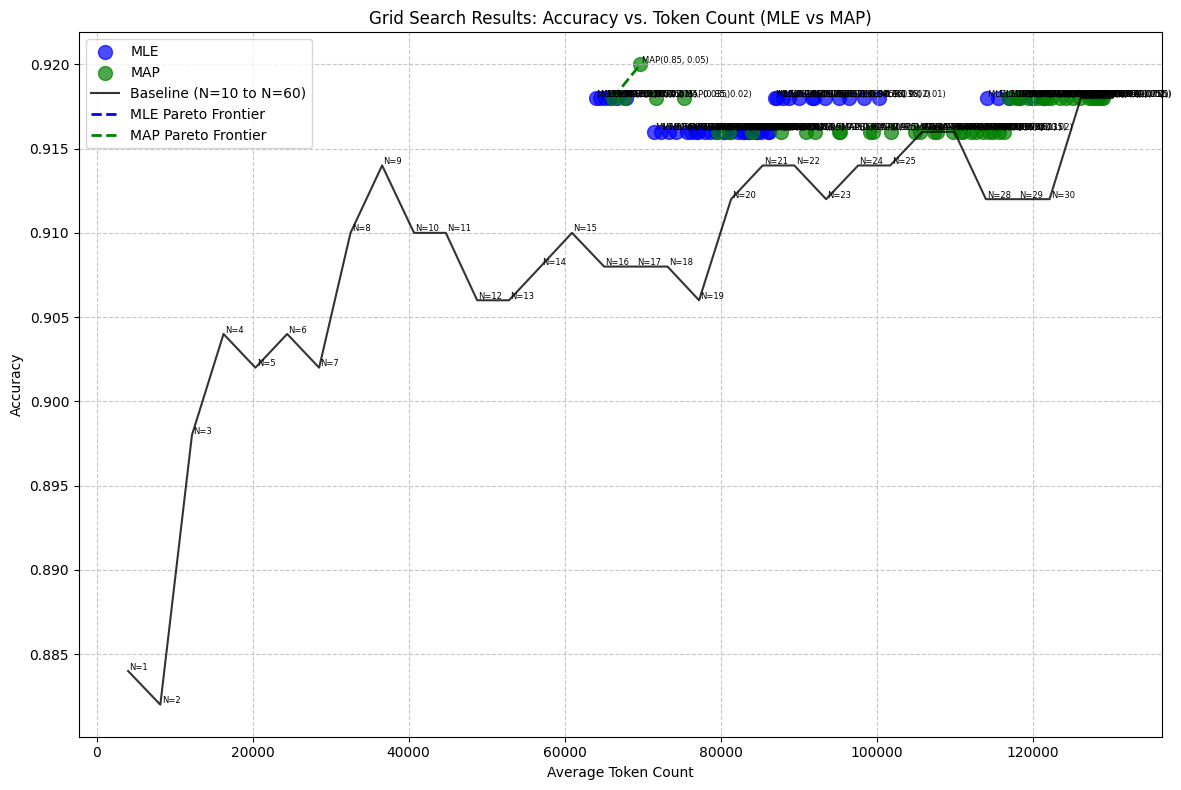


MLE Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9180, Avg Token Count: 63956.44

MAP Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9180, Avg Token Count: 66182.84
Target Score: 0.85, Percentile: 0.05, Accuracy: 0.9200, Avg Token Count: 69712.06


In [9]:
max_N_panel = 32
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

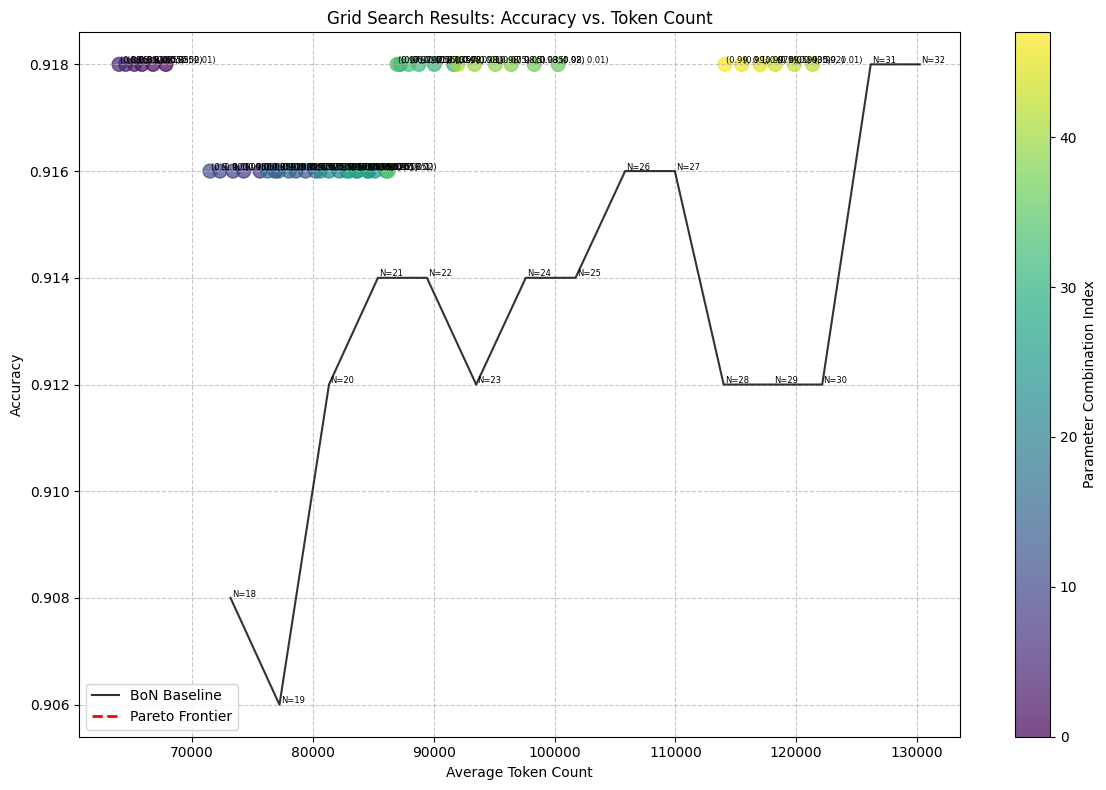

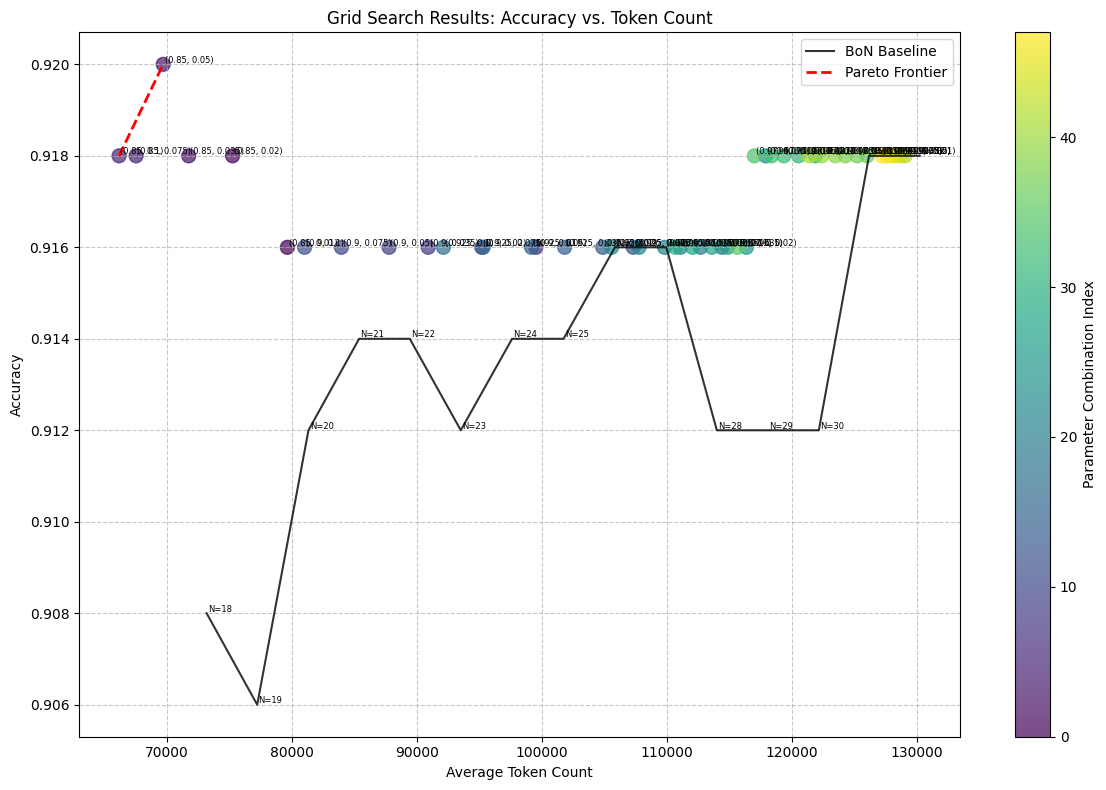

In [10]:
plot_optscale_start(mle_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel, 17)
plot_optscale_start(map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel, 17)

In [11]:
peek_number = 20

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.6015      0.1227    0.7936    0.1040    0.7826    0.1034    0.8022    0.0944
1         0.4543      0.0766    0.9702    0.0147    0.9486    0.0174    0.9713    0.0107
2         0.6429      0.1356    0.8491    0.1217    0.8279    0.1155    0.8473    0.1104
3         0.4399      0.0769    0.9812    0.0042    0.9362    0.0340    0.9783    0.0098
4         0.4217      0.1085    0.9718    0.0095    0.8427    0.1049    0.9715    0.0093
5         0.4133      0.0200    0.9788    0.0062    0.6483    0.4258    0.9770    0.0161
6         0.5740      0.1303    0.9850    0.0040    0.8355    0.5069    0.9844    0.0052
7         0.5280      0.0904    0.9697    0.0106    0.7397    0.4469    0.9708    0.0210
8         0.4172      0.0738    0.9538    0.1315    0.7870    0.1234    0.8754    0.0847
9         0.5581      0.1733    0.9794    0.0091    0.9668    0.0245    0.9790    0.0086
10        0.4970      0.1497    0.8347    0.0464    0.7589    0.0836    0.8458    0.0605
11        0.3311     

Target Score Panel: [0.85, 0.9, 0.925, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 64

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/8 [00:00<?, ?it/s]

MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 54, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 20, 64, 64, 20, 37, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 58, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 29, 20, 20, 64, 47, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 

MLE - Target Score: 0.85, Percentile: 0.01
MLE - Accuracy: 0.9180, Average Token Count: 128175.78
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 46, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 20, 64, 64, 20, 32, 55, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 49, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 25, 20, 20, 64, 40, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20

MLE - Target Score: 0.85, Percentile: 0.02
MLE - Accuracy: 0.9180, Average Token Count: 126920.27
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 39, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 59, 64, 20, 64, 64, 20, 27, 47, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 42, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 21, 20, 20, 64, 35, 20, 20, 64, 20, 20, 20, 20, 59, 20, 20

MLE - Target Score: 0.85, Percentile: 0.035
MLE - Accuracy: 0.9180, Average Token Count: 125506.86
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 53, 64, 20, 64, 64, 20, 24, 42, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 38, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 31, 20, 20, 64, 20, 20, 20, 20, 52, 20, 2

MLE - Target Score: 0.85, Percentile: 0.05
MLE - Accuracy: 0.9200, Average Token Count: 124375.83
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 46, 64, 20, 64, 64, 20, 21, 36, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 27, 20, 20, 64, 20, 20, 20, 20, 45, 20, 20

MLE - Target Score: 0.85, Percentile: 0.075
MLE - Accuracy: 0.9220, Average Token Count: 123015.81
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 41, 64, 20, 64, 64, 20, 20, 32, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 24, 20, 20, 64, 20, 20, 20, 20, 40, 20, 2

Target Score (MLE):  12%|█▎        | 1/8 [00:14<01:44, 14.97s/it]

MLE - Target Score: 0.85, Percentile: 0.1
MLE - Accuracy: 0.9220, Average Token Count: 121982.55


MLE Min N Required [33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 57, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 26, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 23, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 51, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 29, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 20, 64, 20, 28, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 53, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 63, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 64, 

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9160, Average Token Count: 142573.45
MLE Min N Required [28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 49, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 22, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 44, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 25, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 20, 64, 20, 24, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 20, 45, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 54, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20,

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9160, Average Token Count: 140378.25
MLE Min N Required [24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 42, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 38, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 22, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 39, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 46, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20,

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9160, Average Token Count: 138274.78
MLE Min N Required [22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 20, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 35, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 41, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9160, Average Token Count: 136911.04
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 20, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 30, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20,

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9140, Average Token Count: 135507.46
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 60, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 20, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20

Target Score (MLE):  25%|██▌       | 2/8 [00:32<01:38, 16.43s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9140, Average Token Count: 134582.38


MLE Min N Required [55, 20, 24, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 22, 20, 64, 48, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 46, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 43, 64, 64, 20, 64, 64, 33, 20, 20, 20, 64, 20, 64, 20, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 26, 64, 20, 30, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 51, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 64, 

MLE - Target Score: 0.925, Percentile: 0.01
MLE - Accuracy: 0.9160, Average Token Count: 151181.34
MLE Min N Required [47, 20, 21, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 41, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 39, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 36, 64, 64, 20, 64, 64, 28, 20, 20, 20, 64, 20, 64, 20, 56, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 22, 64, 20, 2

MLE - Target Score: 0.925, Percentile: 0.02
MLE - Accuracy: 0.9160, Average Token Count: 149489.17
MLE Min N Required [40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 35, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 34, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 31, 64, 64, 20, 64, 64, 24, 20, 20, 20, 64, 20, 64, 20, 48, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 61, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 2

MLE - Target Score: 0.925, Percentile: 0.035
MLE - Accuracy: 0.9160, Average Token Count: 147862.30
MLE Min N Required [36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 58, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 32, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 30, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 28, 64, 64, 20, 64, 64, 21, 20, 20, 20, 64, 20, 64, 20, 43, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 55, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 

MLE - Target Score: 0.925, Percentile: 0.05
MLE - Accuracy: 0.9160, Average Token Count: 146517.99
MLE Min N Required [31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 50, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 27, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 26, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 59, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 24, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 20, 64, 20, 37, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 47, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 2

MLE - Target Score: 0.925, Percentile: 0.075
MLE - Accuracy: 0.9160, Average Token Count: 144684.92
MLE Min N Required [28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 45, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 24, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 23, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 53, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 22, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 20, 64, 20, 33, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 42, 20, 20, 20, 58, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 

Target Score (MLE):  38%|███▊      | 3/8 [00:51<01:29, 17.81s/it]

MLE - Target Score: 0.925, Percentile: 0.1
MLE - Accuracy: 0.9160, Average Token Count: 143368.46


MLE Min N Required [64, 20, 41, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 20, 64, 20, 20, 64, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 41, 20, 20, 64, 20, 20, 20, 20, 43, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 20, 64, 29, 64, 64, 20, 64, 20, 20, 32, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 45, 64, 20, 57, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 24, 20, 64, 20, 20, 20, 64, 20, 20, 20, 64, 

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9160, Average Token Count: 159841.75
MLE Min N Required [64, 20, 35, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 64, 20, 20, 64, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 64, 20, 20, 20, 20, 37, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 59, 64, 64, 20, 64, 64, 55, 20, 20, 20, 64, 20, 64, 25, 64, 64, 20, 64, 20, 20, 27, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 39, 64, 20, 49

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9160, Average Token Count: 157837.32
MLE Min N Required [64, 20, 30, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 64, 20, 20, 64, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 64, 20, 20, 20, 20, 32, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 51, 64, 64, 20, 64, 64, 47, 20, 20, 20, 64, 20, 64, 21, 64, 64, 20, 64, 20, 20, 23, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 33, 64, 20, 42

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9160, Average Token Count: 155793.99
MLE Min N Required [64, 20, 27, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 64, 20, 20, 64, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 64, 20, 20, 20, 20, 28, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 45, 64, 64, 20, 64, 64, 42, 20, 20, 20, 64, 20, 64, 20, 64, 64, 20, 64, 20, 20, 21, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 30, 64, 20, 3

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9160, Average Token Count: 154646.24
MLE Min N Required [59, 20, 23, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 64, 20, 20, 20, 20, 25, 20, 64, 58, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 63, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 39, 64, 64, 20, 64, 64, 37, 20, 20, 20, 64, 20, 64, 20, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 26, 64, 20, 32

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9160, Average Token Count: 153088.61
MLE Min N Required [52, 20, 21, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 64, 20, 20, 20, 20, 22, 20, 64, 52, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 56, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 35, 64, 64, 20, 64, 64, 33, 20, 20, 20, 64, 20, 64, 20, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 23, 64, 20, 2

Target Score (MLE):  50%|█████     | 4/8 [01:13<01:16, 19.14s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9160, Average Token Count: 151860.21


MLE Min N Required [64, 20, 54, 20, 20, 20, 20, 20, 23, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 55, 20, 64, 20, 20, 64, 20, 20, 42, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 59, 20, 20, 64, 20, 20, 20, 20, 60, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 41, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 26, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 20, 64, 39, 64, 64, 20, 64, 20, 20, 46, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 61, 64, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 31, 20, 64, 20, 20, 20, 64, 20, 20, 20, 64, 

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9160, Average Token Count: 163677.48
MLE Min N Required [64, 20, 46, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 46, 20, 64, 20, 20, 64, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 51, 20, 20, 64, 20, 20, 20, 20, 51, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 35, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 23, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 20, 64, 33, 64, 64, 20, 64, 20, 20, 39, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 52, 64, 20, 64

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9160, Average Token Count: 161868.31
MLE Min N Required [64, 20, 40, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 20, 64, 20, 20, 64, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 64, 20, 20, 20, 20, 44, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 20, 64, 29, 64, 64, 20, 64, 20, 20, 33, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 44, 64, 20, 58

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9160, Average Token Count: 160205.83
MLE Min N Required [64, 20, 35, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 20, 64, 20, 20, 64, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 39, 20, 20, 64, 20, 20, 20, 20, 39, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 59, 64, 64, 20, 64, 64, 59, 20, 20, 20, 64, 20, 64, 26, 64, 64, 20, 64, 20, 20, 30, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 40, 64, 20, 5

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9160, Average Token Count: 158800.39
MLE Min N Required [64, 20, 31, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 64, 20, 20, 64, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 64, 20, 20, 20, 20, 34, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 51, 64, 64, 20, 64, 64, 51, 20, 20, 20, 64, 20, 64, 22, 64, 64, 20, 64, 20, 20, 26, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 34, 64, 20, 45

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9160, Average Token Count: 157001.02
MLE Min N Required [64, 20, 27, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 20, 64, 20, 20, 64, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 64, 20, 20, 20, 20, 30, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 45, 64, 64, 20, 64, 64, 46, 20, 20, 20, 64, 20, 64, 20, 64, 64, 20, 64, 20, 20, 23, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 31, 64, 20, 4

Target Score (MLE):  62%|██████▎   | 5/8 [01:35<01:01, 20.34s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9160, Average Token Count: 155584.33


MLE Min N Required [64, 20, 64, 20, 20, 20, 20, 20, 31, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 34, 20, 27, 20, 20, 24, 64, 20, 64, 20, 20, 64, 20, 20, 58, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 27, 20, 20, 64, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 32, 64, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 21, 64, 44, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 20, 64, 57, 64, 64, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 30, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 36, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 28, 37, 20, 64, 64, 20, 64, 20, 20, 64, 20, 20, 20, 20, 21, 21, 20, 20, 64, 20, 43, 20, 64, 20, 20, 20, 64, 20, 20, 20, 64, 

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9160, Average Token Count: 169151.75
MLE Min N Required [64, 20, 64, 20, 20, 20, 20, 20, 27, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 29, 20, 23, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 20, 49, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 23, 20, 20, 64, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 28, 64, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 37, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 20, 64, 48, 64, 64, 20, 64, 20, 20, 60, 20, 20, 20, 20, 64, 20, 20, 25, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 24, 32, 20, 64, 64, 20, 64

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9160, Average Token Count: 167265.36
MLE Min N Required [64, 20, 56, 20, 20, 20, 20, 20, 23, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 58, 20, 64, 20, 20, 64, 20, 20, 42, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 24, 64, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 32, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 20, 64, 41, 64, 64, 20, 64, 20, 20, 51, 20, 20, 20, 20, 64, 20, 20, 22, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 21, 27, 20, 63, 64, 20, 64

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9160, Average Token Count: 165387.35
MLE Min N Required [64, 20, 50, 20, 20, 20, 20, 20, 21, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 52, 20, 64, 20, 20, 64, 20, 20, 38, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 60, 20, 20, 64, 20, 20, 20, 20, 59, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 21, 64, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 29, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 20, 64, 37, 64, 64, 20, 64, 20, 20, 46, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 25, 20, 57, 64, 20, 6

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9160, Average Token Count: 163985.26
MLE Min N Required [64, 20, 43, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 45, 20, 64, 20, 20, 64, 20, 20, 33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 52, 20, 20, 64, 20, 20, 20, 20, 51, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 25, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 20, 64, 32, 64, 64, 20, 64, 20, 20, 40, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 21, 20, 49, 64, 20, 64

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9160, Average Token Count: 162270.79
MLE Min N Required [64, 20, 38, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 20, 64, 20, 20, 64, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 46, 20, 20, 64, 20, 20, 20, 20, 45, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 22, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 62, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 20, 64, 29, 64, 64, 20, 64, 20, 20, 35, 20, 20, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 44, 64, 20, 5

Target Score (MLE):  75%|███████▌  | 6/8 [02:00<00:44, 22.04s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9160, Average Token Count: 160942.09


MLE Min N Required [64, 20, 64, 20, 24, 20, 20, 28, 49, 20, 64, 20, 47, 20, 20, 20, 28, 20, 20, 64, 23, 20, 49, 29, 64, 20, 64, 20, 20, 53, 64, 45, 64, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 64, 20, 20, 64, 29, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 64, 56, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 64, 53, 64, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 33, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 25, 20, 64, 64, 64, 64, 64, 64, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 64, 64, 64, 64, 20, 20, 64, 20, 20, 22, 20, 64, 20, 28, 51, 20, 20, 20, 20, 20, 36, 21, 20, 62, 20, 64, 20, 20, 23, 20, 20, 64, 64, 20, 54, 64, 64, 26, 20, 64, 55, 64, 20, 64, 64, 20, 64, 30, 20, 64, 24, 20, 20, 20, 38, 33, 20, 20, 64, 20, 64, 20, 64, 20, 20, 20, 64, 20, 20, 20, 64, 

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9160, Average Token Count: 180568.01
MLE Min N Required [64, 20, 64, 20, 20, 20, 20, 24, 41, 20, 64, 20, 40, 20, 20, 20, 23, 20, 20, 64, 20, 20, 41, 25, 55, 20, 59, 20, 20, 45, 64, 38, 64, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 64, 20, 20, 64, 24, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 64, 48, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 64, 45, 64, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 28, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 22, 20, 64, 54, 64, 64, 64, 64, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 55, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 24, 43, 20, 20, 20, 20, 20, 30, 20, 20, 53, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 46, 64, 64, 22, 20, 64, 47, 64, 20, 64, 64, 20, 64

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9160, Average Token Count: 177010.18
MLE Min N Required [64, 20, 64, 20, 20, 20, 20, 21, 35, 20, 64, 20, 35, 20, 20, 20, 20, 20, 20, 64, 20, 20, 36, 22, 47, 20, 50, 20, 20, 39, 64, 33, 64, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 64, 20, 20, 64, 21, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 64, 41, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 39, 64, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 24, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 47, 64, 64, 64, 64, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 47, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 37, 20, 20, 20, 20, 20, 26, 20, 20, 45, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 40, 64, 64, 20, 20, 64, 40, 64, 20, 64, 64, 20, 64

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9160, Average Token Count: 174297.99
MLE Min N Required [64, 20, 64, 20, 20, 20, 20, 20, 32, 20, 64, 20, 31, 20, 20, 20, 20, 20, 20, 64, 20, 20, 32, 20, 42, 20, 45, 20, 20, 34, 64, 29, 64, 20, 20, 64, 20, 20, 59, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 64, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 35, 64, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 22, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 42, 64, 60, 64, 64, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 42, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 33, 20, 20, 20, 20, 20, 23, 20, 20, 40, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 36, 64, 64, 20, 20, 64, 36, 64, 20, 64, 64, 20, 6

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9160, Average Token Count: 172591.18
MLE Min N Required [64, 20, 64, 20, 20, 20, 20, 20, 28, 20, 64, 20, 27, 20, 20, 20, 20, 20, 20, 64, 20, 20, 28, 20, 37, 20, 39, 20, 20, 30, 64, 25, 64, 20, 20, 64, 20, 20, 51, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 64, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 30, 64, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 36, 64, 52, 64, 64, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 36, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 31, 64, 64, 20, 20, 64, 31, 64, 20, 64, 64, 20, 64

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9160, Average Token Count: 170513.14
MLE Min N Required [64, 20, 61, 20, 20, 20, 20, 20, 25, 20, 64, 20, 24, 20, 20, 20, 20, 20, 20, 64, 20, 20, 25, 20, 33, 20, 35, 20, 20, 27, 64, 23, 64, 20, 20, 64, 20, 20, 45, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 64, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 27, 64, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 20, 20, 64, 32, 64, 46, 64, 64, 20, 64, 20, 20, 61, 20, 20, 20, 20, 64, 20, 20, 32, 64, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 28, 64, 64, 20, 20, 64, 28, 60, 20, 64, 64, 20, 6

Target Score (MLE):  88%|████████▊ | 7/8 [02:30<00:24, 24.42s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9160, Average Token Count: 168924.13


MLE Min N Required [64, 64, 64, 64, 64, 64, 50, 64, 64, 43, 64, 64, 64, 35, 20, 64, 64, 28, 47, 64, 64, 20, 64, 64, 64, 64, 64, 41, 64, 64, 64, 64, 64, 28, 62, 64, 64, 20, 64, 20, 43, 20, 20, 41, 25, 64, 64, 50, 23, 64, 34, 24, 32, 54, 64, 64, 49, 64, 64, 64, 29, 64, 64, 64, 64, 64, 64, 31, 64, 29, 64, 20, 20, 64, 64, 64, 64, 20, 20, 64, 20, 64, 58, 62, 64, 22, 27, 64, 64, 64, 64, 64, 26, 28, 64, 47, 64, 64, 64, 30, 20, 20, 20, 33, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 49, 61, 46, 64, 20, 64, 22, 41, 20, 64, 20, 45, 20, 20, 64, 64, 64, 64, 64, 20, 31, 20, 64, 20, 20, 64, 20, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 36, 50, 20, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 64, 20, 43, 64, 64, 64, 20, 64, 64, 64, 64, 64, 20, 43, 64, 20, 21, 44, 20, 64, 29, 64, 64, 64, 64, 27, 44, 32, 64, 43, 47, 64, 48, 64, 64, 34, 64, 21, 20, 64, 64, 28, 64, 64, 64, 54, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 24, 20, 20, 64, 64, 20, 43, 64, 37, 64, 20, 64, 20, 20, 29, 64, 64, 25, 20, 64, 

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9160, Average Token Count: 221366.79
MLE Min N Required [64, 58, 64, 64, 64, 64, 42, 64, 64, 36, 64, 64, 64, 30, 20, 64, 64, 24, 40, 64, 64, 20, 64, 64, 64, 64, 64, 35, 64, 64, 64, 64, 64, 24, 53, 64, 64, 20, 64, 20, 37, 20, 20, 35, 21, 64, 64, 43, 20, 64, 29, 20, 27, 46, 64, 64, 42, 64, 64, 64, 25, 64, 64, 64, 64, 64, 64, 27, 64, 25, 64, 20, 20, 64, 64, 64, 64, 20, 20, 64, 20, 64, 50, 53, 64, 20, 23, 64, 64, 64, 64, 64, 22, 24, 58, 40, 64, 64, 64, 25, 20, 20, 20, 28, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 42, 52, 39, 64, 20, 64, 20, 35, 20, 64, 20, 39, 20, 20, 64, 64, 64, 57, 64, 20, 26, 20, 64, 20, 20, 64, 20, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 30, 43, 20, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 64, 20, 37, 64, 64, 64, 20, 61, 64, 64, 64, 64, 20, 37, 64, 20, 20, 37, 20, 64, 25, 64, 64, 64, 64, 23, 37, 27, 64, 37, 40, 64, 41, 64, 64, 29, 64, 20, 20, 64, 64, 24, 64, 64, 64, 46, 20, 64, 64, 64, 64, 64, 64, 20, 64

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9160, Average Token Count: 216734.67
MLE Min N Required [64, 50, 64, 64, 64, 64, 37, 64, 64, 31, 64, 64, 64, 25, 20, 64, 64, 21, 35, 64, 64, 20, 64, 64, 64, 64, 64, 30, 64, 64, 64, 64, 64, 21, 46, 64, 64, 20, 64, 20, 32, 20, 20, 30, 20, 62, 64, 37, 20, 64, 25, 20, 23, 40, 64, 64, 36, 64, 64, 64, 21, 64, 64, 64, 64, 64, 64, 23, 64, 21, 64, 20, 20, 64, 64, 64, 64, 20, 20, 64, 20, 64, 43, 46, 64, 20, 20, 64, 64, 64, 64, 64, 20, 21, 50, 35, 64, 64, 64, 22, 20, 20, 20, 24, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 36, 44, 34, 64, 20, 64, 20, 30, 20, 64, 20, 33, 20, 20, 64, 64, 56, 49, 64, 20, 22, 20, 64, 20, 20, 64, 20, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 26, 37, 20, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 64, 20, 32, 64, 64, 64, 20, 52, 64, 64, 64, 64, 20, 31, 64, 20, 20, 32, 20, 64, 21, 64, 64, 64, 64, 20, 32, 23, 64, 31, 35, 64, 35, 64, 64, 25, 64, 20, 20, 64, 64, 21, 64, 64, 64, 40, 20, 64, 64, 64, 64, 64, 64, 20, 64

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9160, Average Token Count: 212394.30
MLE Min N Required [64, 45, 64, 64, 64, 64, 33, 64, 64, 28, 64, 64, 64, 23, 20, 64, 64, 20, 31, 64, 64, 20, 64, 64, 64, 64, 64, 27, 64, 64, 64, 64, 64, 20, 41, 64, 64, 20, 64, 20, 28, 20, 20, 27, 20, 55, 64, 33, 20, 59, 22, 20, 21, 35, 64, 64, 32, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 21, 64, 20, 64, 20, 20, 59, 64, 64, 64, 20, 20, 64, 20, 64, 39, 41, 64, 20, 20, 63, 64, 64, 64, 64, 20, 20, 45, 31, 64, 64, 64, 20, 20, 20, 20, 22, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 32, 40, 31, 64, 20, 64, 20, 27, 20, 64, 20, 30, 20, 20, 64, 64, 51, 44, 57, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 24, 33, 20, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 64, 20, 28, 64, 64, 64, 20, 47, 64, 64, 64, 64, 20, 28, 64, 20, 20, 29, 20, 64, 20, 61, 64, 64, 64, 20, 29, 21, 64, 28, 31, 64, 31, 64, 64, 22, 64, 20, 20, 64, 64, 20, 64, 64, 64, 35, 20, 64, 64, 64, 58, 64, 64, 20, 6

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9160, Average Token Count: 209087.79
MLE Min N Required [64, 39, 64, 64, 64, 64, 29, 64, 56, 24, 64, 64, 64, 20, 20, 64, 64, 20, 27, 64, 64, 20, 64, 64, 64, 64, 64, 23, 64, 64, 64, 64, 64, 20, 36, 64, 64, 20, 64, 20, 25, 20, 20, 23, 20, 48, 64, 29, 20, 51, 20, 20, 20, 31, 64, 64, 28, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 20, 20, 51, 64, 64, 64, 20, 20, 64, 20, 64, 33, 36, 64, 20, 20, 55, 64, 64, 64, 64, 20, 20, 39, 27, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 64, 62, 20, 28, 35, 27, 64, 20, 64, 20, 24, 20, 64, 20, 26, 20, 20, 64, 57, 44, 38, 50, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 21, 29, 20, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 64, 20, 25, 64, 64, 64, 20, 41, 64, 64, 64, 64, 20, 25, 64, 20, 20, 25, 20, 64, 20, 53, 63, 64, 64, 20, 25, 20, 64, 24, 27, 64, 27, 64, 64, 20, 64, 20, 20, 64, 64, 20, 64, 64, 64, 31, 20, 64, 64, 64, 51, 64, 64, 20, 64

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9160, Average Token Count: 204716.35
MLE Min N Required [64, 35, 64, 64, 64, 64, 26, 64, 50, 22, 64, 58, 64, 20, 20, 64, 62, 20, 24, 64, 64, 20, 64, 64, 64, 64, 64, 21, 64, 64, 64, 64, 64, 20, 32, 64, 64, 20, 64, 20, 22, 20, 20, 21, 20, 43, 64, 26, 20, 45, 20, 20, 20, 27, 64, 59, 25, 64, 64, 64, 20, 63, 64, 64, 64, 64, 64, 20, 64, 20, 64, 20, 20, 46, 64, 64, 60, 20, 20, 64, 20, 64, 30, 32, 64, 20, 20, 49, 64, 64, 64, 64, 20, 20, 35, 24, 64, 64, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 64, 55, 20, 25, 31, 24, 64, 20, 64, 20, 21, 20, 64, 20, 23, 20, 20, 64, 51, 39, 34, 44, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 25, 20, 64, 64, 64, 64, 64, 64, 20, 64, 20, 63, 64, 20, 22, 64, 64, 64, 20, 36, 64, 64, 64, 64, 20, 22, 64, 20, 20, 22, 20, 64, 20, 47, 56, 64, 64, 20, 22, 20, 64, 22, 24, 64, 24, 64, 62, 20, 64, 20, 20, 64, 64, 20, 64, 64, 64, 27, 20, 64, 64, 64, 45, 64, 64, 20, 6

Target Score (MLE): 100%|██████████| 8/8 [03:18<00:00, 24.81s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9160, Average Token Count: 201048.96

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/8 [00:00<?, ?it/s]

MAP Min N Required [20, 20, 20, 20, 20, 28, 21, 23, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 22, 20, 20, 20, 22, 20, 20, 20, 20, 20, 25, 64, 20, 20, 20, 20, 28, 24, 22, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 64, 20, 20, 20, 23, 20, 22, 64, 20, 36, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 22, 20, 20, 26, 20, 64, 20, 64, 20, 20, 26, 20, 20, 64, 64, 20, 20, 20, 20, 28, 25, 24, 64, 20, 20, 26, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 64, 22, 21, 27, 20, 20, 20, 20, 20, 22, 27, 25, 20, 20, 28, 22, 20, 64, 25, 20, 64, 21, 20, 20, 26, 64, 64, 21, 64, 64, 20, 38, 64, 20, 20, 20, 25, 64, 20, 64, 20, 20, 64, 26, 64, 27, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 64, 64, 20, 24, 64, 28, 20, 20, 20, 57, 20, 20, 20, 20, 20, 20, 22, 23, 20, 21, 20, 20, 24, 45, 20, 22, 21, 20, 23, 64, 44, 20, 23, 64, 49, 20, 27, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 25, 28, 21, 20, 20, 20, 22, 20, 20, 20, 20, 23, 64, 20, 20, 26, 64, 21, 20, 20, 20, 

MAP - Target Score: 0.85, Percentile: 0.01
MAP - Accuracy: 0.9180, Average Token Count: 131522.52
MAP Min N Required [20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 54, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 31, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 22, 20, 64, 20, 64, 20, 20, 22, 20, 20, 64, 64, 20, 20, 20, 20, 24, 21, 20, 64, 20, 20, 22, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 64, 20, 20, 23, 20, 20, 20, 20, 20, 20, 23, 21, 20, 20, 24, 20, 20, 64, 22, 20, 64, 20, 20, 20, 22, 64, 64, 20, 64, 64, 20, 32, 56, 20, 20, 20, 21, 64, 20, 64, 20, 20, 64, 22, 64, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 24, 20, 20, 20, 48, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 38, 20, 20, 20, 20, 20, 64, 38, 20, 20, 64, 42, 20, 23, 64, 20, 20, 20, 20, 64, 20, 20

MAP - Target Score: 0.85, Percentile: 0.02
MAP - Accuracy: 0.9180, Average Token Count: 128008.03
MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 46, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 60, 64, 20, 64, 64, 20, 28, 48, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 21, 20, 20, 20, 41, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 33, 20, 20, 20, 20, 20, 64, 32, 20, 20, 64, 36, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20

MAP - Target Score: 0.85, Percentile: 0.035
MAP - Accuracy: 0.9160, Average Token Count: 125904.27
MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 42, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 54, 64, 20, 64, 64, 20, 25, 43, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 20, 20, 64, 29, 20, 20, 64, 32, 20, 20, 64, 20, 20, 20, 20, 64, 20, 2

MAP - Target Score: 0.85, Percentile: 0.05
MAP - Accuracy: 0.9160, Average Token Count: 124757.38
MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 46, 64, 20, 64, 64, 20, 22, 37, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 64, 25, 20, 20, 64, 28, 20, 20, 64, 20, 20, 20, 20, 56, 20, 20

MAP - Target Score: 0.85, Percentile: 0.075
MAP - Accuracy: 0.9160, Average Token Count: 123156.79
MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 41, 64, 20, 64, 64, 20, 20, 33, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 64, 22, 20, 20, 64, 25, 20, 20, 64, 20, 20, 20, 20, 50, 20, 2

Target Score (MAP):  12%|█▎        | 1/8 [00:20<02:26, 20.86s/it]

MAP - Target Score: 0.85, Percentile: 0.1
MAP - Accuracy: 0.9200, Average Token Count: 121975.21


MAP Min N Required [39, 20, 20, 20, 20, 44, 33, 37, 30, 20, 64, 28, 20, 31, 24, 23, 20, 20, 20, 20, 20, 32, 20, 32, 34, 29, 20, 20, 33, 20, 20, 20, 26, 20, 40, 64, 20, 20, 20, 20, 45, 37, 35, 33, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 35, 64, 31, 20, 20, 36, 20, 34, 64, 45, 64, 20, 46, 20, 20, 20, 20, 20, 20, 20, 20, 20, 33, 20, 20, 20, 38, 33, 20, 20, 42, 20, 64, 20, 64, 20, 20, 40, 20, 31, 64, 64, 25, 20, 20, 20, 44, 39, 37, 64, 20, 20, 41, 20, 20, 20, 31, 20, 38, 30, 20, 53, 28, 64, 34, 36, 42, 34, 20, 21, 20, 20, 34, 45, 40, 20, 20, 45, 34, 25, 64, 42, 20, 64, 32, 20, 24, 41, 64, 64, 39, 64, 64, 20, 64, 64, 22, 20, 20, 39, 64, 20, 64, 20, 20, 64, 41, 64, 43, 29, 20, 20, 20, 31, 38, 44, 20, 20, 20, 55, 64, 64, 20, 38, 64, 45, 30, 20, 30, 64, 28, 20, 26, 20, 20, 20, 35, 35, 20, 33, 20, 20, 39, 64, 31, 34, 33, 29, 35, 64, 64, 20, 37, 64, 64, 20, 43, 64, 32, 20, 20, 23, 64, 20, 28, 32, 20, 64, 41, 44, 33, 20, 20, 20, 34, 20, 38, 20, 20, 36, 64, 20, 20, 41, 64, 32, 20, 24, 64, 

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9160, Average Token Count: 157905.00
MAP Min N Required [34, 20, 20, 20, 20, 38, 28, 31, 26, 20, 64, 24, 20, 26, 20, 20, 20, 20, 20, 20, 20, 27, 20, 27, 29, 25, 20, 20, 28, 20, 20, 20, 22, 20, 34, 64, 20, 20, 20, 20, 38, 32, 30, 28, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 30, 64, 26, 20, 20, 31, 20, 29, 64, 38, 64, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 32, 29, 20, 20, 36, 20, 64, 20, 64, 20, 20, 34, 20, 26, 64, 64, 21, 20, 20, 20, 37, 33, 32, 64, 20, 20, 35, 20, 20, 20, 26, 20, 32, 25, 20, 45, 24, 64, 29, 30, 36, 29, 20, 20, 20, 20, 29, 39, 34, 20, 20, 38, 29, 22, 64, 36, 20, 64, 27, 20, 21, 35, 64, 64, 33, 64, 64, 20, 64, 64, 20, 20, 20, 34, 64, 20, 64, 20, 20, 64, 35, 64, 36, 25, 20, 20, 20, 27, 32, 37, 20, 20, 20, 47, 64, 64, 20, 32, 64, 38, 26, 20, 26, 64, 24, 20, 22, 20, 20, 20, 30, 30, 20, 28, 20, 20, 33, 64, 26, 29, 28, 25, 30, 64, 64, 20, 32, 64, 64, 20, 36, 64, 27, 20, 20, 20, 64, 20, 24,

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9160, Average Token Count: 150877.88
MAP Min N Required [29, 20, 20, 20, 20, 32, 24, 27, 22, 20, 64, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 24, 20, 23, 25, 22, 20, 20, 24, 20, 20, 20, 20, 20, 29, 64, 20, 20, 20, 20, 33, 27, 25, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 26, 64, 22, 20, 20, 26, 20, 25, 64, 33, 64, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 28, 25, 20, 20, 31, 20, 64, 20, 64, 20, 20, 30, 20, 22, 64, 64, 20, 20, 20, 20, 32, 28, 27, 64, 20, 20, 30, 20, 20, 20, 23, 20, 28, 22, 20, 39, 21, 64, 25, 26, 31, 25, 20, 20, 20, 20, 25, 33, 29, 20, 20, 33, 25, 20, 64, 31, 20, 64, 23, 20, 20, 30, 64, 64, 28, 64, 64, 20, 64, 64, 20, 20, 20, 29, 64, 20, 64, 20, 20, 64, 30, 64, 31, 21, 20, 20, 20, 23, 27, 32, 20, 20, 20, 40, 64, 64, 20, 28, 64, 33, 22, 20, 22, 64, 21, 20, 20, 20, 20, 20, 25, 26, 20, 24, 20, 20, 28, 64, 23, 25, 24, 21, 26, 64, 64, 20, 27, 64, 64, 20, 31, 64, 23, 20, 20, 20, 64, 20, 20,

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9160, Average Token Count: 145042.95
MAP Min N Required [26, 20, 20, 20, 20, 29, 22, 24, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 21, 22, 20, 20, 20, 22, 20, 20, 20, 20, 20, 26, 64, 20, 20, 20, 20, 29, 24, 23, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 64, 20, 20, 20, 24, 20, 23, 64, 29, 64, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 25, 22, 20, 20, 27, 20, 64, 20, 64, 20, 20, 26, 20, 20, 64, 64, 20, 20, 20, 20, 28, 25, 24, 64, 20, 20, 27, 20, 20, 20, 20, 20, 25, 20, 20, 35, 20, 64, 22, 23, 27, 22, 20, 20, 20, 20, 22, 30, 26, 20, 20, 30, 22, 20, 64, 27, 20, 64, 21, 20, 20, 27, 64, 64, 25, 64, 64, 20, 64, 64, 20, 20, 20, 26, 64, 20, 64, 20, 20, 64, 27, 64, 28, 20, 20, 20, 20, 21, 25, 29, 20, 20, 20, 36, 64, 64, 20, 25, 64, 29, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 23, 23, 20, 21, 20, 20, 25, 64, 20, 22, 22, 20, 23, 64, 64, 20, 24, 64, 64, 20, 28, 64, 21, 20, 20, 20, 64, 20, 20

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9160, Average Token Count: 141378.31
MAP Min N Required [22, 20, 20, 20, 20, 25, 20, 21, 20, 20, 59, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 64, 20, 20, 20, 20, 25, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 25, 64, 20, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 24, 20, 64, 20, 64, 20, 20, 23, 20, 20, 64, 64, 20, 20, 20, 20, 25, 22, 21, 64, 20, 20, 23, 20, 20, 20, 20, 20, 22, 20, 20, 30, 20, 64, 20, 20, 24, 20, 20, 20, 20, 20, 20, 26, 23, 20, 20, 26, 20, 20, 64, 24, 20, 64, 20, 20, 20, 23, 64, 64, 22, 64, 64, 20, 64, 64, 20, 20, 20, 22, 64, 20, 64, 20, 20, 64, 23, 64, 24, 20, 20, 20, 20, 20, 21, 25, 20, 20, 20, 31, 64, 64, 20, 21, 64, 25, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 64, 20, 20, 20, 20, 20, 64, 64, 20, 21, 64, 64, 20, 24, 64, 20, 20, 20, 20, 64, 20, 20,

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9160, Average Token Count: 137652.35
MAP Min N Required [20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 52, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 23, 57, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 64, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 20, 22, 20, 20, 64, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 64, 20, 20, 21, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 23, 20, 20, 64, 21, 20, 64, 20, 20, 20, 21, 64, 64, 20, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 64, 21, 64, 22, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 28, 64, 64, 20, 20, 64, 23, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 64, 20, 22, 64, 20, 20, 20, 20, 64, 20, 20

Target Score (MAP):  25%|██▌       | 2/8 [00:48<02:29, 24.96s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9160, Average Token Count: 135521.07


MAP Min N Required [64, 20, 31, 20, 27, 61, 45, 50, 48, 20, 64, 38, 20, 42, 33, 33, 20, 20, 20, 20, 20, 44, 20, 43, 46, 43, 20, 20, 45, 20, 29, 20, 50, 20, 54, 64, 20, 20, 30, 20, 61, 50, 47, 45, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 59, 20, 48, 64, 44, 20, 20, 49, 26, 47, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 47, 20, 20, 20, 52, 46, 20, 22, 58, 20, 64, 20, 64, 20, 20, 55, 20, 42, 64, 64, 52, 20, 20, 20, 60, 53, 51, 64, 20, 20, 56, 20, 20, 20, 42, 20, 52, 42, 20, 64, 42, 64, 46, 51, 57, 48, 20, 31, 20, 20, 45, 64, 55, 21, 20, 62, 46, 36, 64, 59, 20, 64, 44, 20, 35, 57, 64, 64, 58, 64, 64, 20, 64, 64, 38, 20, 20, 54, 64, 20, 64, 20, 24, 64, 56, 64, 58, 40, 20, 20, 20, 43, 51, 64, 20, 20, 20, 64, 64, 64, 20, 51, 64, 61, 41, 20, 41, 64, 38, 20, 42, 20, 20, 24, 47, 47, 20, 44, 20, 20, 53, 64, 42, 46, 45, 42, 48, 64, 64, 20, 51, 64, 64, 27, 59, 64, 43, 20, 20, 39, 64, 20, 48, 43, 20, 64, 56, 61, 45, 20, 20, 20, 46, 20, 64, 20, 22, 49, 64, 20, 20, 56, 64, 44, 20, 34, 64, 

MAP - Target Score: 0.925, Percentile: 0.01
MAP - Accuracy: 0.9160, Average Token Count: 180967.35
MAP Min N Required [57, 20, 26, 20, 23, 52, 38, 43, 41, 20, 64, 33, 20, 36, 28, 28, 20, 20, 20, 20, 20, 37, 20, 37, 39, 37, 20, 20, 39, 20, 25, 20, 42, 20, 46, 64, 20, 20, 25, 20, 52, 43, 40, 38, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 50, 20, 41, 64, 38, 20, 20, 42, 22, 40, 64, 64, 64, 20, 56, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 44, 39, 20, 20, 49, 20, 64, 20, 64, 20, 20, 47, 20, 35, 64, 64, 44, 20, 20, 20, 51, 45, 43, 64, 20, 20, 48, 20, 20, 20, 36, 20, 44, 36, 20, 64, 35, 64, 39, 43, 49, 41, 20, 26, 20, 20, 39, 54, 47, 20, 20, 53, 39, 31, 64, 50, 20, 64, 37, 20, 30, 48, 64, 64, 49, 64, 64, 20, 64, 64, 32, 20, 20, 46, 64, 20, 64, 20, 20, 64, 48, 64, 50, 34, 20, 20, 20, 36, 44, 64, 20, 20, 20, 64, 64, 64, 20, 44, 64, 52, 35, 20, 35, 64, 32, 20, 36, 20, 20, 20, 40, 40, 20, 38, 20, 20, 45, 64, 36, 39, 39, 35, 41, 64, 64, 20, 43, 64, 64, 23, 50, 64, 37, 20, 20, 33, 64, 20, 4

MAP - Target Score: 0.925, Percentile: 0.02
MAP - Accuracy: 0.9160, Average Token Count: 171661.85
MAP Min N Required [49, 20, 23, 20, 20, 45, 33, 37, 35, 20, 64, 28, 20, 31, 24, 24, 20, 20, 20, 20, 20, 32, 20, 32, 33, 32, 20, 20, 33, 20, 21, 20, 36, 20, 40, 64, 20, 20, 22, 20, 45, 37, 35, 33, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 43, 20, 35, 64, 32, 20, 20, 36, 20, 34, 64, 57, 64, 20, 48, 20, 20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 20, 38, 33, 20, 20, 42, 20, 64, 20, 64, 20, 20, 40, 20, 30, 64, 64, 38, 20, 20, 20, 43, 38, 37, 64, 20, 20, 41, 20, 20, 20, 31, 20, 38, 31, 20, 64, 30, 64, 34, 37, 42, 35, 20, 23, 20, 20, 33, 47, 40, 20, 20, 45, 34, 26, 64, 43, 20, 64, 32, 20, 26, 42, 64, 64, 42, 64, 64, 20, 64, 64, 28, 20, 20, 40, 64, 20, 64, 20, 20, 64, 41, 64, 43, 29, 20, 20, 20, 31, 37, 64, 20, 20, 20, 64, 64, 64, 20, 38, 64, 44, 30, 20, 30, 64, 28, 20, 31, 20, 20, 20, 35, 35, 20, 32, 20, 20, 39, 64, 31, 34, 33, 30, 35, 64, 64, 20, 37, 64, 64, 20, 43, 64, 31, 20, 20, 28, 64, 20, 3

MAP - Target Score: 0.925, Percentile: 0.035
MAP - Accuracy: 0.9160, Average Token Count: 163908.60
MAP Min N Required [44, 20, 20, 20, 20, 40, 29, 33, 31, 20, 64, 25, 20, 28, 22, 22, 20, 20, 20, 20, 20, 29, 20, 28, 30, 28, 20, 20, 30, 20, 20, 20, 33, 20, 35, 64, 20, 20, 20, 20, 40, 33, 31, 29, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 38, 20, 31, 64, 29, 20, 20, 32, 20, 31, 64, 51, 64, 20, 43, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 34, 30, 20, 20, 38, 20, 64, 20, 64, 20, 20, 36, 20, 27, 64, 64, 34, 20, 20, 20, 39, 34, 33, 64, 20, 20, 37, 20, 20, 20, 27, 20, 34, 27, 20, 64, 27, 64, 30, 33, 37, 31, 20, 20, 20, 20, 30, 42, 36, 20, 20, 40, 30, 24, 64, 38, 20, 64, 29, 20, 23, 37, 64, 64, 38, 64, 64, 20, 64, 64, 25, 20, 20, 35, 64, 20, 64, 20, 20, 64, 37, 64, 38, 26, 20, 20, 20, 28, 33, 60, 20, 20, 20, 64, 64, 64, 20, 34, 64, 40, 27, 20, 27, 64, 25, 20, 27, 20, 20, 20, 31, 31, 20, 29, 20, 20, 35, 64, 28, 30, 30, 27, 31, 64, 64, 20, 33, 64, 64, 20, 38, 64, 28, 20, 20, 25, 64, 20, 

MAP - Target Score: 0.925, Percentile: 0.05
MAP - Accuracy: 0.9160, Average Token Count: 158609.84
MAP Min N Required [38, 20, 20, 20, 20, 35, 25, 29, 27, 20, 64, 22, 20, 24, 20, 20, 20, 20, 20, 20, 20, 25, 20, 25, 26, 24, 20, 20, 26, 20, 20, 20, 28, 20, 31, 64, 20, 20, 20, 20, 35, 29, 27, 25, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 33, 20, 27, 64, 25, 20, 20, 28, 20, 27, 64, 44, 64, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 29, 26, 20, 20, 33, 20, 64, 20, 64, 20, 20, 31, 20, 24, 64, 64, 29, 20, 20, 20, 34, 30, 29, 64, 20, 20, 32, 20, 20, 20, 24, 20, 30, 24, 20, 61, 24, 64, 26, 29, 32, 27, 20, 20, 20, 20, 26, 36, 31, 20, 20, 35, 26, 20, 64, 33, 20, 64, 25, 20, 20, 32, 64, 64, 33, 64, 64, 20, 64, 64, 22, 20, 20, 31, 64, 20, 64, 20, 20, 64, 32, 64, 33, 22, 20, 20, 20, 24, 29, 52, 20, 20, 20, 64, 64, 64, 20, 29, 64, 34, 23, 20, 23, 64, 22, 20, 24, 20, 20, 20, 27, 27, 20, 25, 20, 20, 30, 64, 24, 26, 26, 24, 27, 64, 64, 20, 29, 64, 64, 20, 33, 64, 24, 20, 20, 22, 64, 20, 2

MAP - Target Score: 0.925, Percentile: 0.075
MAP - Accuracy: 0.9160, Average Token Count: 152421.05
MAP Min N Required [34, 20, 20, 20, 20, 31, 23, 25, 24, 20, 64, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 22, 20, 22, 23, 22, 20, 20, 23, 20, 20, 20, 25, 20, 27, 64, 20, 20, 20, 20, 31, 25, 24, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 24, 64, 22, 20, 20, 25, 20, 24, 64, 39, 64, 20, 33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 26, 23, 20, 20, 29, 20, 64, 20, 64, 20, 20, 28, 20, 21, 64, 64, 26, 20, 20, 20, 30, 27, 26, 64, 20, 20, 28, 20, 20, 20, 21, 20, 26, 21, 20, 54, 21, 64, 23, 26, 29, 24, 20, 20, 20, 20, 23, 32, 28, 20, 20, 31, 23, 20, 64, 30, 20, 64, 22, 20, 20, 29, 64, 64, 29, 64, 64, 20, 64, 64, 20, 20, 20, 27, 64, 20, 64, 20, 20, 64, 28, 64, 29, 20, 20, 20, 20, 22, 26, 47, 20, 20, 20, 59, 64, 64, 20, 26, 64, 31, 21, 20, 21, 64, 20, 20, 21, 20, 20, 20, 24, 24, 20, 22, 20, 20, 27, 64, 21, 23, 23, 21, 24, 64, 64, 20, 26, 64, 64, 20, 30, 64, 22, 20, 20, 20, 64, 20, 

Target Score (MAP):  38%|███▊      | 3/8 [01:22<02:24, 28.90s/it]

MAP - Target Score: 0.925, Percentile: 0.1
MAP - Accuracy: 0.9160, Average Token Count: 147845.00


MAP Min N Required [64, 20, 54, 20, 48, 64, 64, 64, 64, 20, 64, 60, 20, 64, 52, 53, 27, 20, 31, 20, 20, 64, 31, 64, 64, 64, 20, 36, 64, 20, 56, 20, 64, 20, 64, 64, 20, 20, 52, 20, 64, 64, 64, 64, 20, 60, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 64, 64, 20, 26, 64, 52, 64, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 24, 20, 64, 20, 20, 20, 64, 64, 20, 35, 64, 22, 64, 20, 64, 20, 20, 64, 20, 64, 64, 64, 64, 20, 20, 32, 64, 64, 64, 64, 27, 20, 64, 20, 32, 20, 64, 20, 64, 64, 21, 64, 64, 64, 64, 64, 64, 64, 20, 52, 20, 20, 64, 64, 64, 34, 20, 64, 64, 57, 64, 64, 23, 64, 64, 20, 58, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 26, 64, 64, 20, 64, 39, 43, 64, 64, 64, 64, 60, 25, 20, 20, 64, 64, 64, 20, 20, 20, 64, 64, 64, 20, 64, 64, 64, 63, 27, 63, 64, 58, 20, 64, 20, 20, 45, 64, 64, 31, 64, 20, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 56, 64, 64, 64, 41, 20, 64, 64, 20, 64, 64, 20, 64, 64, 64, 64, 20, 20, 20, 64, 20, 64, 20, 38, 64, 64, 20, 20, 64, 64, 64, 29, 54, 64, 

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9160, Average Token Count: 207807.57
MAP Min N Required [64, 20, 46, 20, 41, 64, 58, 64, 64, 20, 64, 51, 20, 55, 44, 45, 23, 20, 26, 20, 20, 57, 27, 57, 59, 61, 20, 30, 59, 20, 47, 20, 64, 20, 64, 64, 20, 20, 44, 20, 64, 64, 61, 58, 20, 51, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 62, 64, 61, 20, 22, 63, 44, 61, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 21, 20, 64, 20, 20, 20, 64, 59, 20, 30, 64, 20, 64, 20, 64, 20, 20, 64, 20, 54, 64, 64, 64, 20, 20, 28, 64, 64, 64, 64, 23, 20, 64, 20, 27, 20, 54, 20, 64, 56, 20, 64, 59, 64, 60, 64, 64, 64, 20, 44, 20, 20, 59, 64, 64, 29, 20, 64, 60, 49, 64, 64, 20, 64, 57, 20, 49, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 22, 64, 64, 20, 64, 33, 37, 64, 64, 64, 64, 51, 21, 20, 20, 55, 64, 64, 20, 20, 20, 64, 64, 64, 20, 64, 64, 64, 54, 23, 54, 64, 49, 20, 64, 20, 20, 38, 61, 62, 26, 58, 20, 20, 64, 64, 55, 59, 59, 58, 62, 64, 64, 20, 64, 64, 64, 47, 64, 64, 56, 35, 20, 61, 64, 20, 64

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9160, Average Token Count: 201443.66
MAP Min N Required [64, 20, 40, 20, 35, 64, 50, 57, 62, 20, 64, 44, 20, 47, 38, 39, 20, 20, 23, 20, 20, 49, 23, 49, 51, 52, 20, 26, 51, 20, 41, 20, 64, 20, 61, 64, 20, 20, 38, 20, 64, 56, 53, 50, 20, 44, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 53, 64, 52, 20, 20, 54, 38, 52, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 55, 20, 20, 20, 58, 51, 20, 26, 64, 20, 64, 20, 64, 20, 20, 62, 20, 46, 64, 64, 64, 20, 20, 24, 64, 59, 57, 64, 20, 20, 64, 20, 24, 20, 47, 20, 58, 48, 20, 64, 51, 64, 51, 60, 64, 56, 20, 38, 20, 20, 51, 64, 62, 25, 20, 64, 51, 42, 64, 64, 20, 64, 49, 20, 42, 64, 64, 64, 64, 64, 64, 20, 64, 64, 56, 20, 20, 61, 64, 20, 64, 28, 32, 64, 63, 64, 64, 44, 20, 20, 20, 48, 57, 64, 20, 20, 20, 64, 64, 64, 20, 58, 64, 64, 46, 20, 46, 64, 42, 20, 56, 20, 20, 33, 53, 53, 22, 49, 20, 20, 60, 64, 47, 51, 51, 50, 53, 64, 64, 20, 58, 64, 64, 41, 64, 64, 48, 30, 20, 53, 64, 20, 64

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9160, Average Token Count: 193096.80
MAP Min N Required [64, 20, 35, 20, 32, 62, 45, 51, 55, 20, 64, 39, 20, 42, 34, 35, 20, 20, 20, 20, 20, 44, 21, 44, 45, 47, 20, 23, 45, 20, 36, 20, 64, 20, 54, 64, 20, 20, 34, 20, 62, 51, 47, 45, 20, 39, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 48, 64, 47, 20, 20, 49, 34, 47, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 50, 20, 20, 20, 52, 45, 20, 23, 58, 20, 64, 20, 64, 20, 20, 55, 20, 42, 64, 64, 64, 20, 20, 21, 60, 53, 51, 64, 20, 20, 57, 20, 21, 20, 42, 20, 52, 43, 20, 64, 45, 64, 46, 54, 58, 50, 20, 34, 20, 20, 45, 64, 55, 22, 20, 62, 46, 37, 64, 61, 20, 64, 44, 20, 38, 58, 64, 64, 63, 64, 64, 20, 64, 64, 50, 20, 20, 55, 64, 20, 64, 25, 28, 64, 57, 64, 58, 40, 20, 20, 20, 43, 51, 64, 20, 20, 20, 64, 64, 64, 20, 51, 64, 61, 41, 20, 41, 64, 38, 20, 50, 20, 20, 30, 47, 47, 20, 44, 20, 20, 53, 64, 42, 46, 46, 45, 48, 64, 64, 20, 52, 64, 64, 36, 59, 64, 43, 27, 20, 47, 64, 20, 6

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9160, Average Token Count: 186323.72
MAP Min N Required [64, 20, 31, 20, 27, 54, 39, 44, 48, 20, 64, 34, 20, 37, 29, 30, 20, 20, 20, 20, 20, 38, 20, 38, 39, 40, 20, 20, 39, 20, 32, 20, 63, 20, 47, 64, 20, 20, 29, 20, 53, 44, 41, 39, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 41, 64, 41, 20, 20, 42, 30, 40, 64, 64, 64, 20, 59, 20, 20, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 20, 45, 39, 20, 20, 50, 20, 64, 20, 64, 20, 20, 48, 20, 36, 64, 64, 64, 20, 20, 20, 52, 46, 44, 64, 20, 20, 49, 20, 20, 20, 36, 20, 45, 37, 20, 64, 39, 64, 40, 47, 50, 43, 20, 30, 20, 20, 39, 57, 48, 20, 20, 54, 40, 32, 64, 52, 20, 64, 38, 20, 33, 50, 64, 64, 55, 64, 64, 20, 64, 64, 43, 20, 20, 47, 64, 20, 64, 22, 25, 64, 49, 64, 51, 34, 20, 20, 20, 37, 44, 64, 20, 20, 20, 64, 64, 64, 20, 45, 64, 53, 36, 20, 36, 64, 33, 20, 43, 20, 20, 26, 41, 41, 20, 38, 20, 20, 46, 64, 36, 40, 39, 39, 41, 64, 64, 20, 45, 64, 64, 31, 51, 64, 37, 23, 20, 41, 64, 20, 53

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9160, Average Token Count: 178155.28
MAP Min N Required [64, 20, 27, 20, 24, 48, 34, 39, 43, 20, 64, 30, 20, 33, 26, 27, 20, 20, 20, 20, 20, 34, 20, 34, 35, 36, 20, 20, 35, 20, 28, 20, 56, 20, 42, 64, 20, 20, 26, 20, 48, 39, 36, 34, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 37, 64, 36, 20, 20, 38, 26, 36, 64, 64, 64, 20, 53, 20, 20, 20, 20, 20, 20, 20, 20, 20, 38, 20, 20, 20, 40, 35, 20, 20, 45, 20, 64, 20, 64, 20, 20, 43, 20, 32, 64, 64, 63, 20, 20, 20, 46, 41, 39, 64, 20, 20, 44, 20, 20, 20, 32, 20, 40, 33, 20, 64, 35, 64, 35, 42, 44, 39, 20, 26, 20, 20, 35, 51, 43, 20, 20, 48, 35, 29, 64, 47, 20, 64, 34, 20, 29, 44, 64, 64, 49, 64, 64, 20, 64, 64, 39, 20, 20, 42, 64, 20, 64, 20, 22, 64, 44, 64, 45, 30, 20, 20, 20, 33, 39, 64, 20, 20, 20, 64, 64, 64, 20, 40, 64, 47, 32, 20, 32, 64, 29, 20, 38, 20, 20, 23, 36, 36, 20, 34, 20, 20, 41, 64, 32, 35, 35, 34, 37, 64, 64, 20, 40, 64, 64, 28, 46, 64, 33, 21, 20, 36, 64, 20, 4

Target Score (MAP):  50%|█████     | 4/8 [02:05<02:18, 34.72s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9160, Average Token Count: 172224.70


MAP Min N Required [64, 20, 64, 20, 64, 64, 64, 64, 64, 20, 64, 64, 20, 64, 64, 64, 39, 25, 42, 20, 20, 64, 44, 64, 64, 64, 20, 49, 64, 21, 64, 20, 64, 20, 64, 64, 20, 20, 64, 20, 64, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 64, 64, 20, 37, 64, 64, 64, 64, 64, 64, 20, 64, 20, 20, 27, 20, 20, 20, 43, 33, 20, 64, 20, 20, 20, 64, 64, 24, 45, 64, 32, 64, 20, 64, 20, 22, 64, 27, 64, 64, 64, 64, 20, 20, 42, 64, 64, 64, 64, 37, 27, 64, 20, 43, 20, 64, 20, 64, 64, 26, 64, 64, 64, 64, 64, 64, 64, 22, 64, 20, 20, 64, 64, 64, 44, 20, 64, 64, 64, 64, 64, 32, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 33, 64, 64, 20, 64, 53, 59, 64, 64, 64, 64, 64, 32, 20, 20, 64, 64, 64, 20, 21, 20, 64, 64, 64, 20, 64, 64, 64, 64, 35, 64, 64, 64, 22, 64, 20, 20, 62, 64, 64, 43, 64, 20, 28, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 61, 20, 64, 64, 20, 64, 64, 20, 64, 64, 64, 64, 20, 24, 25, 64, 20, 64, 20, 51, 64, 64, 20, 20, 64, 64, 64, 39, 64, 64, 

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9160, Average Token Count: 215711.76
MAP Min N Required [64, 20, 61, 20, 55, 64, 64, 64, 64, 20, 64, 64, 20, 64, 56, 58, 33, 21, 36, 20, 20, 64, 38, 64, 64, 64, 20, 41, 64, 20, 64, 20, 64, 20, 64, 64, 20, 20, 58, 20, 64, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 64, 64, 20, 31, 64, 63, 64, 64, 64, 64, 20, 64, 20, 20, 23, 20, 20, 20, 36, 28, 20, 64, 20, 20, 20, 64, 64, 20, 38, 64, 27, 64, 20, 64, 20, 20, 64, 23, 64, 64, 64, 64, 20, 20, 35, 64, 64, 64, 64, 31, 23, 64, 20, 37, 20, 64, 20, 64, 64, 22, 64, 64, 64, 64, 64, 64, 64, 20, 58, 20, 20, 64, 64, 64, 37, 20, 64, 64, 62, 64, 64, 28, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 28, 64, 64, 20, 64, 45, 50, 64, 64, 64, 64, 64, 27, 20, 20, 64, 64, 64, 20, 20, 20, 64, 64, 64, 20, 64, 64, 64, 64, 30, 64, 64, 62, 20, 64, 20, 20, 53, 64, 64, 37, 64, 20, 24, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 51, 20, 64, 64, 20, 64

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9160, Average Token Count: 211809.98
MAP Min N Required [64, 20, 53, 20, 47, 64, 63, 64, 64, 20, 64, 56, 20, 59, 48, 50, 28, 20, 31, 20, 20, 62, 32, 61, 64, 64, 20, 36, 64, 20, 56, 20, 64, 20, 64, 64, 20, 20, 50, 20, 64, 64, 64, 63, 20, 57, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 64, 64, 20, 27, 64, 54, 64, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 31, 24, 20, 64, 20, 20, 20, 64, 64, 20, 33, 64, 23, 64, 20, 64, 20, 20, 64, 20, 59, 64, 64, 64, 20, 20, 30, 64, 64, 64, 64, 27, 20, 64, 20, 31, 20, 59, 20, 64, 61, 20, 64, 64, 64, 64, 64, 64, 64, 20, 50, 20, 20, 64, 64, 64, 32, 20, 64, 64, 54, 64, 64, 24, 64, 61, 20, 55, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 24, 64, 64, 20, 64, 39, 43, 64, 64, 64, 64, 56, 23, 20, 20, 60, 64, 64, 20, 20, 20, 64, 64, 64, 20, 64, 64, 64, 58, 25, 58, 64, 53, 20, 64, 20, 20, 46, 64, 64, 32, 62, 20, 20, 64, 64, 59, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 58, 64, 64, 60, 44, 20, 64, 64, 20, 64

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9160, Average Token Count: 207017.21
MAP Min N Required [64, 20, 47, 20, 42, 64, 56, 64, 64, 20, 64, 50, 20, 53, 43, 45, 25, 20, 28, 20, 20, 55, 29, 55, 57, 60, 20, 32, 57, 20, 50, 20, 64, 20, 64, 64, 20, 20, 45, 20, 64, 64, 59, 56, 20, 51, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 60, 64, 61, 20, 24, 61, 48, 59, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 28, 21, 20, 64, 20, 20, 20, 64, 57, 20, 30, 64, 21, 64, 20, 64, 20, 20, 64, 20, 52, 64, 64, 64, 20, 20, 27, 64, 64, 64, 64, 24, 20, 64, 20, 28, 20, 52, 20, 64, 55, 20, 64, 59, 64, 58, 64, 64, 64, 20, 45, 20, 20, 57, 64, 64, 29, 20, 64, 58, 48, 64, 64, 21, 64, 55, 20, 49, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 22, 64, 64, 20, 64, 35, 38, 64, 64, 64, 64, 50, 21, 20, 20, 54, 64, 64, 20, 20, 20, 64, 64, 64, 20, 64, 64, 64, 52, 23, 52, 64, 48, 20, 64, 20, 20, 41, 59, 59, 28, 56, 20, 20, 64, 64, 53, 57, 57, 58, 60, 64, 64, 20, 64, 64, 64, 52, 64, 64, 54, 40, 20, 64, 64, 20, 6

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9160, Average Token Count: 202091.79
MAP Min N Required [64, 20, 41, 20, 37, 64, 49, 55, 64, 20, 64, 43, 20, 46, 37, 39, 22, 20, 24, 20, 20, 48, 25, 48, 49, 52, 20, 28, 49, 20, 44, 20, 64, 20, 59, 64, 20, 20, 39, 20, 64, 55, 51, 49, 20, 44, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 52, 64, 52, 20, 21, 53, 42, 51, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 24, 20, 20, 55, 20, 20, 20, 56, 50, 20, 26, 64, 20, 64, 20, 64, 20, 20, 60, 20, 45, 64, 64, 64, 20, 20, 24, 64, 57, 55, 64, 21, 20, 62, 20, 24, 20, 45, 20, 57, 48, 20, 64, 51, 64, 50, 60, 63, 56, 20, 39, 20, 20, 49, 64, 60, 25, 20, 64, 50, 41, 64, 64, 20, 64, 48, 20, 42, 63, 64, 64, 64, 64, 64, 20, 64, 64, 61, 20, 20, 60, 64, 20, 64, 30, 33, 64, 62, 64, 64, 43, 20, 20, 20, 46, 56, 64, 20, 20, 20, 64, 64, 64, 20, 56, 64, 64, 45, 20, 45, 64, 41, 20, 58, 20, 20, 35, 51, 51, 25, 48, 20, 20, 58, 64, 46, 50, 50, 50, 52, 64, 64, 20, 57, 64, 64, 45, 64, 64, 47, 34, 20, 56, 64, 20, 64

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9160, Average Token Count: 193787.00
MAP Min N Required [64, 20, 36, 20, 33, 60, 43, 49, 57, 20, 64, 39, 20, 41, 33, 34, 20, 20, 21, 20, 20, 43, 22, 42, 44, 47, 20, 25, 44, 20, 39, 20, 64, 20, 53, 64, 20, 20, 34, 20, 60, 49, 46, 43, 20, 39, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 46, 64, 47, 20, 20, 47, 37, 45, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 22, 20, 20, 49, 20, 20, 20, 50, 44, 20, 23, 57, 20, 64, 20, 64, 20, 20, 54, 20, 40, 64, 64, 64, 20, 20, 21, 58, 51, 49, 64, 20, 20, 55, 20, 22, 20, 40, 20, 51, 42, 20, 64, 46, 64, 45, 53, 56, 50, 20, 34, 20, 20, 44, 64, 54, 22, 20, 61, 44, 37, 64, 59, 20, 64, 42, 20, 38, 56, 64, 64, 64, 64, 64, 20, 64, 64, 55, 20, 20, 53, 64, 20, 64, 27, 30, 64, 55, 64, 57, 38, 20, 20, 20, 41, 50, 64, 20, 20, 20, 64, 64, 64, 20, 50, 64, 59, 40, 20, 40, 64, 37, 20, 52, 20, 20, 31, 46, 46, 22, 43, 20, 20, 52, 64, 41, 44, 44, 44, 46, 64, 64, 20, 50, 64, 64, 40, 58, 64, 42, 31, 20, 50, 64, 20, 6

Target Score (MAP):  62%|██████▎   | 5/8 [02:53<01:57, 39.25s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9160, Average Token Count: 186658.39


MAP Min N Required [64, 43, 64, 33, 64, 64, 64, 64, 64, 20, 64, 64, 21, 64, 64, 64, 60, 37, 61, 22, 20, 64, 64, 64, 64, 64, 30, 64, 64, 40, 64, 20, 64, 20, 64, 64, 20, 20, 64, 20, 64, 64, 64, 64, 20, 64, 20, 20, 28, 20, 20, 20, 20, 23, 64, 20, 64, 64, 64, 28, 55, 64, 64, 64, 64, 64, 64, 20, 64, 20, 20, 39, 20, 20, 20, 64, 47, 22, 64, 20, 20, 20, 64, 64, 35, 62, 64, 49, 64, 22, 64, 20, 36, 64, 41, 64, 64, 64, 64, 20, 20, 57, 64, 64, 64, 64, 53, 41, 64, 20, 61, 20, 64, 20, 64, 64, 35, 64, 64, 64, 64, 64, 64, 64, 34, 64, 20, 20, 64, 64, 64, 60, 20, 64, 64, 64, 64, 64, 48, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 45, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 43, 20, 20, 64, 64, 64, 20, 31, 31, 64, 64, 64, 20, 64, 64, 64, 64, 48, 64, 64, 64, 34, 64, 20, 20, 64, 64, 64, 64, 64, 20, 45, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 20, 64, 64, 20, 64, 64, 64, 64, 20, 34, 35, 64, 20, 64, 20, 64, 64, 64, 20, 20, 64, 64, 64, 56, 64, 64, 

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9160, Average Token Count: 224761.67
MAP Min N Required [64, 36, 64, 28, 64, 64, 64, 64, 64, 20, 64, 64, 20, 64, 64, 64, 51, 32, 52, 20, 20, 64, 57, 64, 64, 64, 26, 61, 64, 34, 64, 20, 64, 20, 64, 64, 20, 20, 64, 20, 64, 64, 64, 64, 20, 64, 20, 20, 23, 20, 20, 20, 20, 20, 64, 20, 64, 64, 64, 24, 47, 64, 64, 64, 64, 64, 64, 20, 64, 20, 20, 34, 20, 20, 20, 64, 40, 20, 64, 20, 20, 20, 64, 64, 30, 53, 64, 41, 64, 20, 64, 20, 31, 64, 35, 64, 64, 64, 64, 20, 20, 49, 64, 64, 64, 64, 45, 35, 64, 20, 52, 20, 64, 20, 64, 64, 30, 64, 64, 64, 64, 64, 64, 64, 29, 64, 20, 20, 64, 64, 64, 51, 20, 64, 64, 64, 64, 64, 41, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 38, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 36, 20, 20, 64, 64, 64, 20, 26, 27, 64, 64, 64, 20, 64, 64, 64, 64, 41, 64, 64, 64, 29, 64, 20, 20, 64, 64, 64, 56, 64, 20, 38, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 20, 64

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9160, Average Token Count: 221086.90
MAP Min N Required [64, 31, 64, 24, 64, 64, 64, 64, 64, 20, 64, 64, 20, 64, 64, 64, 43, 27, 45, 20, 20, 64, 49, 64, 64, 64, 22, 52, 64, 29, 64, 20, 64, 20, 64, 64, 20, 20, 64, 20, 64, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 64, 64, 20, 40, 64, 64, 64, 64, 64, 64, 20, 64, 20, 20, 29, 20, 20, 20, 64, 34, 20, 64, 20, 20, 20, 64, 64, 26, 45, 64, 36, 64, 20, 64, 20, 26, 64, 30, 64, 64, 64, 64, 20, 20, 42, 64, 64, 64, 64, 39, 30, 64, 20, 45, 20, 64, 20, 64, 64, 26, 64, 64, 64, 64, 64, 64, 64, 25, 64, 20, 20, 64, 64, 64, 44, 20, 64, 64, 64, 64, 64, 35, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 33, 64, 64, 20, 64, 57, 62, 64, 64, 64, 64, 64, 31, 20, 20, 64, 64, 64, 20, 22, 23, 64, 64, 64, 20, 64, 64, 64, 64, 35, 64, 64, 64, 25, 64, 20, 20, 64, 64, 64, 48, 64, 20, 33, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 20, 64

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9160, Average Token Count: 217602.85
MAP Min N Required [64, 28, 64, 22, 61, 64, 64, 64, 64, 20, 64, 64, 20, 64, 58, 61, 39, 24, 40, 20, 20, 64, 44, 64, 64, 64, 20, 47, 64, 26, 64, 20, 64, 20, 64, 64, 20, 20, 63, 20, 64, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 64, 64, 20, 36, 64, 64, 64, 64, 64, 64, 20, 64, 20, 20, 26, 20, 20, 20, 64, 31, 20, 64, 20, 20, 20, 64, 64, 23, 41, 64, 32, 64, 20, 64, 20, 23, 64, 27, 64, 64, 64, 64, 20, 20, 37, 64, 64, 64, 64, 35, 27, 64, 20, 40, 20, 64, 20, 64, 64, 23, 64, 64, 64, 64, 64, 64, 64, 22, 62, 20, 20, 64, 64, 64, 39, 20, 64, 64, 64, 64, 64, 31, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 29, 64, 64, 20, 64, 51, 55, 64, 64, 64, 64, 64, 28, 20, 20, 64, 64, 64, 20, 20, 21, 64, 64, 64, 20, 64, 64, 64, 64, 31, 64, 64, 64, 22, 64, 20, 20, 60, 64, 64, 43, 64, 20, 29, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 63, 20, 64, 64, 20, 6

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9160, Average Token Count: 214856.63
MAP Min N Required [64, 24, 58, 20, 53, 64, 64, 64, 64, 20, 64, 59, 20, 62, 50, 53, 34, 21, 35, 20, 20, 64, 38, 64, 64, 64, 20, 40, 64, 23, 64, 20, 64, 20, 64, 64, 20, 20, 55, 20, 64, 64, 64, 64, 20, 61, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 64, 64, 20, 31, 64, 63, 64, 64, 64, 64, 20, 64, 20, 20, 22, 20, 20, 20, 64, 27, 20, 64, 20, 20, 20, 64, 64, 20, 35, 64, 28, 64, 20, 64, 20, 20, 64, 23, 61, 64, 64, 64, 20, 20, 32, 64, 64, 64, 64, 30, 23, 64, 20, 35, 20, 61, 20, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 54, 20, 20, 64, 64, 64, 34, 20, 64, 64, 57, 64, 64, 27, 64, 64, 20, 58, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 25, 64, 64, 20, 64, 44, 48, 64, 64, 64, 64, 58, 24, 20, 20, 62, 64, 64, 20, 20, 20, 64, 64, 64, 20, 64, 64, 64, 60, 27, 60, 64, 56, 20, 64, 20, 20, 52, 64, 64, 37, 64, 20, 25, 64, 64, 61, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 63, 55, 20, 64, 64, 20, 64

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9160, Average Token Count: 210671.89
MAP Min N Required [64, 22, 52, 20, 47, 64, 58, 64, 64, 20, 64, 52, 20, 55, 45, 47, 30, 20, 31, 20, 20, 57, 34, 57, 59, 64, 20, 36, 59, 20, 57, 20, 64, 20, 64, 64, 20, 20, 49, 20, 64, 64, 61, 58, 20, 55, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 62, 64, 64, 20, 28, 63, 56, 61, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 24, 20, 64, 20, 20, 20, 64, 59, 20, 31, 64, 25, 64, 20, 64, 20, 20, 64, 21, 54, 64, 64, 64, 20, 20, 29, 64, 64, 64, 64, 27, 21, 64, 20, 31, 20, 54, 20, 64, 58, 20, 64, 64, 64, 60, 64, 64, 64, 20, 48, 20, 20, 59, 64, 64, 30, 20, 64, 60, 50, 64, 64, 24, 64, 57, 20, 52, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 23, 64, 64, 20, 64, 40, 43, 64, 64, 64, 64, 51, 22, 20, 20, 55, 64, 64, 20, 20, 20, 64, 64, 64, 20, 64, 64, 64, 54, 24, 53, 64, 49, 20, 64, 20, 20, 46, 61, 61, 33, 57, 20, 23, 64, 64, 55, 59, 60, 61, 62, 64, 64, 20, 64, 64, 64, 60, 64, 64, 56, 49, 20, 64, 64, 20, 6

Target Score (MAP):  75%|███████▌  | 6/8 [03:44<01:26, 43.46s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9160, Average Token Count: 205547.70


MAP Min N Required [64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 32, 64, 64, 64, 64, 64, 64, 39, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 31, 64, 20, 64, 64, 20, 34, 64, 20, 64, 64, 64, 64, 23, 64, 20, 22, 46, 20, 20, 34, 20, 35, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 23, 64, 20, 20, 64, 20, 20, 27, 64, 64, 40, 64, 20, 20, 20, 64, 64, 59, 64, 64, 64, 64, 56, 64, 21, 64, 64, 64, 64, 64, 64, 64, 20, 33, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 20, 64, 64, 53, 64, 64, 64, 64, 64, 64, 64, 57, 64, 20, 20, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 28, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 28, 52, 64, 64, 64, 26, 50, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 58, 64, 37, 27, 64, 64, 64, 64, 64, 23, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 43, 64, 64, 20, 64, 64, 20, 64, 64, 64, 64, 34, 53, 57, 64, 23, 64, 27, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 64, 

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9140, Average Token Count: 236393.02
MAP Min N Required [64, 64, 64, 55, 64, 64, 64, 64, 64, 20, 64, 64, 27, 64, 64, 64, 64, 54, 64, 33, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 27, 64, 20, 64, 64, 20, 29, 64, 20, 64, 64, 64, 64, 20, 64, 20, 20, 39, 20, 20, 29, 20, 30, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 20, 55, 20, 20, 23, 64, 64, 34, 64, 20, 20, 20, 64, 64, 50, 64, 64, 64, 64, 47, 64, 20, 57, 64, 60, 64, 64, 64, 64, 20, 28, 64, 64, 64, 64, 64, 64, 59, 64, 20, 64, 20, 64, 20, 64, 64, 45, 64, 64, 64, 64, 64, 64, 64, 49, 64, 20, 20, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 24, 58, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 55, 24, 44, 64, 64, 64, 22, 43, 59, 64, 64, 64, 20, 64, 64, 64, 64, 63, 64, 64, 64, 50, 64, 32, 23, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 37, 64, 64, 20, 64

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9140, Average Token Count: 233404.80
MAP Min N Required [64, 64, 64, 47, 64, 64, 64, 64, 64, 20, 64, 64, 24, 64, 64, 64, 64, 46, 64, 28, 20, 64, 64, 64, 64, 64, 59, 64, 64, 64, 64, 23, 64, 20, 64, 64, 20, 25, 64, 20, 64, 64, 64, 64, 20, 64, 20, 20, 33, 20, 20, 25, 20, 26, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 20, 47, 20, 20, 20, 64, 56, 29, 64, 20, 20, 20, 64, 64, 43, 64, 64, 62, 64, 41, 64, 20, 49, 64, 51, 64, 64, 64, 64, 20, 24, 64, 64, 64, 64, 64, 63, 51, 64, 20, 64, 20, 64, 20, 64, 64, 39, 64, 64, 64, 64, 64, 64, 64, 42, 64, 20, 20, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 58, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 50, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 48, 21, 38, 64, 64, 64, 20, 37, 50, 64, 64, 64, 20, 64, 64, 64, 64, 54, 64, 64, 64, 43, 64, 27, 20, 64, 64, 64, 64, 64, 20, 59, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 31, 64, 64, 20, 64

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9140, Average Token Count: 230236.71
MAP Min N Required [64, 64, 64, 42, 64, 64, 64, 64, 64, 20, 64, 64, 21, 64, 64, 64, 64, 41, 64, 25, 20, 64, 64, 64, 64, 64, 53, 64, 64, 58, 64, 20, 64, 20, 64, 64, 20, 22, 64, 20, 64, 64, 64, 64, 20, 64, 20, 20, 30, 20, 20, 22, 20, 23, 64, 20, 64, 64, 64, 64, 61, 64, 64, 64, 64, 64, 64, 20, 64, 20, 20, 42, 20, 20, 20, 64, 50, 26, 64, 20, 20, 20, 64, 64, 39, 63, 64, 55, 64, 36, 64, 20, 44, 64, 46, 64, 64, 64, 64, 20, 22, 57, 64, 64, 64, 64, 57, 45, 64, 20, 64, 20, 64, 20, 64, 64, 35, 64, 64, 64, 64, 64, 64, 64, 38, 64, 20, 20, 64, 64, 64, 61, 20, 64, 64, 64, 64, 64, 52, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 45, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 43, 20, 34, 64, 64, 64, 20, 33, 45, 64, 64, 64, 20, 64, 64, 64, 64, 49, 64, 64, 64, 38, 64, 25, 20, 64, 64, 64, 64, 64, 20, 53, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 28, 64, 64, 20, 6

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9160, Average Token Count: 227758.24
MAP Min N Required [64, 64, 64, 37, 64, 64, 64, 64, 64, 20, 64, 64, 20, 64, 64, 64, 59, 36, 57, 22, 20, 64, 64, 64, 64, 64, 46, 64, 64, 50, 64, 20, 64, 20, 64, 64, 20, 20, 64, 20, 64, 64, 64, 64, 20, 64, 20, 20, 26, 20, 20, 20, 20, 20, 64, 20, 64, 64, 64, 64, 53, 64, 64, 64, 64, 64, 64, 20, 64, 20, 20, 37, 20, 20, 20, 64, 43, 23, 64, 20, 20, 20, 64, 64, 33, 54, 64, 48, 64, 32, 64, 20, 38, 64, 40, 64, 64, 64, 64, 20, 20, 50, 64, 64, 64, 64, 49, 39, 64, 20, 55, 20, 64, 20, 64, 64, 30, 64, 64, 64, 64, 64, 64, 64, 33, 64, 20, 20, 64, 64, 64, 52, 20, 64, 64, 64, 64, 64, 45, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 39, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 37, 20, 29, 64, 64, 64, 20, 28, 39, 64, 64, 64, 20, 64, 64, 64, 64, 42, 64, 64, 64, 33, 64, 21, 20, 64, 64, 64, 63, 64, 20, 46, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 24, 64, 64, 20, 64

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9160, Average Token Count: 224431.15
MAP Min N Required [64, 64, 64, 33, 64, 64, 64, 64, 64, 20, 64, 64, 20, 64, 64, 64, 52, 32, 51, 20, 20, 64, 57, 64, 64, 64, 41, 59, 64, 45, 64, 20, 64, 20, 64, 64, 20, 20, 64, 20, 64, 64, 64, 64, 20, 64, 20, 20, 23, 20, 20, 20, 20, 20, 64, 20, 64, 64, 64, 64, 47, 64, 64, 64, 64, 64, 64, 20, 64, 20, 20, 33, 20, 20, 20, 64, 39, 20, 64, 20, 20, 20, 64, 64, 30, 48, 64, 43, 64, 28, 64, 20, 34, 64, 35, 64, 64, 64, 64, 20, 20, 44, 64, 64, 64, 64, 44, 35, 64, 20, 49, 20, 64, 20, 64, 64, 27, 64, 64, 64, 64, 64, 64, 64, 29, 64, 20, 20, 64, 64, 64, 47, 20, 64, 64, 64, 64, 64, 40, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 35, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 33, 20, 26, 64, 64, 64, 20, 25, 35, 64, 64, 64, 20, 64, 64, 64, 64, 38, 64, 64, 64, 29, 64, 20, 20, 64, 64, 64, 56, 64, 20, 41, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 22, 64, 64, 20, 6

Target Score (MAP):  88%|████████▊ | 7/8 [04:41<00:47, 47.62s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9160, Average Token Count: 221719.89


MAP Min N Required [64, 64, 64, 64, 64, 64, 64, 64, 64, 49, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 25, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 39, 64, 64, 47, 64, 64, 64, 64, 48, 64, 20, 46, 64, 21, 21, 64, 31, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 50, 64, 33, 64, 64, 30, 29, 64, 64, 64, 64, 64, 44, 26, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 44, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 43, 64, 56, 64, 50, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 23, 41, 64, 64, 64, 64, 53, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 32, 64, 64, 64, 58, 64, 64, 64, 21, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 55, 64, 64, 64, 64, 64, 60, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 29, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 28, 64, 64, 31, 64, 64, 64, 64, 64, 64, 64, 64, 56, 64, 59, 64, 64, 64, 39, 23, 64, 64, 64, 64, 64, 64, 

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9140, Average Token Count: 250853.10
MAP Min N Required [64, 64, 64, 64, 64, 64, 64, 64, 64, 42, 64, 64, 57, 64, 64, 64, 64, 64, 64, 64, 21, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 33, 64, 64, 40, 64, 64, 64, 64, 41, 64, 20, 39, 64, 20, 20, 64, 27, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 42, 64, 28, 64, 64, 26, 25, 64, 64, 64, 64, 64, 37, 23, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 38, 64, 64, 64, 64, 64, 64, 64, 20, 60, 64, 64, 64, 64, 64, 64, 64, 64, 37, 64, 47, 64, 42, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 35, 64, 64, 64, 64, 45, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 27, 64, 64, 64, 49, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 47, 64, 64, 64, 64, 64, 51, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 25, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 24, 64

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9140, Average Token Count: 248700.40
MAP Min N Required [64, 64, 64, 64, 64, 64, 64, 64, 64, 36, 64, 64, 49, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 28, 55, 64, 34, 64, 64, 64, 64, 35, 64, 20, 33, 64, 20, 20, 59, 23, 53, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 36, 64, 24, 64, 64, 22, 22, 64, 64, 64, 64, 64, 32, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 32, 64, 64, 64, 64, 64, 64, 64, 20, 51, 64, 64, 64, 64, 64, 64, 64, 64, 32, 64, 41, 64, 36, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 30, 64, 64, 64, 64, 39, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 24, 64, 64, 64, 42, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 63, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 40, 64, 64, 64, 64, 64, 44, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 21, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 21, 64

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9140, Average Token Count: 246546.17
MAP Min N Required [64, 64, 64, 64, 64, 64, 64, 64, 64, 32, 64, 64, 44, 64, 64, 64, 64, 64, 64, 61, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 59, 64, 20, 64, 64, 25, 50, 64, 31, 64, 64, 64, 64, 31, 64, 20, 30, 64, 20, 20, 53, 20, 48, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 33, 64, 22, 64, 64, 20, 20, 58, 64, 64, 64, 64, 29, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 29, 64, 64, 64, 64, 64, 64, 64, 20, 46, 64, 64, 64, 64, 64, 64, 64, 64, 28, 64, 36, 64, 33, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 27, 64, 64, 64, 64, 35, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 21, 64, 64, 64, 38, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 62, 64, 64, 64, 64, 56, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 36, 64, 64, 64, 64, 64, 39, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 6

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9140, Average Token Count: 244969.72
MAP Min N Required [64, 64, 64, 64, 64, 64, 64, 64, 64, 28, 64, 64, 38, 64, 64, 64, 64, 64, 64, 53, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 51, 64, 20, 64, 64, 22, 43, 64, 27, 64, 64, 64, 64, 27, 64, 20, 26, 57, 20, 20, 46, 20, 41, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 28, 64, 20, 64, 64, 20, 20, 50, 64, 64, 57, 64, 25, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 25, 64, 64, 64, 64, 64, 64, 64, 20, 40, 64, 64, 64, 64, 64, 64, 64, 64, 25, 64, 32, 64, 28, 64, 64, 61, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 23, 64, 64, 64, 64, 30, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 33, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 54, 64, 64, 64, 64, 49, 61, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 31, 64, 64, 64, 64, 64, 34, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9140, Average Token Count: 242915.15
MAP Min N Required [64, 64, 64, 64, 64, 64, 64, 64, 64, 25, 64, 64, 34, 64, 64, 64, 64, 64, 64, 47, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 46, 64, 20, 64, 64, 20, 38, 64, 24, 64, 64, 64, 64, 24, 64, 20, 23, 51, 20, 20, 41, 20, 37, 64, 61, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 25, 64, 20, 64, 64, 20, 20, 44, 64, 64, 51, 64, 22, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 22, 64, 64, 64, 64, 64, 64, 64, 20, 35, 64, 64, 64, 64, 64, 64, 64, 64, 22, 64, 28, 64, 25, 64, 64, 54, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 21, 64, 64, 64, 64, 27, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 29, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 48, 64, 64, 64, 64, 43, 55, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 28, 64, 64, 64, 64, 64, 30, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 6

Target Score (MAP): 100%|██████████| 8/8 [05:45<00:00, 43.15s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9140, Average Token Count: 240979.55


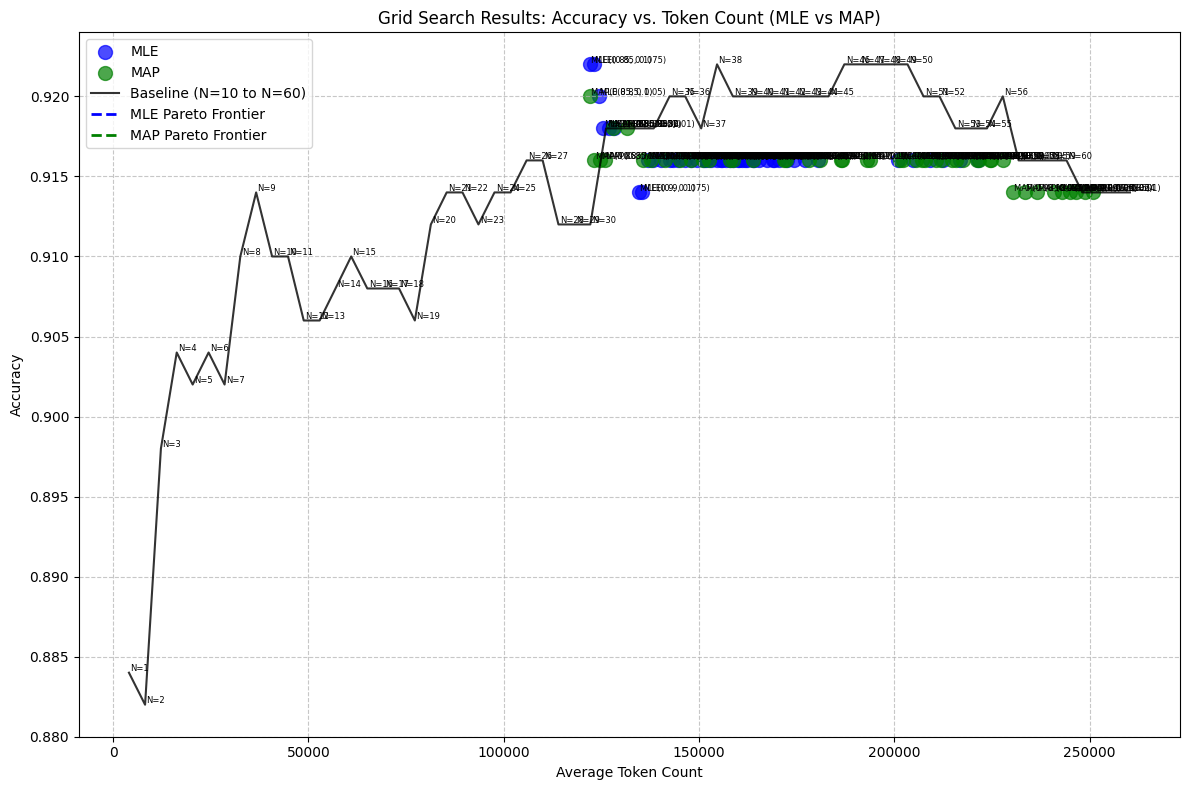


MLE Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9220, Avg Token Count: 121982.55

MAP Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9200, Avg Token Count: 121975.21


In [12]:
max_N_panel = 64
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)